# 一、单目标PV部署分区决策图

## 1、Load data

In [2]:
import pandas as pd
from function import *
from function.global_varibles import *
import geopandas as gpd
from shapely.geometry import Point

df_economic_feasibility=pd.read_csv(PATHS['df_economic_feasibility'])
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')



#这里把生成的数据预处理了一下，新计算的数据
def clip_data_with_us_states(df, lon_col='lon', lat_col='lat'):
    """
    Clip a dataframe using US states shapefile
    """
    # Create geometry points from coordinates
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    
    # Ensure US states has the same CRS
    us_states_4326 = us_states.to_crs('EPSG:4326')
    
    # Perform spatial join to find points within US states
    clipped_gdf = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    
    # Remove geometry columns and keep original data
    clipped_df = clipped_gdf.drop(columns=['geometry', 'index_right'])
    
    # Remove any additional columns from the shapefile that might have been added
    shapefile_columns = us_states.columns.tolist()
    for col in shapefile_columns:
        if col in clipped_df.columns:
            clipped_df = clipped_df.drop(columns=[col])
    
    return clipped_df

# df_economic_feasibility=clip_data_with_us_states(df_economic_feasibility)
# df_economic_feasibility.to_csv('data/US_data/df_economic.csv', index=False)





In [3]:
from matplotlib import pyplot as plt
from function import *
from function.global_varibles import *
import glob
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np



# Function to clip dataframes using the US states shapefile
def clip_data_with_us_states(df, lon_col='lon', lat_col='lat'):
    """
    Clip a dataframe using US states shapefile
    """
    # Create geometry points from coordinates
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    
    # Ensure US states has the same CRS
    us_states_4326 = us_states.to_crs('EPSG:4326')
    
    # Perform spatial join to find points within US states
    clipped_gdf = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    
    # Remove geometry columns and keep original data
    clipped_df = clipped_gdf.drop(columns=['geometry', 'index_right'])
    
    # Remove any additional columns from the shapefile that might have been added
    shapefile_columns = us_states.columns.tolist()
    for col in shapefile_columns:
        if col in clipped_df.columns:
            clipped_df = clipped_df.drop(columns=[col])
    
    return clipped_df

# # Clip all your dataframes
# df_economic = clip_data_with_us_states(df_economic)
# df_weight = clip_data_with_us_states(df_weight)
# df_strategies = clip_data_with_us_states(df_strategies)
# df_net_benefit = clip_data_with_us_states(df_net_benefit)
# df_pv_npv = clip_data_with_us_states(df_pv_npv)
# df_agricultural_npv = clip_data_with_us_states(df_agricultural_npv)
# df_afforestation_npv = clip_data_with_us_states(df_afforestation_npv)
# df_natural_npv = clip_data_with_us_states(df_natural_npv)

df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_weight = pd.read_csv('data/US_data/df_weight.csv')
df_strategies = pd.read_csv('data/US_data/df_strategies.csv')
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')
df_pv_npv = pd.read_csv('data/US_data/df_pv_npv.csv')
df_agricultural_npv = pd.read_csv('data/US_data/df_agricultural_npv.csv')
df_afforestation_npv = pd.read_csv('data/US_data/df_afforestation_npv.csv')
df_natural_npv = pd.read_csv('data/US_data/df_natural_npv.csv')
df_gmm_scores = pd.read_csv('data/US_data/df_gmm_scores.csv')
df_pixel_optimized_data = pd.read_csv('data/US_data/df_pixel_optimized_data.csv')


# df_weight = df_weight.merge(
#     df_gmm_scores[['lat', 'lon', 'gmm_score', 'gmm_density','predicted_label','predicted_prob','sample_type']],
#     on=['lat', 'lon'],
#     how='left'
# )
# df_weight.to_csv('data/US_data/df_weight.csv', index=False)









### 1.1 分析数据导入(精准导入)

这个数据是在7.0分析模块处理的，修正了发电量数据，一般情况调用这个即可，如果调用之前数据需要覆盖调整；


In [2]:
df_analysis=pd.read_csv(r'data\US_data\df_merged_data_for_analysis.csv')
df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_analysis

,lat,lon,predicted_prob,gmm_density,sample_type,Expectation_net_benefit,pv_potential_dens,LNCS_expect,net_npv_usd,area_m2,E_yr_pixel,pv_potential_total(t),power_generation_kwha,Expectation_net_benefit_adjust,ccd_optimized
0,25.295834,-80.287500,0.000000,3.874315e+16,negative_sample,6382.303639,7191.865919,809.562299,407275.912577,776295.361002,1.958127e+08,5568.344207,7.567199e+07,4758.781908,0.813290
1,25.437500,-80.537500,0.046746,2.054387e+18,prediction,5690.624063,7035.368191,1344.744161,283953.326746,775385.854124,1.913273e+08,5447.174926,7.402534e+07,4102.430766,0.755979
2,25.437500,-80.495834,0.000000,4.247702e+15,negative_sample,6055.300591,7024.124059,968.823440,275019.106094,775385.854124,1.910215e+08,5438.469092,7.390703e+07,4469.645652,0.785107
3,25.445833,-80.454170,0.000000,1.117299e+13,negative_sample,6048.645138,7017.640780,968.995616,269947.631894,775332.207938,1.908320e+08,5433.449375,7.383881e+07,4464.453759,0.783940
4,25.445833,-80.404170,0.017465,4.463459e+17,prediction,6081.010322,7045.490473,964.480123,291620.314126,775332.207938,1.915894e+08,5455.012162,7.413184e+07,4490.532039,0.790277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64977,48.995834,-111.970830,0.026153,1.493778e+17,prediction,6210.923349,6392.674772,181.751426,-220868.055076,563356.382622,1.263101e+08,4949.565792,6.726299e+07,4767.814366,0.653804
64978,48.995834,-110.345830,0.068266,4.120084e+17,prediction,6206.053157,6395.853979,189.800818,-219393.096487,563356.382622,1.263729e+08,4952.027311,6.729644e+07,4762.226494,0.653879
64979,48.995834,-106.020836,0.065097,3.232082e+17,prediction,6204.952188,6412.037900,207.085706,-205704.827949,563356.382622,1.266927e+08,4964.557807,6.746673e+07,4757.472100,0.650767
64980,48.995834,-104.087500,0.109234,6.627032e+21,prediction,6077.421747,6292.888713,215.466966,-300314.323514,563356.382622,1.243385e+08,4872.305853,6.621305e+07,4656.838886,0.611981


In [3]:

# 环境维度的变量
env_data = df_analysis[['lat', 'lon', 'predicted_prob','gmm_density','sample_type']].copy()

# 碳减排维度的变量

emission_data = df_analysis[['lat', 'lon', 'Expectation_net_benefit_adjust','area_m2']].copy()
emission_data = emission_data.rename(columns={'Expectation_net_benefit_adjust': 'Expectation_net_benefit'})

# 经济维度的变量
economic_2050 = df_economic[df_economic['analysis_year'] == 2050]
avg_npv = economic_2050.groupby(['lat', 'lon'])['net_npv_usd'].mean().reset_index().rename(columns={'net_npv_usd': 'avg_npv'})


# 合并所有变量
merged_data_for_plot = env_data.merge(emission_data, on=['lat', 'lon'], how='outer') \
                      .merge(avg_npv, on=['lat', 'lon'], how='outer')


                      

In [4]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO



us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')

# 2. 读取DEM并设置CRS（如果缺失）
dem = rioxarray.open_rasterio(r'figure\draw_shp\DEM.nc', masked=True)

# 检查DEM的CRS，如果缺失则手动设置
if dem.rio.crs is None:
    # 根据DEM数据的坐标范围判断，通常全球DEM使用EPSG:4326
    print("DEM CRS缺失，设置为EPSG:4326")
    dem = dem.rio.write_crs("EPSG:4326")

# 3. 确保US nation的CRS与DEM一致
if us_nation.crs != dem.rio.crs:
    print(f"转换US nation CRS从 {us_nation.crs} 到 {dem.rio.crs}")
    us_nation = us_nation.to_crs(dem.rio.crs)



# 4. 用us_nation精确裁剪DEM
print("开始裁剪DEM（使用us_nation）...")
dem_us = dem.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)
print("DEM裁剪完成！")





DEM CRS缺失，设置为EPSG:4326
转换US nation CRS从 EPSG:4269 到 EPSG:4326
开始裁剪DEM（使用us_nation）...
DEM裁剪完成！


## 2、决策图绘图模块

### 2.1 单维度决策图汇总

In [112]:
merged_data_for_plot

,lat,lon,predicted_prob,gmm_density,sample_type,Expectation_net_benefit,area_m2,avg_npv
0,25.295834,-80.287500,0.000000,3.874315e+16,negative_sample,4758.781908,776295.361002,407275.912577
1,25.437500,-80.537500,0.046746,2.054387e+18,prediction,4102.430766,775385.854124,283953.326746
2,25.437500,-80.495834,0.000000,4.247702e+15,negative_sample,4469.645652,775385.854124,275019.106094
3,25.445833,-80.454170,0.000000,1.117299e+13,negative_sample,4464.453759,775332.207938,269947.631894
4,25.445833,-80.404170,0.017465,4.463459e+17,prediction,4490.532039,775332.207938,291620.314126
...,...,...,...,...,...,...,...,...
64977,48.995834,-111.970830,0.026153,1.493778e+17,prediction,4767.814366,563356.382622,-220868.055076
64978,48.995834,-110.345830,0.068266,4.120084e+17,prediction,4762.226494,563356.382622,-219393.096487
64979,48.995834,-106.020836,0.065097,3.232082e+17,prediction,4757.472100,563356.382622,-205704.827949
64980,48.995834,-104.087500,0.109234,6.627032e+21,prediction,4656.838886,563356.382622,-300314.323514


DEM CRS缺失，设置为EPSG:4326
转换US nation CRS从 EPSG:4269 到 EPSG:4326
开始裁剪DEM（使用us_nation）...
DEM裁剪完成！


In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box, LineString
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.ops import unary_union
try:
    from shapely import make_valid
except Exception:
    make_valid = None
import matplotlib as mpl
import matplotlib.ticker as mticker


def plot_single_variable_nature_style(
    merged_data_for_plot, 
    us_states_gdf, 
    dem_data, 
    variable_name,
    title=None, 
    unit=None, 
    colors=None, 
    cmap_type='sequential',
    add_north_arrow_and_scalebar=True,
    add_embedding_points=False  
):
    """
    绘制单变量地图，Nature风格
    
    Parameters:
    -----------
    merged_data_for_plot : DataFrame
        包含经纬度和变量数据的数据框
    us_states_gdf : GeoDataFrame
        美国州界数据
    dem_data : xarray.Dataset
        DEM地形数据
    variable_name : str
        要绘制的变量名
    title : str, optional
        图表标题
    unit : str, optional
        变量单位
    colors : list, optional
        颜色列表
    cmap_type : str, default 'sequential'
        颜色映射类型
    add_north_arrow_and_scalebar : bool, default True
        是否添加指北针和比例尺
    add_embedding_points : bool, default False
        是否添加嵌入点
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    
    # ==================== 1. 初始设置 ====================
    plt.rcParams.update({
        "font.family": "Arial",
        "pdf.fonttype": 42, 
        "ps.fonttype": 42,
        "axes.linewidth": 0.5, 
        "axes.edgecolor": "black",
        "ps.usedistiller": "ghostscript",
        "ps.distiller.res": 6000,
    })

    # 创建图形和坐标轴
    fig, ax = plt.subplots(1, 1, figsize=(100/25.4, 60/25.4))
    ax.set_autoscale_on(False)
    fig.patch.set_facecolor('white')      
    ax.set_facecolor('#e6f3ff')

    # ==================== 2. 地理边界设置 ====================
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    
    # 处理州界数据
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    
    # 处理国界线
    us_nation_bound = us_nation.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')

    # ==================== 3. 坐标变换设置 ====================
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    # ==================== 4. 地图范围计算 ====================
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds

    # 边界调整
    margin_x_left = (xmax - xmin) * 0.08   # 增大左边界
    margin_x_right = (xmax - xmin) * 0.02  # 减小右边界
    margin_y = (ymax - ymin) * 0.08

    # 在ymin留更多空给color bar
    colorbar_space = (ymax - ymin) * 0.08  
    xmin = xmin - margin_x_left
    xmax = xmax + margin_x_right
    ymin = ymin - margin_y * 1 - colorbar_space
    ymax = ymax + margin_y * 0.8

    # 画布比例调整
    fig_width, fig_height = fig.get_size_inches()
    aspect_ratio = fig_width / fig_height
    data_width = xmax - xmin
    data_height = ymax - ymin
    data_aspect = data_width / data_height
    # 如果数据宽/高> 画布本身的宽/高，则说明数据过宽，适当调整高度
    # 先判断数据宽高比与画布宽高比，非线性地调整边界，避免画布变形
    if data_aspect > aspect_ratio:
        # 数据过宽，调整y范围，保持中心
        center_y = (ymin + ymax) / 2
        new_height = data_width / aspect_ratio
        ymin = center_y - new_height / 2
        ymax = center_y + new_height / 2
        # 适度放大y范围，避免边界裁切
        ymin *= 1.05
        ymax *= 1.05
    else:
        # 数据偏高，调整x范围，保持中心
        center_x = (xmin + xmax) / 2
        new_width = data_height * aspect_ratio
        xmin = center_x - new_width / 2
        xmax = center_x + new_width / 2
        # 适度收缩x范围，突出主体
        xmin *= 0.9
        xmax *= 1

    # 设置坐标轴位置和范围
    ax.set_position([0.0, 0.08, 1, 0.87])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ==================== 5. 数据坐标转换 ====================
    x_proj, y_proj = transformer.transform(merged_data_for_plot['lon'].values, 
                                          merged_data_for_plot['lat'].values)

    # ==================== 6. 地形渲染 ====================
    qm = _render_terrain(ax, dem_data, usa_bounds_main, transformer)

    # ==================== 7. 地图元素绘制 ====================
    # 绘制国界线光晕效果
    _draw_glow_outline_outside(ax, us_nation_albers)
    
    # 绘制州界
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4, alpha=0.4, zorder=9)

    # ==================== 8. 坐标轴设置 ====================
    _setup_axes_and_graticule(ax, usa_bounds_main, proj_fwd, proj_inv)

    # ==================== 9. 背景地图 ====================
    _draw_background_map(ax, usa_bounds_main)

    # ==================== 10. 数据可视化 ====================
    var_values = np.round(np.asarray(merged_data_for_plot[variable_name].values, dtype=float), 3)
    var_bins = np.nanpercentile(var_values, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    cmap = LinearSegmentedColormap.from_list(f"{variable_name}_cmap", colors, N=11)
    norm = BoundaryNorm(var_bins, ncolors=cmap.N)
    
    scatter = ax.scatter(x_proj, y_proj, c=var_values, cmap=cmap, norm=norm,
                        s=0.3, alpha=1, edgecolors='none', zorder=5)

    # ==================== 11. 颜色条 ====================
    _add_colorbar(fig, ax, scatter, var_bins, variable_name, unit)

    # ==================== 12. 最终处理 ====================
    fig.canvas.draw()          
    if qm is not None:
        qm.set_clip_path(ax.patch)
        qm.set_rasterized(True)

    return fig, ax


def _render_terrain(ax, dem_data, usa_bounds_main, transformer):
    """渲染地形"""
    qm = None
    dem_lon = dem_data.x.values
    dem_lat = dem_data.y.values
    lon_mask = (dem_lon >= usa_bounds_main['lon_min']) & (dem_lon <= usa_bounds_main['lon_max'])
    lat_mask = (dem_lat >= usa_bounds_main['lat_min']) & (dem_lat <= usa_bounds_main['lat_max'])
    
    if lon_mask.any() and lat_mask.any():
        lon_idx = np.where(lon_mask)[0]
        lat_idx = np.where(lat_mask)[0]
        
        # 抽稀栅格
        step_x = max(1, len(lon_idx)//1800)
        step_y = max(1, len(lat_idx)//900)
        lon_sub = lon_idx[::step_x]
        lat_sub = lat_idx[::step_y]
        elev = dem_data.squeeze().values[np.ix_(lat_sub, lon_sub)]

        mask = ~np.isnan(elev)
        if mask.any():
            lo = np.nanpercentile(elev, 35)
            elev[elev < lo] = np.nan

            # 地形配色
            terrain_colors = ListedColormap(["#ffffff", "#eef3ef", "#dfe8e0",
                                           "#d2ddcf", "#c7d1c1", "#b7c2af"])
            terrain_colors.set_bad((0, 0, 0, 0))
            qs = np.nanpercentile(elev, [35, 50, 65, 78, 88, 98])
            norm = BoundaryNorm(qs, terrain_colors.N)

            lon_grid, lat_grid = np.meshgrid(dem_lon[lon_sub], dem_lat[lat_sub])
            gx, gy = transformer.transform(lon_grid, lat_grid)            
            qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,
                              shading='auto', alpha=0.55, antialiased=False, zorder=1)
            qm.set_clip_on(True)
    
    return qm


def _draw_glow_outline_outside(ax, gdf_albers, line_color="#444444", line_width=0.8,
                              widths_km=(0, 30, 50), alphas=(0.95, 0.5, 0.3), 
                              colors=("#08336e", "#105ca4", "#3888c0")):
    """绘制国界线光晕效果"""
    g = gdf_albers.copy()
    geom = unary_union(g.geometry)
    
    if make_valid is not None:
        geom = make_valid(geom)
    else:
        geom = geom.buffer(0)

    radii_m = [k*1000.0 for k in widths_km]
    ordered = list(zip(radii_m, alphas, colors))
    ordered.sort(key=lambda x: x[0])

    last_inner = geom.buffer(0, join_style=2, cap_style=2)
    glow_meshes = []
    
    for i, (r, alpha, color) in enumerate(ordered):
        outer = geom.buffer(r, join_style=2, cap_style=2)
        ring = outer.difference(last_inner)
        if not ring.is_empty:
            glow_series = gpd.GeoSeries([ring], crs=g.crs)
            glow_mesh = glow_series.plot(ax=ax, color=color, alpha=alpha, edgecolor="none",
                                       zorder=8.2 + i*0.01)
            glow_meshes.append(glow_mesh)
        last_inner = outer

    g.boundary.plot(ax=ax, color=line_color, linewidth=line_width, zorder=9.6)
    return glow_meshes


def _setup_axes_and_graticule(ax, usa_bounds_main, proj_fwd, proj_inv):
    """设置坐标轴和经纬度网格"""
    # 设置数据框线
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_color('black')

    # 经纬度刻度
    lon_ticks = np.arange(-125, -55, 10)
    lat_ticks = [25, 30, 35, 40, 45, 50]
    
    # 绘制网格线和设置刻度
    _draw_graticule(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)


def _draw_graticule(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线
    xticks, xlabels = [], []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        p = _choose_point_on_edge(line.intersection(bottom))
        if p is None:
            p = _choose_point_on_edge(line.intersection(top))
        if p is not None:
            # 检查与已有标签的最小距离
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])  # 2%的图宽
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                xlabels.append(f"{abs(int(round(lon)))}°W")

        if i <= len(lon_ticks) :
            ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

    # 纬度刻度和网格线
    yticks, ylabels = [], []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        p = _choose_point_on_edge(line.intersection(left))
        if p is None:
            p = _choose_point_on_edge(line.intersection(right))
        if p is not None:
            yticks.append(p.y)
            ylabels.append(f"{int(round(lat))}°N")

        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

    # 设置刻度
    order = np.argsort(xticks)
    ax.xaxis.set_major_locator(mticker.FixedLocator([xticks[i] for i in order]))
    ax.xaxis.set_major_formatter(mticker.FixedFormatter([xlabels[i] for i in order]))

    order = np.argsort(yticks)
    ax.yaxis.set_major_locator(mticker.FixedLocator([yticks[i] for i in order]))
    ax.yaxis.set_major_formatter(mticker.FixedFormatter([ylabels[i] for i in order]))

    ax.tick_params(axis='both', labelsize=5, pad=1)
    for label in ax.get_yticklabels():
        label.set_rotation(90)


def _draw_background_map(ax, usa_bounds_main):
    """绘制背景地图"""
    try:
        bbox_expanded = box(
            usa_bounds_main['lon_min'] - 3, usa_bounds_main['lat_min'] - 3,
            usa_bounds_main['lon_max'] + 3, usa_bounds_main['lat_max'] + 3
        )
        helper_gdf = gpd.read_file(r'figure\draw_shp\ne_110m_land.shp').to_crs(4326)
        helper_gdf = helper_gdf.clip(bbox_expanded)
        
        if 'featurecla' in helper_gdf.columns:
            helper_gdf = helper_gdf[helper_gdf['featurecla'].str.contains('Land', na=False)]
        
        if make_valid is not None:
            helper_gdf['geometry'] = helper_gdf.geometry.map(make_valid)
        else:
            helper_gdf['geometry'] = helper_gdf.geometry.buffer(0)
            
        helper_gdf = helper_gdf[helper_gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])]
        helper_gdf = helper_gdf.explode(index_parts=False, ignore_index=True)
        helper_gdf_proj = helper_gdf.to_crs('ESRI:102003')
        helper_gdf_proj['geometry'] = helper_gdf_proj.buffer(0)
        helper_gdf_proj.plot(ax=ax, facecolor='white', edgecolor='lightgray',
                           linewidth=0.3, alpha=1, zorder=0.5)
    except Exception as e:
        print(f"Helper map error: {e}")


def _add_colorbar(fig, ax, scatter, var_bins, variable_name, unit):
    """添加颜色条"""
    def add_horizontal_cbar_equiv(fig, ax, mappable, var_bins, unit_display=None):
        pos = ax.get_position()
        left = pos.x0 + 0.03 * pos.width
        bottom = pos.y0 + 0.08 * pos.height
        width = 0.37 * pos.width
        height = 0.05 * pos.height

        cax = fig.add_axes([left, bottom, width, height])
        cax.set_in_layout(False)
        cax.set_zorder(50)  
        cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')

        cb.set_ticks(var_bins[1::2])

        # 格式化刻度标签
        tick_vals = var_bins[1::2]
        if variable_name == 'avg_npv':
            tick_labels = [f'{v/1_000_000:.2f}' for v in tick_vals]
        elif variable_name == 'predicted_prob':
            tick_labels = [f'{v:.2f}' for v in tick_vals]
        elif variable_name == 'Expectation_net_benefit':
            tick_labels = [f'{v/1_000:.2f}' for v in tick_vals]
        else:
            tick_labels = [f'{v:.0f}' for v in tick_vals]
        cb.set_ticklabels(tick_labels)

        # 细长
        cax.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=1, labelsize=5)
        cax.tick_params(axis='x', which='minor', length=1.5, width=0.4, label1On=False)
        cb.outline.set_linewidth(0.7)

        # 百分位标签
        percentile_labels = [f'Top{p}' for p in range(10, 101, 20)][::-1]
        major_tick_locs = cb.get_ticks()
        for loc, label in zip(major_tick_locs, percentile_labels):
            x_disp = cax.transData.transform((loc, 0))[0]
            x_frac = cax.transAxes.inverted().transform((x_disp, 0))[0]
            cax.text(x_frac, 1.1, label, transform=cax.transAxes,
                    ha='center', va='bottom', fontsize=5, clip_on=False)
        cax.text(1.08, 1.22, "(%)", ha='center', va='bottom', fontsize=5, 
                fontweight='bold', transform=cax.transAxes)

        for ch in cax.get_children():
            try:
                ch.set_clip_path(cax.patch)
            except Exception:
                pass

        return cax, cb

    # 控制单位标签
    if variable_name == 'net_npv_usd':
        unit_display = f'{unit} (10⁶)'
    elif variable_name == 'Expectation_net_benefit':
        unit_display = f'{unit} (10³)'
    else:
        unit_display = f'{unit} '

    cbar_ax, cbar = add_horizontal_cbar_equiv(fig, ax, scatter, var_bins, unit_display)
    cbar_ax.text(1.05, -0.3, unit_display, ha='left', va='top', fontsize=5, 
                fontweight='bold', transform=cbar_ax.transAxes)



In [ ]:

# ==================== 主程序 ====================
# 定义三个变量的参数
variables_config = [
    {
        'name': 'predicted_prob',
        'title': 'Environmental Potential',
        'unit': 'Probability',
        'colors': [
            '#ff9933','#ffb347' ,'#ffc04c', '#ffe066',  '#fff2cc',
            '#e0d7f5','#c6b6e6','#ad95d7','#9474c8','#7b53b9','#6232aa'
        ],
        'filename': 'environmental score'
    },
    {
        'name': 'Expectation_net_benefit', 
        'title': 'Carbon Mitigation Potential',
        'unit': 'MgC/ha ',
        'colors': [
            '#8e0152', '#c51b7d', '#de77ae', '#f1b6da', '#fde0ef',
            '#d9f0d3', '#b8e186', '#7fbc41', '#4d9221', '#276419', '#00441b'
        ],
        'filename': 'carbon_mitigation_potential'
    },
    {
        'name': 'avg_npv',
        'title': 'Economic Potential', 
        'unit': 'USD/ha',
        'colors': [
            '#543005', '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
            '#e0f7fa', '#c7eae5', '#80cdc1', '#35978f', '#01665e', '#003c30'
        ],
        'filename': 'economic_potential'
    }
]

# 生成三个单独的图
panel_labels = ['a', 'b', 'c']

for i, var_config in enumerate(variables_config):
    try:
        add_north_arrow_and_scalebar = (i == 0)
        add_embedding_points = False

        fig, ax = plot_single_variable_nature_style(
            merged_data_for_plot, 
            us_states_4326, 
            dem_us,
            var_config['name'],
            var_config['title'],
            var_config['unit'],
            var_config['colors'],
            add_north_arrow_and_scalebar=add_north_arrow_and_scalebar,
            add_embedding_points=add_embedding_points
        )

        ax.text(-0.05, 1.05, panel_labels[i], transform=ax.transAxes,
                ha='left', va='top', fontsize=7, fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)

        # 保存图片
        filename_png = f"figure/US_figure/{var_config['filename']}_nature_style_300dpi.png"
        filename_pdf = f"figure/US_figure/{var_config['filename']}_nature_style_300dpi.pdf"
        
        fig.savefig(filename_png, dpi=300, facecolor='White')  
        fig.canvas.draw()
        fig.savefig(filename_pdf, dpi=300, facecolor='None')                       

        plt.show()
        plt.close(fig)

    except Exception as e:
        print(e)
        continue

print("所有图片生成完成！")

## 3、累积曲线模块

=== 数据预处理：使用merged_data_for_plot ===
数据行数: 64982
总面积: 4376972.78 公顷


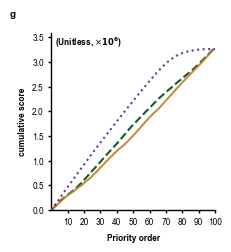

已生成 predicted_prob 的交叉目标分析图


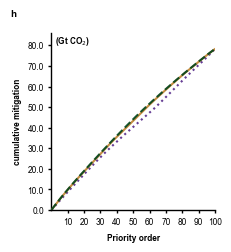

已生成 Expectation_net_benefit 的交叉目标分析图


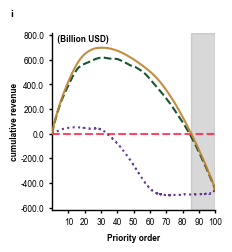

已生成 avg_npv 的交叉目标分析图
所有交叉目标分析图生成完成！


In [113]:
def create_cross_target_analysis_individual(merged_data_for_plot):
    """
    创建交叉目标分析图，逐个输出三个子图，参照plot_single_variable_nature_style的尺寸设计
    直接使用merged_data_for_plot作为数据源
    """
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    
    # 设置字体参数，参考plot_single_variable_nature_style
    plt.rcParams.update({
        "font.family": "Arial",
        "pdf.fonttype": 42, 
        "ps.fonttype": 42,
        "axes.linewidth": 0.5, 
        "axes.edgecolor": "black",
        "ps.usedistiller": "ghostscript",
        "ps.distiller.res": 6000,
    })

    # 定义三个变量
    variables = [
        ('predicted_prob', 'Environmental Suitability', 'Score'),
        ('Expectation_net_benefit', 'Emission Mitigation', 'Mg C'),
        ('avg_npv', 'Economic Feasibility', 'USD')
    ]

    # 修改颜色方案
    env_color = '#542788'   # 紫色
    carbon_color = '#00441b'  # 绿色
    economic_color = '#bf812d'  # 棕色

    # 映射变量名到颜色
    variable_colors = {
        'predicted_prob': env_color,
        'Expectation_net_benefit': carbon_color,
        'avg_npv': economic_color
    }

    # 映射变量名到线型
    variable_linestyles = {
        'predicted_prob': ':',      # 点线
        'Expectation_net_benefit': '--',  # 虚线
        'avg_npv': '-'              # 实线
    }

    # 面板标签
    panel_labels = ['g', 'h', 'i']

    # ==================== 数据预处理 ====================
    print("=== 数据预处理：使用merged_data_for_plot ===")
    print(f"数据行数: {len(merged_data_for_plot)}")
    
    # 检查必要的列是否存在
    required_cols = ['lat', 'area_m2'] + [var[0] for var in variables]
    missing_cols = [col for col in required_cols if col not in merged_data_for_plot.columns]
    if missing_cols:
        raise ValueError(f"缺少必要的列: {missing_cols}")
    
    # 计算总面积
    area_values = merged_data_for_plot['area_m2'].values / 10000  # 转换为公顷
    print(f"总面积: {np.sum(area_values):.2f} 公顷")

    # 逐个生成图片
    for idx, (variable_name, variable_label, unit) in enumerate(variables):
        # 参照plot_single_variable_nature_style的figsize，但调整为适合折线图的尺寸
        # fig, ax = plt.subplots(1, 1, figsize=(1.97, 1.6))  # 50mm width ≈ 1.97 inch
        # ax.set_title(variable_label, fontsize=7, fontweight='bold', ha='center', va='top', pad=12)
        fig, ax = plt.subplots(1, 1, figsize=(2.18, 2.36))  # 50mm x 60mm

        # 获取当前变量的数据
        benefit_density_values = merged_data_for_plot[variable_name].values
        if variable_name == 'Expectation_net_benefit':
            benefit_density_values = benefit_density_values / 0.27 

        if variable_name == 'predicted_prob':
            benefit_total_values = benefit_density_values * area_values
        else:
            benefit_total_values = benefit_density_values * area_values

        # 当前变量曲线（目标曲线）
        target_sorted_indices = np.argsort(benefit_total_values)[::-1]
        target_cumulative_benefits = np.cumsum(benefit_total_values[target_sorted_indices])
        target_cumulative_percentage = np.arange(1, len(target_cumulative_benefits) + 1) / len(target_cumulative_benefits) * 100
        target_cumulative_benefits = np.concatenate([[0], target_cumulative_benefits])
        target_cumulative_percentage = np.concatenate([[0], target_cumulative_percentage])

        # 其他两个变量的曲线（交叉曲线）
        cross_curves_data = []
        for other_var_name, other_var_label, other_unit in variables:
            if other_var_name != variable_name:
                other_density_values = merged_data_for_plot[other_var_name].values
                if other_var_name == 'Expectation_net_benefit':
                    other_density_values = other_density_values / 0.27 
                if other_var_name == 'predicted_prob':
                    other_total_values = other_density_values * area_values
                else:
                    other_total_values = other_density_values * area_values
                
                cross_sorted_indices = np.argsort(other_total_values)[::-1]
                cross_cumulative_benefits = np.cumsum(benefit_total_values[cross_sorted_indices])
                cross_cumulative_percentage = np.arange(1, len(cross_cumulative_benefits) + 1) / len(cross_cumulative_benefits) * 100
                cross_cumulative_benefits = np.concatenate([[0], cross_cumulative_benefits])
                cross_cumulative_percentage = np.concatenate([[0], cross_cumulative_percentage])
                
                cross_curves_data.append({
                    'label': f'By {other_var_label.split(" ")[0]}',
                    'color': variable_colors[other_var_name],
                    'linestyle': variable_linestyles[other_var_name],
                    'percentage': cross_cumulative_percentage,
                    'benefits': cross_cumulative_benefits,
                    'var_name': other_var_name
                })

        # 绘制目标曲线（当前变量）
        target_color_current = variable_colors[variable_name]
        target_linestyle_current = variable_linestyles[variable_name]
        ax.plot(target_cumulative_percentage, target_cumulative_benefits,
                 color=target_color_current, linewidth=1.5, alpha=0.9, 
                 linestyle=target_linestyle_current, zorder=8,
                 label=f'{variable_label.split(" ")[0]}')

        # 绘制交叉曲线（其他两个变量）
        for curve in cross_curves_data:
            ax.plot(curve['percentage'], curve['benefits'],
                     color=curve['color'], linewidth=1.5, alpha=0.9, 
                     linestyle=curve['linestyle'], zorder=6,
                     label=curve['label'])

        # 特殊处理NPV的Y=0线和阴影
        if variable_name == 'avg_npv':
            ax.axhline(y=0, color='#FF1744', linestyle='--', linewidth=1.5, alpha=0.8, zorder=7,
                      label='Break-even Line')
            
            # 找到Economic曲线与Y=0轴的交点
            economic_negative_mask = target_cumulative_benefits < 0
            if np.any(economic_negative_mask):
                first_negative_idx = np.where(economic_negative_mask)[0][0]
                if first_negative_idx > 0:
                    x1, y1 = target_cumulative_percentage[first_negative_idx-1], target_cumulative_benefits[first_negative_idx-1]
                    x2, y2 = target_cumulative_percentage[first_negative_idx], target_cumulative_benefits[first_negative_idx]
                    
                    if y2 != y1:
                        intersection_x = x1 + (x2 - x1) * (0 - y1) / (y2 - y1)
                        ax.axvspan(intersection_x, 100, color='gray', alpha=0.3, zorder=1, 
                                   label='Negative Region')

        # X轴标签
        ax.text(0.5, -0.13, 'Priority order', transform=ax.transAxes, ha='center', va='top',
                fontsize=6, fontweight='bold')

        # 设置X轴刻度
        key_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        xtick_positions = [p for p in key_percentages if p >= 10]
        xtick_labels = [f'{p}' for p in xtick_positions]
        ax.set_xticks(xtick_positions)
        ax.set_xticklabels(xtick_labels, ha='center', fontsize=6)
        ax.set_xlim(0, 100)

        # 设置Y轴范围和格式化
        all_curves_min = target_cumulative_benefits.min()
        all_curves_max = target_cumulative_benefits.max()
        for curve in cross_curves_data:
            all_curves_min = min(all_curves_min, curve['benefits'].min())
            all_curves_max = max(all_curves_max, curve['benefits'].max())
        
        if variable_name == 'predicted_prob':
            # Environmental: 除以1e6，保留1位小数，显示1e6
            ax.set_ylim(0, all_curves_max * 1.1)
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e6:.1f}'))
            ax.annotate(r'(Unitless, $\times\mathbf{10^6}$)', xy=(0.02, 0.99), xycoords='axes fraction', ha='left', va='top', fontweight='bold', fontsize=6)
            ax.set_ylabel('cumulative score', fontsize=6, fontweight='bold')
        elif variable_name == 'Expectation_net_benefit':
            # Emission: 除以1e9，保留1位小数，显示1e9
            ax.set_ylim(0, all_curves_max * 1.1)
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e9:.1f}'))
            ax.annotate(r'(Gt CO$_2$)', xy=(0.02, 0.99), xycoords='axes fraction', ha='left', va='top', fontweight='bold', fontsize=6)
            ax.set_ylabel('cumulative mitigation', fontsize=6, fontweight='bold')
        elif variable_name == 'avg_npv':
            # Economic: 除以1e9，保留1位小数，显示1e9
            y_range = all_curves_max - all_curves_min
            if y_range == 0:
                y_range = abs(all_curves_max) * 0.1
            ax.set_ylim(all_curves_min - y_range * 0.1, all_curves_max + y_range * 0.1)
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e9:.1f}'))
            ax.annotate(r' (Billion USD)', xy=(0.02, 0.99), xycoords='axes fraction', ha='left', va='top', fontweight='bold',fontsize=6)
            ax.set_ylabel('cumulative revenue', fontsize=6, fontweight='bold', labelpad=1.2)

        # 网格和样式设置
        # ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)  # 不需要网格，已注释
        ax.set_axisbelow(True)
        
        # 坐标轴样式设置
        ax.tick_params(axis='both', which='major', width=1, size=2, labelsize=6, color='black')
        # 设置坐标轴线的颜色和粗细
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_color('black')

        # 去掉上边框和右边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # 布局调整 - 参照plot_single_variable_nature_style的坐标轴位置
        ax.set_position([0.2, 0.15, 0.75, 0.75])  
        fig.text(0.01, 1, panel_labels[idx], ha='left', va='top', fontsize=7, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)

        # 保存图片
        filename_png = f"figure/US_figure/cross_target_{variable_name}_individual.png"
        filename_pdf = f"figure/US_figure/cross_target_{variable_name}_individual.pdf"
        
        fig.savefig(filename_png, dpi=300, facecolor='white', pad_inches=0.1)
        fig.canvas.draw()
        fig.savefig(filename_pdf, dpi=300, facecolor='white', pad_inches=0.1)
        
        plt.show()
        plt.close(fig)
        
        print(f"已生成 {variable_name} 的交叉目标分析图")

    print("所有交叉目标分析图生成完成！")
    return fig, ax

# 执行函数
fig, ax = create_cross_target_analysis_individual(merged_data_for_plot)

In [114]:
merged_data_for_plot

,lat,lon,predicted_prob,gmm_density,sample_type,Expectation_net_benefit,area_m2,avg_npv
0,25.295834,-80.287500,0.000000,3.874315e+16,negative_sample,4758.781908,776295.361002,407275.912577
1,25.437500,-80.537500,0.046746,2.054387e+18,prediction,4102.430766,775385.854124,283953.326746
2,25.437500,-80.495834,0.000000,4.247702e+15,negative_sample,4469.645652,775385.854124,275019.106094
3,25.445833,-80.454170,0.000000,1.117299e+13,negative_sample,4464.453759,775332.207938,269947.631894
4,25.445833,-80.404170,0.017465,4.463459e+17,prediction,4490.532039,775332.207938,291620.314126
...,...,...,...,...,...,...,...,...
64977,48.995834,-111.970830,0.026153,1.493778e+17,prediction,4767.814366,563356.382622,-220868.055076
64978,48.995834,-110.345830,0.068266,4.120084e+17,prediction,4762.226494,563356.382622,-219393.096487
64979,48.995834,-106.020836,0.065097,3.232082e+17,prediction,4757.472100,563356.382622,-205704.827949
64980,48.995834,-104.087500,0.109234,6.627032e+21,prediction,4656.838886,563356.382622,-300314.323514


In [115]:
# 期望净效益的单位是 Mg（兆克），将其转化为 Gt C 和 Gt CO2
# 1. 先计算总的 Mg
total_Mg = ((merged_data_for_plot['Expectation_net_benefit'] * merged_data_for_plot['area_m2']).sum()) / 10000  # 先转为ha后求和，单位仍为Mg

# 2. Mg 转 Gt C（1 Gt = 1e9 Mg）
total_GtC = total_Mg / 1e9

# 3. Gt C 转 Gt CO2（1 t C = 3.667 t CO2）
total_GtCO2 = total_GtC * 3.667

print(f"Total Mg: {total_Mg:.2e} Mg")
print(f"Total Gt C: {total_GtC:.4f} Gt C")
print(f"Total Gt CO2: {total_GtCO2:.4f} Gt CO2")

Total Mg: 2.11e+10 Mg
Total Gt C: 21.1111 Gt C
Total Gt CO2: 77.4146 Gt CO2


## 4、纬度分布模块

=== 数据预处理：使用merged_data_for_plot ===
数据行数: 64982
总面积: 4376972.78 公顷


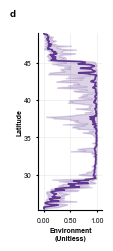

已生成 predicted_prob 的纬度分布图


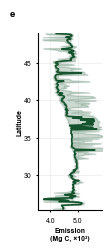

已生成 Expectation_net_benefit 的纬度分布图


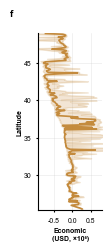

已生成 avg_npv 的纬度分布图
所有纬度分布图生成完成！


In [ ]:
def create_latitude_distribution_individual(merged_data_for_plot):
    """
    创建纬度分布图，逐个输出三个子图，优化尺寸为20mm宽度
    直接使用merged_data_for_plot作为数据源
    """
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    import scipy.stats as stats
    
    # 设置字体参数，参考create_cross_target_analysis_individual
    plt.rcParams.update({
        "font.family": "Arial",
        "pdf.fonttype": 42, 
        "ps.fonttype": 42,
        "axes.linewidth": 0.5, 
        "axes.edgecolor": "black",
        "ps.usedistiller": "ghostscript",
        "ps.distiller.res": 6000,
    })

    # 定义三个变量
    variables = [
        ('predicted_prob', 'Environmental Suitability', 'Score'),
        ('Expectation_net_benefit', 'Emission Mitigation', 'Mg C'),
        ('avg_npv', 'Economic Feasibility', 'USD')
    ]

    # 修改颜色方案
    env_color = '#542788'   # 紫色
    carbon_color = '#00441b'  # 绿色
    economic_color = '#bf812d'  # 棕色

    # 映射变量名到颜色
    variable_colors = {
        'predicted_prob': env_color,
        'Expectation_net_benefit': carbon_color,
        'avg_npv': economic_color
    }

    # 面板标签
    panel_labels = ['d', 'e', 'f']

    # ==================== 数据预处理 ====================
    print("=== 数据预处理：使用merged_data_for_plot ===")
    print(f"数据行数: {len(merged_data_for_plot)}")
    
    # 检查必要的列是否存在
    required_cols = ['lat', 'area_m2'] + [var[0] for var in variables]
    missing_cols = [col for col in required_cols if col not in merged_data_for_plot.columns]
    if missing_cols:
        raise ValueError(f"缺少必要的列: {missing_cols}")
    
    # 计算总面积
    area_values = merged_data_for_plot['area_m2'].values / 10000  # 转换为公顷
    print(f"总面积: {np.sum(area_values):.2f} 公顷")

    # 纬度分箱设置
    lat_bin_size = 0.1
    lat_min = merged_data_for_plot['lat'].min()
    lat_max = merged_data_for_plot['lat'].max()
    lat_bins = np.arange(lat_min, lat_max + lat_bin_size, lat_bin_size)
    df = merged_data_for_plot.copy()
    df['lat_binned'] = pd.cut(df['lat'], bins=lat_bins)
    df['lat_center'] = df['lat_binned'].apply(lambda x: x.mid if pd.notna(x) else np.nan)

    # 逐个生成图片
    for idx, (variable_name, variable_label, unit) in enumerate(variables):
        # 优化figsize: 20mm ≈ 0.79英寸, 保持高度1.9英寸
        # fig, ax = plt.subplots(1, 1, figsize=(0.79, 1.9))  
        fig, ax = plt.subplots(1, 1, figsize=(0.98, 2.36))  # 25mm x 60mm in inches

        # 获取当前变量的数据
        var_values = merged_data_for_plot[variable_name].values
        if variable_name == 'Expectation_net_benefit':
            var_values = var_values / 0.27

        # 计算纬度分布 - 使用分位数
        agg = (df.dropna(subset=[variable_name, 'lat_center'])
                 .groupby(['lat_center'], observed=True)[variable_name]
                 .agg(
                     median='median',
                     q25=lambda x: x.quantile(0.25),
                     q75=lambda x: x.quantile(0.75),
                     count='count'
                 ).reset_index())
        
        agg = agg[agg['count'] >= 5]  # 至少5个样本点

        if len(agg):
            # 绘制主线和分位数区间
            color = variable_colors[variable_name]
            
            # 绘制中位数线（实线）
            ax.plot(agg['median'], agg['lat_center'], lw=1.2, color=color, linestyle='-', alpha=0.9)
            
            # 绘制分位数区间（25%-75%）
            ax.fill_betweenx(agg['lat_center'], agg['q25'], agg['q75'], alpha=0.2, color=color)

        # 网格和样式设置
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.4, zorder=0)
        ax.set_axisbelow(True)
        
        # 坐标轴样式设置
        ax.tick_params(axis='both', which='major', width=0.8, size=1.5, labelsize=6, color='black')
        # 设置坐标轴线的颜色和粗细
        for spine in ax.spines.values():
            spine.set_linewidth(0.8)
            spine.set_color('black')

        # 去掉上边框和右边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # 设置坐标轴标签
        ax.set_ylabel('Latitude', fontsize=6, fontweight='bold', labelpad=1.0)

        # 设置Y轴范围
        ax.set_ylim(lat_min, lat_max)

        # 设置X轴范围和格式化 - 结合标签和刻度格式化
        if len(agg):
            x_margin = (agg['median'].max() - agg['median'].min()) * 0.1
            ax.set_xlim(agg['median'].min() - x_margin, agg['median'].max() + x_margin)
            
            # X轴标签和刻度格式化 - 保持一致性
            if variable_name == 'predicted_prob':
                # Environmental: 保持原值，保留2位小数
                ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.2f}'))
                # X轴标签和单位合并
                ax.text(0.5, -0.1, 'Environment\n(Unitless)', transform=ax.transAxes, ha='center', va='top', 
                        fontweight='bold', fontsize=6)
            elif variable_name == 'Expectation_net_benefit':
                # Emission: 除以1e3，保留1位小数，显示1e3
                ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e3:.1f}'))
                ax.text(0.5, -0.1, 'Emission\n(Mg C, ×10³)', transform=ax.transAxes, ha='center', va='top', 
                        fontweight='bold', fontsize=6)
            elif variable_name == 'avg_npv':
                # Economic: 除以1e6，保留1位小数，显示1e6
                ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e6:.1f}'))
                ax.text(0.5, -0.1, 'Economic\n(USD, ×10⁶)', transform=ax.transAxes, ha='center', va='top', 
                        fontweight='bold', fontsize=6)

        # 布局调整 - 进一步优化数据框位置
        ax.set_position([0.3, 0.15, 0.65, 0.75])  # 左边界0.3，宽度0.65
        fig.text(0.01, 1, panel_labels[idx], ha='left', va='top', fontsize=7, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, pad=0.15, lw=0), zorder=100)

        # 保存图片
        filename_png = f"figure/US_figure/latitude_distribution_{variable_name}_individual.png"
        filename_pdf = f"figure/US_figure/latitude_distribution_{variable_name}_individual.pdf"
        
        fig.savefig(filename_png, dpi=300, facecolor='white', pad_inches=0.05)
        fig.canvas.draw()
        fig.savefig(filename_pdf, dpi=300, facecolor='white', pad_inches=0.05)
        
        plt.show()
        plt.close(fig)
        
        print(f"已生成 {variable_name} 的纬度分布图")

    print("所有纬度分布图生成完成！")
    return fig, ax

# 执行函数
fig, ax = create_latitude_distribution_individual(merged_data_for_plot)

## 5、雷达图模块

=== 数据预处理：使用merged_data_for_plot ===
数据行数: 64982
总面积: 4376972.78 公顷


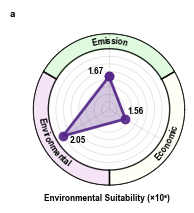

已生成 predicted_prob 的积分雷达图


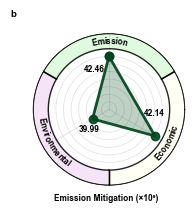

已生成 Expectation_net_benefit 的积分雷达图


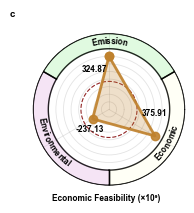

已生成 avg_npv 的积分雷达图
所有积分雷达图生成完成！


In [97]:
from matplotlib.textpath import TextPath
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as pe


from matplotlib.textpath import TextPath
from matplotlib.font_manager import FontProperties

def _interp_radius_at(theta, angs, rads):
    """在多边形上插值：给定角 theta，返回该角度处外框线(边)的半径"""
    import numpy as np
    angs = np.asarray(angs, dtype=float)
    rads = np.asarray(rads, dtype=float)
    angs_ext = np.concatenate([angs, [angs[0] + 2*np.pi]])
    rads_ext = np.concatenate([rads, [rads[0]]])
    th = float(theta)
    if th < angs_ext[0]:
        th += 2*np.pi
    i = np.searchsorted(angs_ext, th, side='right') - 1
    i = int(np.clip(i, 0, len(angs_ext) - 2))
    a0, a1 = angs_ext[i], angs_ext[i+1]
    t = (th - a0) / (a1 - a0 + 1e-12)
    return rads_ext[i] + t * (rads_ext[i+1] - rads_ext[i])

def place_value_label_toward(ax, vertex_ang, vertex_r, text, *,
                             target_theta_deg,
                             base_angles, base_norm,
                             inner_radius=0.80,
                             ring_margin=0.03,        # 与内环的最小距离(到文本外沿)
                             poly_margin=0.02,        # 与多边形外框线的最小径向距离
                             min_point_gap=0.03,      # 与顶点最小径向距离(考虑marker)
                             radial_shift=-0.04,      # 相对顶点的默认径向位移(负=向内)
                             fontsize=6, marker_size_pt=6):
    """
    将数值文本放到“向 target_theta_deg 方向”的位置，保持水平、黑色、无白底，
    并满足与顶点/外框线/内圆环的安全间距。
    """
    import numpy as np
    fp = FontProperties(family="Arial", size=fontsize, weight="bold")

    # 目标角（绝对极角）
    theta = np.deg2rad(float(target_theta_deg))

    # --- 像素换算(径向/切向) ---
    trans = ax.transData
    dpi = ax.figure.dpi
    p0 = trans.transform((theta, vertex_r))
    p_r1 = trans.transform((theta, vertex_r + 1.0))      # 径向 +1
    p_t1 = trans.transform((theta + 1.0, vertex_r))      # 角向 +1 rad
    px_per_dr     = np.hypot(*(p_r1 - p0)) or 1.0
    px_per_dtheta = np.hypot(*(p_t1 - p0)) or 1.0

    # 文本宽/高（pt→px）
    tp = TextPath((0, 0), text, prop=fp)
    w_pt = tp.get_extents().width
    h_pt = tp.get_extents().height
    half_w_px = (w_pt * dpi / 72.0) / 2.0
    half_h_px = (h_pt * dpi / 72.0) / 2.0
    half_h_dr = half_h_px / px_per_dr
    half_w_rad = half_w_px / px_per_dtheta

    # 顶点 marker 半径(转径向单位)
    marker_rad_px = (marker_size_pt / 2.0) * dpi / 72.0
    marker_rad_dr = marker_rad_px / px_per_dr

    # 径向安全范围（文本外沿不能碰内环；不能小于0）
    r_min = 0.02 + half_h_dr
    r_max = inner_radius - ring_margin - half_h_dr
    r_max = max(r_min, r_max)

    # 初始半径：在顶点基础上做默认径向位移
    r_tgt = np.clip(vertex_r + radial_shift, r_min, r_max)

    # 与“顶点”的最小径向间隙（包含 marker 和文本半高）
    min_gap_dr = max(min_point_gap, marker_rad_dr + 0.01) + half_h_dr
    if abs(r_tgt - vertex_r) < min_gap_dr:
        if radial_shift < 0:
            r_tgt = max(vertex_r - min_gap_dr, r_min)
        else:
            r_tgt = min(vertex_r + min_gap_dr, r_max)

    # 与“多边形外框线”的最小径向间隙
    r_edge = _interp_radius_at(theta, base_angles, base_norm)
    need_gap = poly_margin + half_h_dr
    if abs(r_tgt - r_edge) < need_gap:
        # 远离外框线：按默认方向(向内)优先
        if (r_tgt <= r_edge):
            r_tgt = max(r_edge - need_gap, r_min)
        else:
            r_tgt = min(r_edge + need_gap, r_max)

    # 最终放置（水平、黑字、无白底）
    ax.text(theta, r_tgt, text,
            ha='center', va='center',
            fontsize=fontsize, fontweight='bold', color='black',
            rotation=0, rotation_mode='anchor', zorder=9)



def draw_text_on_arc(ax, text, theta_center, radius,
                     fontproperties=None, letter_spacing=1.0,
                     fit_to_segment=True,
                     segment_span_deg=120, segment_margin_deg=12,
                     radius_offset=0.0):
    """
    在极坐标圆弧上按曲率绘制文字（整段统一方向/翻转，逐字沿切线）。
      - 上半圆(0≤θc≤π)：顺时针排布（角度递减），不翻转
      - 下半圆(π<θc<2π)：逆时针排布（角度递增），整体 +180° 翻转
    radius_offset: 控制文字距离圆心的偏移量（正值向外，负值向内）
    """
    if fontproperties is None:
        fontproperties = FontProperties(family="Arial", size=6, weight="bold")

    # 1) 逐字测宽（pt->px）
    dpi = ax.figure.dpi
    glyph_px = []
    spacing_factor = 1.1  # 原为1.0，适当加大
    for ch in text:
        if ch == ' ':
            space_w_pt = 0.35 * fontproperties.get_size()
            glyph_px.append(space_w_pt * dpi / 72.0 * letter_spacing * spacing_factor)
            continue
        tp = TextPath((0, 0), ch, prop=fontproperties)
        w_pt = tp.get_extents().width
        glyph_px.append(max(0.01, w_pt) * dpi / 72.0 * letter_spacing * spacing_factor)
    total_px = sum(glyph_px)

    # 2) px/rad 换算
    t0 = float(theta_center)
    p0 = ax.transData.transform((t0, radius))
    p1 = ax.transData.transform((t0 + 1.0, radius))  # +1 rad
    px_per_rad = np.hypot(*(p1 - p0)) or 1.0

    # 3) 超长则压缩到扇段宽度内
    if fit_to_segment:
        max_span_rad = np.deg2rad(max(5.0, segment_span_deg - 2*segment_margin_deg))
        need_rad = total_px / px_per_rad
        if need_rad > max_span_rad:
            scale = max_span_rad / need_rad
            glyph_px = [w * scale for w in glyph_px]
            total_px = sum(glyph_px)

    # 4) 以中心角判断半圆与翻转（整段一次性）
    theta_mod = t0 % (2*np.pi)
    on_upper = (0.0 <= theta_mod <= np.pi)
    flip_whole = (theta_mod > np.pi)          # 仅下半圆整体翻转
    step_sign  = (-1.0 if on_upper else +1.0) # 上半递减, 下半递增

    # 布局起点（让整段以中心角居中）
    start_theta = t0 - step_sign * (total_px / (2.0 * px_per_rad))

    # 5) 逐字绘制（沿切线；整段统一翻转）
    cursor = start_theta
    for wpx, ch in zip(glyph_px, text):
        theta_mid = cursor + step_sign * (wpx / (2.0 * px_per_rad))
        deg = np.degrees(theta_mid)

        rot = deg - 90.0
        if flip_whole:
            rot += 180.0

        # 这里控制向圆心移动距离：radius + radius_offset
        txt = ax.text(theta_mid, radius + radius_offset, ch,
                      fontproperties=fontproperties,
                      ha='center', va='center',
                      rotation=rot, rotation_mode='anchor',
                      clip_on=True, zorder=10)
        # txt.set_path_effects([pe.withStroke(linewidth=1.5, foreground='white')])

        cursor += step_sign * (wpx / px_per_rad)


def create_integration_radar_charts(merged_data_for_plot):
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter
    import numpy as np
    import pandas as pd
    import os
    from matplotlib.font_manager import FontProperties

    # ===== 全局样式 =====
    plt.rcParams.update({
        "font.family": "Arial",
        "pdf.fonttype": 42, 
        "ps.fonttype": 42,
        "axes.linewidth": 0.5, 
        "axes.edgecolor": "black",
        "ps.usedistiller": "ghostscript",
        "ps.distiller.res": 6000,
    })
    os.makedirs("figure/US_figure", exist_ok=True)

    # ===== 变量定义 =====
    variables = [
        ('predicted_prob', 'Environmental Suitability', 'Score'),
        ('Expectation_net_benefit', 'Emission Mitigation', 'Gt '),
        ('avg_npv', 'Economic Feasibility', 'USD')
    ]
    env_color = '#542788'
    carbon_color = '#00441b'
    economic_color = '#bf812d'
    variable_colors = {
        'predicted_prob': env_color,
        'Expectation_net_benefit': carbon_color,
        'avg_npv': economic_color
    }
    panel_labels = ['a', 'b', 'c']

    # ===== 数据检查 =====
    print("=== 数据预处理：使用merged_data_for_plot ===")
    print(f"数据行数: {len(merged_data_for_plot)}")
    required_cols = ['lat', 'area_m2'] + [v[0] for v in variables]
    missing_cols = [c for c in required_cols if c not in merged_data_for_plot.columns]
    if missing_cols:
        raise ValueError(f"缺少必要的列: {missing_cols}")
    area_values = merged_data_for_plot['area_m2'].values / 10000  # ha
    print(f"总面积: {np.sum(area_values):.2f} 公顷")

    # ===== 积分工具 =====
    def percentage_to_01(pct): return pct / 100.0
    def calculate_integral(x, y):
        if len(x) < 2: return 0.0
        if x[0] > x[-1]:
            x = x[::-1]; y = y[::-1]
        return np.trapz(y, x)

    # ===== 计算积分 =====
    all_integrals = {}
    for variable_name, variable_label, unit in variables:
        dens = merged_data_for_plot[variable_name].values.astype(float)
        if variable_name == 'Expectation_net_benefit':
            dens = dens / 0.27  # 请在文中解释该换算因子
        total_vals = dens * area_values

        integrals = {}
        # 目标曲线
        idx_sort = np.argsort(total_vals)[::-1]
        cum_ben = np.cumsum(total_vals[idx_sort])
        cum_pct = np.arange(1, len(cum_ben) + 1) / len(cum_ben) * 100
        cum_ben = np.concatenate([[0], cum_ben])
        cum_pct = np.concatenate([[0], cum_pct])
        x01 = percentage_to_01(cum_pct)
        integrals[f'{variable_label.split(" ")[0]}'] = calculate_integral(x01, cum_ben)

        # 交叉曲线
        for other_var_name, other_var_label, _ in variables:
            if other_var_name == variable_name:
                continue
            other_dens = merged_data_for_plot[other_var_name].values.astype(float)
            if other_var_name == 'Expectation_net_benefit':
                other_dens = other_dens / 0.27
            other_total = other_dens * area_values

            idx_cross = np.argsort(other_total)[::-1]
            cross_cum_ben = np.cumsum(total_vals[idx_cross])
            cross_cum_pct = np.arange(1, len(cross_cum_ben) + 1) / len(cross_cum_ben) * 100
            cross_cum_ben = np.concatenate([[0], cross_cum_ben])
            cross_cum_pct = np.concatenate([[0], cross_cum_pct])
            x01 = percentage_to_01(cross_cum_pct)  # ✅ 修正
            integrals[f'By {other_var_label.split(" ")[0]}'] = calculate_integral(x01, cross_cum_ben)

        all_integrals[variable_name] = integrals

    # ===== 雷达维度：120度等间距分布 =====
    categories = ['Emission', 'Environmental', 'Economic']
    custom_angles = [np.pi/2, 7*np.pi/6, 11*np.pi/6]  # 90°, 210°, 330°

    for idx, (variable_name, variable_label, unit) in enumerate(variables):
        fig, ax = plt.subplots(1, 1, figsize=(1.97, 1.97), subplot_kw=dict(projection='polar'))
        integrals = all_integrals[variable_name]

        # 组装数值（Emission, Environmental, Economic）
        values, labels = [], []
        for cat in categories:
            if cat in integrals:
                values.append(integrals[cat]); labels.append(cat)
            elif f'By {cat}' in integrals:
                values.append(integrals[f'By {cat}']); labels.append(f'By {cat}')

        # 数量级显示
        if variable_name == 'predicted_prob':
            display_values = [v/1e6 for v in values]; unit_suffix = ' (×10⁶)'
        elif variable_name == 'Expectation_net_benefit':
            display_values = [v/1e9 for v in values]; unit_suffix = ' (×10⁹)'
        elif variable_name == 'avg_npv':
            display_values = [v/1e9 for v in values]; unit_suffix = ' (×10⁹)'
        else:
            display_values = values; unit_suffix = ''

        # 标准化到 [0, 0.7]（留呼吸空间）
        if display_values:
            vmin, vmax = min(display_values), max(display_values)
            if vmax > vmin:
                vr = vmax - vmin
                center_offset = vmin - 0.3 * vr
                arange = (vmax - center_offset) / 0.7
                norm_vals = [(v - center_offset) / arange for v in display_values]
                norm_vals = [max(0, min(0.7, v)) for v in norm_vals]
                mn = min(norm_vals)
                if mn < 0.2:
                    s = 0.25 / max(mn, 1e-9)
                    norm_vals = [min(0.7, v*s) for v in norm_vals]
            else:
                norm_vals = [0.5] * len(display_values)
        else:
            norm_vals = [0] * len(categories)

        # 角度/闭合：保留“未闭合”版本用于顶点标注
        base_angles = custom_angles.copy()
        base_norm   = norm_vals[:]
        angles_closed = base_angles + base_angles[:1]
        norm_closed   = base_norm + base_norm[:1]

        # ===== 角度刻度（不显示文字，但用于绘制辐射网格）=====
        ax.set_xticks(base_angles)
        ax.set_xticklabels(['']*len(base_angles))

        # ===== 绘制面/线 =====
        ax.plot(angles_closed, norm_closed, 'o-', linewidth=2,
                color=variable_colors[variable_name], alpha=0.9, zorder=5)
        ax.fill(angles_closed, norm_closed, alpha=0.25,
                color=variable_colors[variable_name], zorder=4)

        # ===== 120°圆环 + 弯曲标签（保持你现有逻辑，略） =====
        outer_radius = 1.00
        inner_radius = 0.80
        ring_colors = {'Emission':'#90EE90','Environmental':'#DDA0DD','Economic':'#FFFFE0'}
        label_r = inner_radius + 0.12

        for angle, cat in zip(base_angles, categories):
            start_angle = angle - np.pi/3
            end_angle   = angle + np.pi/3
            theta_ring   = np.linspace(start_angle, end_angle, 120)
            inner_circle = [inner_radius] * len(theta_ring)
            outer_circle = [outer_radius] * len(theta_ring)
            ax.plot(theta_ring, inner_circle, 'k-', lw=1.0, alpha=0.85, zorder=2)
            ax.plot(theta_ring, outer_circle, 'k-', lw=1.0, alpha=0.85, zorder=2)
            ax.plot([start_angle, start_angle], [inner_radius, outer_radius], 'k-', lw=1.0, alpha=0.85, zorder=2)
            ax.plot([end_angle,   end_angle],   [inner_radius, outer_radius], 'k-', lw=1.0, alpha=0.85, zorder=2)
            ring_theta  = np.concatenate([theta_ring, theta_ring[::-1]])
            ring_radius = np.concatenate([inner_circle, outer_circle[::-1]])
            ax.fill(ring_theta, ring_radius, color=ring_colors[cat], alpha=0.28, zorder=1)

            # 弯曲标签（你已有的 draw_text_on_arc）
            draw_text_on_arc(
                ax, cat, theta_center=angle, radius=label_r,
                fontproperties=FontProperties(family="Arial", size=6, weight="bold"),
                letter_spacing=1.05, fit_to_segment=True,
                segment_span_deg=120, segment_margin_deg=10, radius_offset=-0.02
            )

        # ===== 顶点数值：水平、避让、不重叠 ====
        # 固定三维度的目标极角（度）
        target_theta_map = {'Emission': 110, 'Environmental': 225, 'Economic': 355}

        for ang_v, val, r_v, cat in zip(base_angles, display_values, base_norm, categories):
            # Environmental的第一张图（idx==0）向内挪动
            if cat == 'Environmental' and idx == 0:
                radial_shift = -0.03
            elif cat == 'Environmental' and idx in [1, 2]:
                radial_shift = 0.01
            elif cat == 'Emission' and idx in [0]:
                radial_shift = 0.0
            elif cat == 'Economic' and idx in [0]:
                radial_shift = 0.04
            elif cat == 'Economic' and idx in [1,2]:
                radial_shift = -0.01
            else:
                radial_shift = -0.01
            place_value_label_toward(
                ax, ang_v, r_v, f'{val:.2f}',
                target_theta_deg=target_theta_map[cat],
                base_angles=base_angles, base_norm=base_norm,
                inner_radius=inner_radius,
                ring_margin=0.03,
                poly_margin=0.02,
                min_point_gap=0.03,
                radial_shift=radial_shift,
                fontsize=6, marker_size_pt=6
            )


        # ===== 网格：有线条、无标签 =====
        ax.set_ylim(0, 1.0)
        # 设置若干同心圆半径（与 0.7 的可用区间匹配）
        radial_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
        ax.set_yticks(radial_levels)
        ax.set_yticklabels([''] * len(radial_levels))  # 不显示数值
        ax.grid(True, alpha=0.35, linewidth=0.6)
        ax.set_axisbelow(True)  # 网格在线条/面以下，避免压住顶点标注

        # 面板标签
        fig.text(0.01, 1, panel_labels[idx], ha='left', va='top', fontsize=7, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)

        # 下方显示维度与数量级
        fig.text(0.5, 0.02, f'{variable_label}{unit_suffix}',
                 ha='center', va='bottom', fontsize=6, fontweight='bold',
                 transform=fig.transFigure, zorder=100)

        # Economic：0 等值圈（保持你的逻辑）
        if variable_name == 'avg_npv' and display_values and (max(display_values) > min(display_values)):
            vr = vmax - vmin
            center_offset = vmin - 0.3 * vr
            arange = (vmax - center_offset) / 0.7
            zero_norm = (0 - center_offset) / arange
            zero_norm = max(0, min(0.7, zero_norm))
            theta = np.linspace(0, 2*np.pi, 240)
            ax.plot(theta, [zero_norm]*len(theta), '--', color='#800000', linewidth=0.8, alpha=0.85, zorder=3)

        # 保存
        png = f"figure/US_figure/integration_radar_{variable_name}_individual.png"
        pdf = f"figure/US_figure/integration_radar_{variable_name}_individual.pdf"
        fig.savefig(png, dpi=300, facecolor='white', pad_inches=0.08)
        fig.canvas.draw()
        fig.savefig(pdf, dpi=300, facecolor='white', pad_inches=0.08)
        plt.show(); plt.close(fig)

        print(f"已生成 {variable_name} 的积分雷达图")

    print("所有积分雷达图生成完成！")
    return fig, ax

fig, ax = create_integration_radar_charts(merged_data_for_plot)


## 6、三变量排序蜂窝图


1、绘图需求：创建一个美国本土三变量优先区重叠图，以显示优先区之间的重叠关系

////////////////////////////
2、绘图函数Logic
（1）输入merged_data_for_plot所需的关键变量variables = [
        ('predicted_prob', 'Environmental Suitability', 'Score'),
        ('Expectation_net_benefit', 'Emission Mitigation', 'Gt '),
        ('avg_npv', 'Economic Feasibility', 'USD')
    ]
（2）参照图中示例（参考Image），结合plot_bivariate_nature_style中的逻辑与绘图风格，首先，针对us_states_4326（州的矢量数据定义边界、并注意先用bbox裁剪）简化它的几何边界（或者将其栅格化）、对box内的几何面生成hexgrid（每个hexgird==2500 km²），从而覆盖满整个美国本土的area。（不要自行绘制hex，尽量使用h3\hexbin\等一些成熟的方案，这样能使得各个hex各个边界能无缝衔接）。同时，按照lat\lon 形成各个hex的索引。

（3）输入merged_data_for_plot所需的关键变量variables = [
        ('predicted_prob', 'Environmental Suitability', 'Score'),
        ('Expectation_net_benefit', 'Emission Mitigation', 'Gt '),
        ('avg_npv', 'Economic Feasibility', 'USD')
    ]

（4）在各个hexgrid内，检测是否有merged_data_for_plot的数据点，如果有就按照mean进行聚合，并为hex grids聚合后的变量按照percentile生成优先序，并记录priority order。（需要特别注意倒序转换，percentile: 1-priority order）。例如percentile是10%，那么它对应数字很小、priority order是90%。

（5）参照plot_bivariate_nature_style中的逻辑，if 在hex grids 中， 根据涉及变量是否if priority order > priority threshold生成组合（由于我输入的是3个变量，因此有8种情况）
if 在hex grids 只有一个维度 priority order >= priority threshold （3情况）
if 在hex grids 所有维度priority order < priority threshold （1情况）
if 在hex grids 所有维度priority order >= priority threshold （1情况）
if 在hex grids 有任意两个priority order >= priority threshold （3情况）

由于我输入的变量有3个，因此我总共有8种组合情况。
if 在hex grids 只有一个维度 priority order >= priority threshold
    env_color = '#542788'   # 紫色
    carbon_color = '#00441b'  # 绿色
    economic_color = '#bf812d'  # 棕色

其余颜色方案请你按照颜色之间重叠的方案判别，例如紫色+绿色 =偏蓝色、这意味着Environmental Suitability与Emission Mitigation均 priority order >= priority threshold，且Economic Feasibility维度的priority order < priority threshold

特殊情况：
if 在hex grids 只有所有维度priority order < priority threshold
在hex grids绘制一个圆圈，填充为黑色，这个圆的半径应该为hex边长的1/2
if 在hex grids 所有维度都是空
在hex grids绘制一个圆圈，填充为灰色，这个圆的半径应该为hex边长的1/2

（6）如果以上hex能够正确绘制、那么则打开自定义图例、并且将原来所有hexgrid填充为我自定的图例（参考Image）

////////////////////////////

绘图函数接口签名：

hexagonal grids（定义蜂窝大小，默认2500km²）
merged_data_for_plot（输入变量）
percentile threshold（分割阈值，以50%默认）
us_states_4326（州的矢量数据定义边界）
us_nation_4326
尽量减少不必要接口，颜色等可以在内部定义，不需要DEM

使用H3分辨率 4，对应面积约 1770.3 km²
创建了 6148 个六边形
生成三变量优先区蜂窝图时出错: name 'Point' is not defined


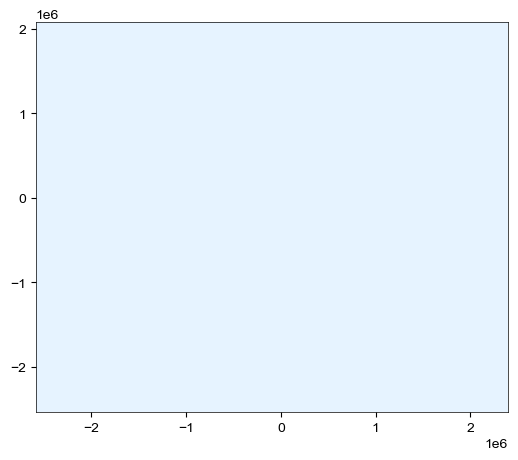

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box, LineString, Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.ops import unary_union
import h3
from scipy.spatial import cKDTree
from scipy.stats import percentileofscore

def plot_trivariate_priority_hexmap(
    merged_data_for_plot,
    us_states_4326,
    us_nation_4326,
    hex_area_km2=2500,
    priority_threshold=50,
    dem_data=None
):
    """
    绘制三变量优先区蜂窝图
    
    Parameters:
    -----------
    merged_data_for_plot : DataFrame
        包含经纬度和三个变量数据的数据框
    us_states_4326 : GeoDataFrame
        美国州界数据 (EPSG:4326)
    us_nation_4326 : GeoDataFrame
        美国国界数据 (EPSG:4326)
    hex_area_km2 : float
        每个六边形的面积 (km²)，默认2500
    priority_threshold : float
        优先区阈值 (percentile)，默认50%
    dem_data : xarray.Dataset, optional
        地形数据，用于背景渲染
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    
    # ==================== 1. 初始设置 ====================
    plt.rcParams.update({
        "font.family": "Arial",
        "pdf.fonttype": 42, 
        "ps.fonttype": 42,
        "axes.linewidth": 0.5, 
        "axes.edgecolor": "black",
        "ps.usedistiller": "ghostscript",
        "ps.distiller.res": 6000,
    })

    # 创建图形和坐标轴
    fig, ax = plt.subplots(1, 1, figsize=(120/25.4, 110/25.4))
    ax.set_autoscale_on(False)
    fig.patch.set_facecolor('white')      
    ax.set_facecolor('#e6f3ff')

    # ==================== 2. 地理边界设置 ====================
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    
    # 处理州界数据
    us_states_bound = us_states_4326.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    
    # 处理国界线
    us_nation_bound = us_nation_4326.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')

    # ==================== 3. 坐标变换设置 ====================
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    # ==================== 4. 地图范围计算 ====================
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds

    # 边界调整
    margin_x_left = (xmax - xmin) * 0.05  
    margin_x_right = (xmax - xmin) * 0.03  
    margin_y = (ymax - ymin) * 0.02        

    # 在ymin留更多空给color bar
    colorbar_space = (ymax - ymin) * 0.22
    xmin = xmin - margin_x_left
    xmax = xmax + margin_x_right
    ymin = ymin - margin_y * 1 - colorbar_space
    ymax = ymax + margin_y * 0.2  

    # 画布比例调整
    fig_width, fig_height = fig.get_size_inches()
    aspect_ratio = fig_width / fig_height
    data_width = xmax - xmin
    data_height = ymax - ymin
    data_aspect = data_width / data_height
    
    if data_aspect > aspect_ratio:
        center_y = (ymin + ymax) / 2
        new_height = data_width / aspect_ratio
        ymin = center_y - new_height / 2
        ymax = center_y + new_height / 2
        ymin *= 1.01
        ymax *= 1.01
    else:
        center_x = (xmin + xmax) / 2
        new_width = data_height * aspect_ratio
        xmin = center_x - new_width / 2
        xmax = center_x + new_width / 2
        xmin *= 0.97
        xmax *= 1.1

    # 设置坐标轴位置和范围
    ax.set_position([0, 0.05, 1, 0.9])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ==================== 5. 创建六边形网格 ====================
    def create_hexgrid_h3(bounds, hex_area_km2):
        """使用H3创建六边形网格"""
        # 根据面积计算H3分辨率
        # H3分辨率对应的面积 (km²)
        h3_areas = {
            0: 4250546.8, 1: 607220.9, 2: 86745.8, 3: 12392.3,
            4: 1770.3, 5: 252.9, 6: 36.1, 7: 5.2, 8: 0.7
        }
        
        # 找到最接近目标面积的H3分辨率
        best_res = min(h3_areas.keys(), key=lambda x: abs(h3_areas[x] - hex_area_km2))
        
        print(f"使用H3分辨率 {best_res}，对应面积约 {h3_areas[best_res]:.1f} km²")
        
        # 创建覆盖整个美国的六边形网格
        hexagons = []
        hex_coords = []
        
        # 在边界内创建六边形
        lon_step = 0.5  # 经度步长
        lat_step = 0.5  # 纬度步长
        
        for lon in np.arange(bounds['lon_min'], bounds['lon_max'], lon_step):
            for lat in np.arange(bounds['lat_min'], bounds['lat_max'], lat_step):
                try:
                    hex_id = h3.latlng_to_cell(lat, lon, best_res)
                    if hex_id not in hexagons:
                        hexagons.append(hex_id)
                        # 获取六边形边界
                        hex_boundary = h3.cell_to_boundary(hex_id)
                        hex_coords.append(hex_boundary)
                except:
                    continue
        
        return hexagons, hex_coords, best_res
    
    # 创建六边形网格
    hex_ids, hex_coords, h3_res = create_hexgrid_h3(usa_bounds_main, hex_area_km2)
    print(f"创建了 {len(hex_ids)} 个六边形")
    
    # ==================== 6. 数据聚合到六边形 ====================
    def aggregate_data_to_hexagons(data, hex_coords, hex_ids):
        """将数据聚合到六边形中"""
        hex_data = []
        
        for i, (hex_id, coords) in enumerate(zip(hex_ids, hex_coords)):
            # 创建六边形多边形
            hex_poly = Polygon(coords)
            
            # 找到在六边形内的数据点
            points_in_hex = []
            for idx, row in data.iterrows():
                point = Point(row['lon'], row['lat'])
                if hex_poly.contains(point):
                    points_in_hex.append(row)
            
            if points_in_hex:
                hex_df = pd.DataFrame(points_in_hex)
                # 计算平均值
                hex_stats = {
                    'hex_id': hex_id,
                    'hex_poly': hex_poly,
                    'count': len(hex_df),
                    'predicted_prob': hex_df['predicted_prob'].mean(),
                    'Expectation_net_benefit': hex_df['Expectation_net_benefit'].mean(),
                    'avg_npv': hex_df['avg_npv'].mean(),
                    'center_lon': hex_poly.centroid.x,
                    'center_lat': hex_poly.centroid.y
                }
                hex_data.append(hex_stats)
        
        return pd.DataFrame(hex_data)
    
    # 聚合数据
    hex_df = aggregate_data_to_hexagons(merged_data_for_plot, hex_coords, hex_ids)
    print(f"有数据的六边形数量: {len(hex_df)}")
    
    # ==================== 7. 计算优先序 ====================
    def calculate_priority_orders(hex_df):
        """计算每个变量的优先序"""
        variables = ['predicted_prob', 'Expectation_net_benefit', 'avg_npv']
        
        for var in variables:
            # 计算percentile
            percentiles = hex_df[var].rank(pct=True) * 100
            # 转换为priority order (1 - percentile)
            hex_df[f'{var}_priority'] = 100 - percentiles
        
        return hex_df
    
    hex_df = calculate_priority_orders(hex_df)
    
    # ==================== 8. 定义颜色方案 ====================
    # 基础颜色
    env_color = '#542788'      # 紫色 - Environmental Suitability
    carbon_color = '#00441b'   # 绿色 - Emission Mitigation  
    economic_color = '#bf812d'  # 棕色 - Economic Feasibility
    
    # 混合颜色（基于颜色混合理论）
    def mix_colors(color1, color2, color3=None):
        """混合颜色"""
        def hex_to_rgb(hex_color):
            return tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))
        
        def rgb_to_hex(rgb):
            return f"#{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}"
        
        rgb1 = hex_to_rgb(color1)
        rgb2 = hex_to_rgb(color2)
        
        if color3:
            rgb3 = hex_to_rgb(color3)
            mixed_rgb = tuple((r1 + r2 + r3) // 3 for r1, r2, r3 in zip(rgb1, rgb2, rgb3))
        else:
            mixed_rgb = tuple((r1 + r2) // 2 for r1, r2 in zip(rgb1, rgb2))
        
        return rgb_to_hex(mixed_rgb)
    
    # 定义8种组合的颜色
    color_scheme = {
        # 单变量优先
        'env_only': env_color,
        'carbon_only': carbon_color,
        'economic_only': economic_color,
        
        # 双变量优先
        'env_carbon': mix_colors(env_color, carbon_color),      # 偏蓝色
        'env_economic': mix_colors(env_color, economic_color),  # 偏红紫色
        'carbon_economic': mix_colors(carbon_color, economic_color),  # 偏棕绿色
        
        # 三变量优先
        'all_three': mix_colors(env_color, carbon_color, economic_color),  # 深棕色
        
        # 无优先
        'none': '#000000'  # 黑色
    }
    
    # ==================== 9. 分配颜色 ====================
    def assign_colors(hex_df, threshold):
        """为每个六边形分配颜色"""
        colors = []
        
        for _, row in hex_df.iterrows():
            env_priority = row['predicted_prob_priority']
            carbon_priority = row['Expectation_net_benefit_priority']
            economic_priority = row['avg_npv_priority']
            
            # 判断哪些变量超过阈值
            env_high = env_priority >= threshold
            carbon_high = carbon_priority >= threshold
            economic_high = economic_priority >= threshold
            
            # 根据组合分配颜色
            if env_high and carbon_high and economic_high:
                color = color_scheme['all_three']
            elif env_high and carbon_high:
                color = color_scheme['env_carbon']
            elif env_high and economic_high:
                color = color_scheme['env_economic']
            elif carbon_high and economic_high:
                color = color_scheme['carbon_economic']
            elif env_high:
                color = color_scheme['env_only']
            elif carbon_high:
                color = color_scheme['carbon_only']
            elif economic_high:
                color = color_scheme['economic_only']
            else:
                color = color_scheme['none']
            
            colors.append(color)
        
        return colors
    
    hex_colors = assign_colors(hex_df, priority_threshold)
    
    # ==================== 10. 绘制六边形 ====================
    def draw_hexagons(ax, hex_df, colors, transformer):
        """绘制六边形"""
        for i, (_, row) in enumerate(hex_df.iterrows()):
            hex_poly = row['hex_poly']
            
            # 转换坐标到投影坐标系
            hex_coords_proj = []
            for lon, lat in hex_poly.exterior.coords:
                x_proj, y_proj = transformer.transform(lon, lat)
                hex_coords_proj.append((x_proj, y_proj))
            
            # 创建六边形patch
            hex_patch = Polygon(hex_coords_proj, facecolor=colors[i], 
                              edgecolor='white', linewidth=0.2, alpha=0.8)
            ax.add_patch(hex_patch)
    
    # 绘制六边形
    draw_hexagons(ax, hex_df, hex_colors, transformer)
    
    # ==================== 11. 绘制地图元素 ====================
    # 绘制国界线光晕效果
    _draw_glow_outline_outside(ax, us_nation_albers)
    
    # 绘制州界
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4, alpha=0.4, zorder=9)

    # ==================== 12. 坐标轴设置 ====================
    _setup_axes_and_graticule_for_bi(ax, usa_bounds_main, proj_fwd, proj_inv)

    # ==================== 13. 背景地图 ====================
    _draw_background_map_for_bi(ax, usa_bounds_main)

    # ==================== 14. 添加图例 ====================
    _add_trivariate_legend(fig, ax, color_scheme)

    # ==================== 15. 最终处理 ====================
    fig.canvas.draw()

    return fig, ax


def _draw_glow_outline_outside(ax, gdf_albers, line_color="#444444", line_width=0.8,
                              widths_km=(0, 30, 50), alphas=(0.95, 0.5, 0.3), 
                              colors=("#08336e", "#105ca4", "#3888c0")):
    """绘制国界线光晕效果"""
    from shapely.ops import unary_union
    try:
        from shapely import make_valid
    except Exception:
        make_valid = None
        
    g = gdf_albers.copy()
    geom = unary_union(g.geometry)
    
    if make_valid is not None:
        geom = make_valid(geom)
    else:
        geom = geom.buffer(0)

    radii_m = [k*1000.0 for k in widths_km]
    ordered = list(zip(radii_m, alphas, colors))
    ordered.sort(key=lambda x: x[0])

    last_inner = geom.buffer(0, join_style=2, cap_style=2)
    glow_meshes = []
    
    for i, (r, alpha, color) in enumerate(ordered):
        outer = geom.buffer(r, join_style=2, cap_style=2)
        ring = outer.difference(last_inner)
        if not ring.is_empty:
            glow_series = gpd.GeoSeries([ring], crs=g.crs)
            glow_mesh = glow_series.plot(ax=ax, color=color, alpha=alpha, edgecolor="none",
                                       zorder=8.2 + i*0.01)
            glow_meshes.append(glow_mesh)
        last_inner = outer

    g.boundary.plot(ax=ax, color=line_color, linewidth=line_width, zorder=9.6)
    return glow_meshes


def _setup_axes_and_graticule_for_bi(ax, usa_bounds_main, proj_fwd, proj_inv):
    """设置坐标轴和经纬度网格"""
    # 设置数据框线
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_color('black')

    # 经纬度刻度
    lon_ticks = np.arange(-125, -55, 10)
    lat_ticks = [25, 30, 35, 40, 45, 50]
    
    # 绘制网格线和设置刻度
    _draw_graticule_for_bi(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)


def _draw_graticule_for_bi(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        lon_min, lat_min = proj_inv.transform(xlim[0], ylim[0])
        lon_max, lat_max = proj_inv.transform(xlim[1], ylim[1])
        return lon_min - pad_deg, lon_max + pad_deg, lat_min - pad_deg, lat_max + pad_deg

    lon_min, lon_max, lat_min, lat_max = extent_lonlat_from_axes(ax)
    
    # 绘制经线
    for lon in lon_ticks:
        if lon_min <= lon <= lon_max:
            x_proj, _ = proj_fwd.transform([lon, lon], [lat_min, lat_max])
            ax.plot(x_proj, [lat_min, lat_max], 'k-', alpha=0.3, linewidth=0.3, zorder=2)
    
    # 绘制纬线
    for lat in lat_ticks:
        if lat_min <= lat <= lat_max:
            _, y_proj = proj_fwd.transform([lon_min, lon_max], [lat, lat])
            ax.plot([lon_min, lon_max], y_proj, 'k-', alpha=0.3, linewidth=0.3, zorder=2)
    
    # 设置刻度
    ax.set_xticks([proj_fwd.transform(lon, 0)[0] for lon in lon_ticks])
    ax.set_yticks([proj_fwd.transform(0, lat)[1] for lat in lat_ticks])
    ax.set_xticklabels([f'{abs(lon)}°W' for lon in lon_ticks])
    ax.set_yticklabels([f'{lat}°N' for lat in lat_ticks])


def _draw_background_map_for_bi(ax, usa_bounds_main):
    """绘制背景地图"""
    # 这里可以添加背景地图元素
    pass


def _add_trivariate_legend(fig, ax, color_scheme):
    """添加三变量图例"""
    # 创建图例
    legend_elements = [
        mpatches.Patch(color=color_scheme['env_only'], label='Environmental Suitability'),
        mpatches.Patch(color=color_scheme['carbon_only'], label='Emission Mitigation'),
        mpatches.Patch(color=color_scheme['economic_only'], label='Economic Feasibility'),
        mpatches.Patch(color=color_scheme['env_carbon'], label='Env + Carbon'),
        mpatches.Patch(color=color_scheme['env_economic'], label='Env + Economic'),
        mpatches.Patch(color=color_scheme['carbon_economic'], label='Carbon + Economic'),
        mpatches.Patch(color=color_scheme['all_three'], label='All Three'),
        mpatches.Patch(color=color_scheme['none'], label='None')
    ]
    
    # 添加图例
    ax.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(0.02, 0.02),
              fontsize=8, frameon=True, fancybox=True, shadow=True)


# 使用示例
try:
    fig, ax = plot_trivariate_priority_hexmap(
        merged_data_for_plot, 
        us_states_4326, 
        us_nation_4326,
        hex_area_km2=2500,
        priority_threshold=50
    )

    # 添加面板标签
    ax.text(-0.05, 1.05, 'a', transform=ax.transAxes,
            ha='left', va='top', fontsize=7, fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)

    # 保存图片
    filename_png = "figure/US_figure/trivariate_priority_hexmap_300dpi.png"
    filename_pdf = "figure/US_figure/trivariate_priority_hexmap_300dpi.pdf"
    
    fig.savefig(filename_png, dpi=300, facecolor='White')  
    fig.canvas.draw()
    fig.savefig(filename_pdf, dpi=300, facecolor='None')                       

    plt.show()
    plt.close(fig)
    
    print("三变量优先区蜂窝图生成完成！")

except Exception as e:
    print(f"生成三变量优先区蜂窝图时出错: {e}")

# 二、环境适宜性建模图（有部分在3.0 pretraining中）

#### Load data

In [2]:
import geopandas as gpd
from shapely.geometry import Point
from function import *

us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')
us_argscv = gpd.read_file("figure/draw_shp/ASD_2012_5m.shp")


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')
us_argscv_4326 = us_argscv.to_crs('EPSG:4326')

def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped

# ---------------------------
# 0) 基础地理范围与底图
# ---------------------------
usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
# ---------------------------
# 1) 读取数据
# ---------------------------
df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

# 第二次用州界矢量更精确裁剪
df_abandon = clip_data_with_us_states(df_abandon, us_states)
df_embedding = clip_data_with_us_states(df_embedding, us_states)

# ---------------------------
# 2) 缺失值填充 + 去重
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)
df_abandon_filtered=df_abandon_filtered.merge(df_net_benefit[['lon', 'lat', 'area_m2']], on=['lat', 'lon'], how='left')
features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]
features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]



gogogo
✅ TensorFlow available
✅ scikeras available
✅ SHAP available
You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值


## 2.1 PV环境结构组合

In [18]:
manual_cluster_patterns = {
    1: {
        'blocks': [
            {
                'pattern': 'Socioeconomic',
                'arrow_color': '#8B0000',
                'arrow_direction': 'up'
            },
            {
                'pattern': 'Infrastructure',
                'arrow_color': '#8B0000',
                'arrow_direction': 'up'
            }
        ]
    },
    2: {
        'blocks': [
            {
                'pattern': 'Socioeconomic',
                'arrow_color': '#000080',
                'arrow_direction': 'down'
            },
            {
                'pattern': 'Infrastructure',
                'arrow_color': '#000080',
                'arrow_direction': 'down'
            },
            {
                'pattern': 'Geographic',
                'arrow_color': '#000080',
                'arrow_direction': 'down'
            }
        ]
    },
    3: {
        'blocks': [
            {
                'pattern': 'Geographic',
                'arrow_color': '#8B0000',
                'arrow_direction': 'up'
            }
        ]
    },
    4: {
        'blocks': [
            {
                'pattern': 'Socioeconomic',
                'arrow_color': '#000080',
                'arrow_direction': 'down'
            },
            {
                'pattern': 'Climatic',
                'arrow_color': '#8B0000',
                'arrow_direction': 'up'
            }
        ]
    }
}



=== 聚类分析结果 ===
聚类数量: 4
边界位置: [10, 22, 29]
Cluster 1: ['C4', 'C2', 'C18', 'C8', 'C21', 'C23', 'C33', 'C27', 'C10', 'C22']
Cluster 2: ['C7', 'C31', 'C1', 'C14', 'C16', 'C25', 'C28', 'C32', 'C5', 'C11', 'C3', 'C12']
Cluster 3: ['C13', 'C26', 'C9', 'C19', 'C29', 'C17', 'C24']
Cluster 4: ['C0', 'C20', 'C30', 'C6', 'C15']
Cell size: 7.4 x 10.1 px
Marker size: 16.0 points^2


C:\Users\zpy10\AppData\Local\Temp\ipykernel_22212\1483175367.py:462: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_heatmap.scatter(xx_flat[mid], yy_flat[mid],


✅ Saved: figure/US_figure/component_patterns_final.png


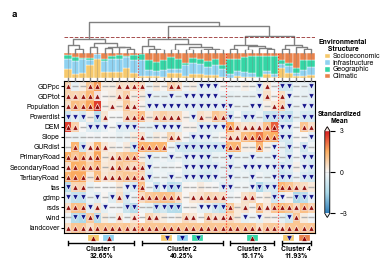

In [23]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from matplotlib.patches import Rectangle, Patch
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D



def create_cluster_patch_label(ax_cluster, center_x, y_pos, cluster_id, manual_patterns, pattern_colors):
    """

    """

    if cluster_id not in manual_patterns:
        return

    cluster_info = manual_patterns[cluster_id]
    num_blocks = len(cluster_info['blocks'])
    if num_blocks < 1:
        return

    # 单个矩形的宽度和高度
    single_width = 15         
    single_height = 0.8        
    gap = 6  

    # 整个组合Patch的宽度和开始坐标
    total_width = num_blocks * single_width + (num_blocks-1)*gap
    patch_start_x = center_x - total_width/2
    patch_start_y = y_pos - single_height/2

    for i, block_info in enumerate(cluster_info['blocks']):
        pattern_name = block_info['pattern']
        arrow_color = block_info['arrow_color']
        arrow_direction = block_info['arrow_direction']

        color = pattern_colors[pattern_name]
        # 计算每个矩形的x起点
        this_rect_start_x = patch_start_x + i * (single_width + gap)
        rect = Rectangle(
            (this_rect_start_x, patch_start_y),
            single_width,
            single_height,
            facecolor=color,
            edgecolor='white',
            linewidth=0.2
        )
        ax_cluster.add_patch(rect)

        # 在Patch正中间稍微向下添加箭头（三角形），使其高度小于Patch
        arrow_x = this_rect_start_x + single_width / 2
        arrow_y = patch_start_y + single_height / 2 - 0.22 * single_height

        arrow_area = single_width * single_height * 1.5  # 经验系数，保证适度
        arrow_size = min(arrow_area, 15)

        if arrow_direction == "up":
            ax_cluster.scatter(
                arrow_x, arrow_y, 
                marker='^', s=arrow_size, c=arrow_color,
                edgecolors='white', zorder=20, linewidths=0.3, alpha=0.95
            )
        elif arrow_direction == "down":
            ax_cluster.scatter(
                arrow_x, arrow_y, 
                marker='v', s=arrow_size, c=arrow_color,
                edgecolors='white', zorder=20, linewidths=0.3, alpha=0.95
            )

    # 在组合Patch下方添加Cluster ID
    # 定义每个Cluster对应的百分比字符串
    # 优化版：显示样本数和百分比（数量参考：3325, 4086, 1540, 1211）
    cluster_percent_info = {
        1: "\n32.65%",
        2: "\n40.25%",
        3: "\n15.17%",
        4: "\n11.93%"
    }
    percent_str = cluster_percent_info.get(cluster_id, "")
    # 显示Cluster ID和百分比
    ax_cluster.text(
        center_x, patch_start_y - 0.3,
        f'Cluster {cluster_id}{percent_str}', 
        ha='center', va='top', fontsize=5, fontweight='bold'
    )


def draw_connectors(fig, ax_ref, ax_top, ax_bottom, centers, color='0.75', lw=0.6, alpha=0.35):
    """
    在 figure 坐标系画竖线，连接 ax_top 的底边 ↔ ax_bottom 的顶边。
    ax_ref: 用来把数据x转换到屏幕坐标的参考轴（和 centers 的坐标系一致，通常是 ax_heatmap）
    centers: 各 component 的数据坐标 x 中心（如 [(i+0.5)*10 for i in range(n)]）
    """
    inv = fig.transFigure.inverted()
    # 两个轴在 figure 中的矩形位置
    y0 = ax_bottom.get_position().y1   # heatmap 顶边
    y1 = ax_top.get_position().y0      # pattern 底边
    for x in centers:
        # 数据坐标 -> 显示坐标 -> Figure 坐标
        x_disp = ax_ref.transData.transform((x, 0))[0]
        x_fig = inv.transform((x_disp, 0))[0]
        line = Line2D([x_fig, x_fig], [y0, y1],
                      transform=fig.transFigure, color="gray", lw=lw, alpha=alpha,
                      zorder=5)  # zorder 可调：大一点在前，小一点在后
        fig.add_artist(line)

def plot_gmm_component_patterns(
    model_path: str = "gmm_model_34c_fixed.pkl",
    save_path: str = None,
):
    """GMM Component-Feature Pattern可视化（优化版 - 等高度模式条+横向图例+聚类边界）"""
    
    # ========== 加载模型 ==========
    gmm_pipeline = joblib.load(model_path)
    gmm: GaussianMixture = gmm_pipeline.named_steps['gmm']
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    
    means = gmm.means_
    weights = gmm.weights_
    covariances = gmm.covariances_
    n_components = gmm.n_components
    
    # ========== 特征处理 ==========
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    n_numeric = len(numeric_features)
    
    if categorical_features:
        landcover_means = means[:, n_numeric:]
        dominant_landcover_values = np.take_along_axis(
            landcover_means, 
            np.argmax(landcover_means, axis=1)[:, np.newaxis], 
            axis=1
        ).squeeze()
        component_features_std = np.column_stack([
            means[:, :n_numeric], 
            dominant_landcover_values[:, np.newaxis]
        ])
        n_landcover_cats = landcover_means.shape[1]
    else:
        component_features_std = means
        landcover_means = None
    
    all_features = numeric_features + categorical_features
    
    # ========== 方差提取 ==========
    if gmm.covariance_type == 'full':
        variances = np.array([np.diag(covariances[k]) for k in range(n_components)])
    elif gmm.covariance_type == 'diag':
        variances = covariances
    else:
        variances = np.ones_like(means)
    
    if categorical_features:
        landcover_variances = variances[:, n_numeric:]
        variances_for_display = np.column_stack([
            variances[:, :n_numeric],
            landcover_variances.mean(axis=1, keepdims=True)
        ])
    else:
        variances_for_display = variances
    
    # ========== 定义模式和颜色（使用Okabe-Ito配色） ==========
    feature_groups = {
        'Socioeconomic': ['Population', 'GDPpc', 'GDPtot', 'GURdist'],
        'Infrastructure': ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
        'Geographic': ['DEM', 'Slope', 'gdmp'],
        'Climatic': ['rsds', 'tas', 'wind'],
    }
    
    # 改为稍微浅一点的颜色，浅20%左右
    pattern_colors = {
        'Socioeconomic': '#f6c96c',  # 浅橙色
        'Infrastructure': '#8fd2f1',  # 浅蓝色
        'Geographic': '#33d6a5',     # 浅绿色
        'Climatic': '#e9834c',       # 浅红棕色
    }
    
    landcover_to_pattern = {
        1: ['Socioeconomic'], 2: ['Geographic'], 3: ['Geographic'],
        4: ['Geographic'], 5: ['Geographic'], 6: ['Climatic'],
        7: ['Socioeconomic', 'Infrastructure'], 8: ['Geographic'], 9: ['Climatic'],
    }
    
    # ========== 计算模式得分并归一化（直接方法） ==========
    def calculate_pattern_weights(comp_idx):
        """计算并返回归一化的模式权重"""
        scores = {name: 0.0 for name in feature_groups.keys()}
        
        # 数值特征贡献
        for pattern_name, features in feature_groups.items():
            indices = [all_features.index(f) for f in features if f in all_features]
            if indices:
                scores[pattern_name] += (
                    np.abs(component_features_std[comp_idx, indices]) * 
                    np.sqrt(variances_for_display[comp_idx, indices]) * 
                    weights[comp_idx]
                ).sum()
        
        # Landcover贡献
        if landcover_means is not None:
            for lc_idx in range(n_landcover_cats):
                lc_class = lc_idx + 1
                if lc_class in landcover_to_pattern:
                    patterns = landcover_to_pattern[lc_class]
                    lc_contrib = (
                        np.abs(landcover_means[comp_idx, lc_idx]) * 
                        np.sqrt(landcover_variances[comp_idx, lc_idx]) * 
                        weights[comp_idx]
                    )
                    for pattern in patterns:
                        if pattern in scores:
                            scores[pattern] += lc_contrib / len(patterns)
        
        # 归一化为权重（总和=1）
        total = sum(scores.values())
        if total > 1e-10:
            weights_dict = {k: v/total for k, v in scores.items()}
        else:
            weights_dict = {k: 0.25 for k in scores.keys()}  # 均分
        
        return weights_dict
    
    # 计算所有components的模式权重
    pattern_weights_list = []
    for k in range(n_components):
        pattern_weights_list.append(calculate_pattern_weights(k))
    
    # ========== 层次聚类 ==========
    distance_matrix = pdist(component_features_std, metric='correlation')
    linkage_matrix = linkage(distance_matrix, method='ward')
    # 获取聚类标签（以distance=1.5为阈值）
    cluster_labels = fcluster(linkage_matrix, t=1.5, criterion='distance')
    # 识别类别边界
    def find_cluster_boundaries(dendro_order, cluster_labels):
        """识别聚类边界点"""
        boundaries = []
        current_cluster = cluster_labels[dendro_order[0]]
        
        for i in range(1, len(dendro_order)):
            if cluster_labels[dendro_order[i]] != current_cluster:
                boundaries.append(i )  # 边界在两个component之间
                current_cluster = cluster_labels[dendro_order[i]]
        
        return boundaries
    
    # ========== 可视化 ==========
    mm_to_inch = 1/25.4
    fig = plt.figure(figsize=(95*mm_to_inch, 65*mm_to_inch))  # 减少高度
    
    plt.rcParams.update({
        'font.size': 6, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })
    
    # 调整布局：移除第4个子图，压缩热力图高度
    gs = gridspec.GridSpec(4, 1, height_ratios=[0.3, 0.25, 1.5, 0.15], hspace=0.05, 
                    left=0.15, right=0.82, top=0.95, bottom=0.05)

    # --- 树状图 ---
    plt.rcParams['lines.linewidth'] = 1
    ax_dendro = fig.add_subplot(gs[0])
    dendro = dendrogram(
        linkage_matrix, 
        ax=ax_dendro, 
        no_labels=True,
        color_threshold=0, 
        above_threshold_color='gray'
    )
    
    # 获取dendro_order和边界
    dendro_order = dendro['leaves']
    boundaries = find_cluster_boundaries(dendro_order, cluster_labels)
    
    # 打印聚类信息
    print("=== 聚类分析结果 ===")
    print(f"聚类数量: {len(set(cluster_labels))}")
    print(f"边界位置: {boundaries}")
    
    # 按聚类分组显示components
    clusters = {}
    for i, comp_idx in enumerate(dendro_order):
        cluster_id = cluster_labels[comp_idx]
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(f'C{comp_idx}')
    
    for cluster_id, components in clusters.items():
        print(f"Cluster {cluster_id}: {components}")

    # 完全移除所有文字和标签
    ax_dendro.set_xticks([])
    ax_dendro.set_yticks([])
    ax_dendro.set_ylabel('')
    ax_dendro.set_xlabel('')
    ax_dendro.set_title('')
    # 仅设置底部ticks可见，但不显示label
    ax_dendro.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    ax_dendro.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
    # 绘制水平参考线
    ax_dendro.axhline(y=1.5, color='#800000', linestyle='--', linewidth=0.7, alpha=0.7)
    
    ax_dendro.grid(False)

    for spine in ['left','bottom', 'top', 'right']:
        ax_dendro.spines[spine].set_visible(False)

    # --- 模式条（等高度版本：所有柱子高度相同，只显示模式比例） ---
    ax_pattern = fig.add_subplot(gs[1], sharex=ax_dendro)

    # 固定顺序（从下到上）
    pattern_order = ['Socioeconomic', 'Infrastructure', 'Geographic', 'Climatic']

    # 固定柱子高度（不依赖GMM权重）
    fixed_height = 1.0

    for i, comp_idx in enumerate(dendro_order):
        pattern_weights = pattern_weights_list[comp_idx]
        
        cumulative_height = 0
        for pattern_name in pattern_order:
            pattern_ratio = pattern_weights[pattern_name]  # 模式内部比例
            if pattern_ratio > 0.001:  # 只绘制比例>0.1%的部分
                color = pattern_colors[pattern_name]
                segment_height = pattern_ratio * fixed_height  # 等高度模式条
                ax_pattern.add_patch(
                    Rectangle((i*10, cumulative_height), 10, segment_height, 
                            facecolor=color, edgecolor='white', linewidth=0.3)
                )
                cumulative_height += segment_height

    # 在模式条中也绘制垂直边界线
    for boundary in boundaries:
        ax_pattern.axvline(x=boundary*10, color='red', linestyle=':', linewidth=0.8, alpha=0.8)


    # 设置y轴范围（等高度）
    ax_pattern.set_xlim(ax_dendro.get_xlim())
    ax_pattern.set_ylim(0, fixed_height)
    ax_pattern.set_xticks([])
    ax_pattern.set_yticks([])
    ax_pattern.set_ylabel('')
    ax_pattern.set_xlabel('')
    ax_pattern.set_title('')
    ax_pattern.tick_params(axis='both', which='both',
                     bottom=True, top=False, left=False, right=False,
                     labelbottom=False, labelleft=False)
    for spine in ax_pattern.spines.values():
        spine.set_visible(False)
    
    # --- 图例放在ax_pattern右侧 ---
    legend_elements = [Patch(facecolor=color, label=pattern, edgecolor="white")
                   for pattern, color in pattern_colors.items()]

    ax_pattern.text(
        1.11, 1.05, "Environmental\n Structure", 
        transform=ax_pattern.transAxes, fontsize=5, fontweight='bold',
        va='bottom', ha='center'
    )
    ax_pattern.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(1.01, 0.5),
        frameon=False,
        fontsize=5,
        handlelength=1,
        handleheight=0.8,
        labelspacing=0.1,              
        ncol=1,                        
        borderaxespad=0.5,
        handletextpad=0.3
    )

    # --- 热力图 ---
    ax_heatmap = fig.add_subplot(gs[2], sharex=ax_dendro)

    heatmap_data = component_features_std[dendro_order, :].T
    extent = [ax_dendro.get_xlim()[0], ax_dendro.get_xlim()[1], len(all_features), 0]

    # 使用新的配色方案和normalization
    cmap = LinearSegmentedColormap.from_list(
        "blueGreyRed",
        ["#2C7BB6", "#ABD9E9", "#F7F7F7", "#FDAE61", "#D7191C"],
        N=256,
    )
    cmap.set_under("#EDF0F2")
    cmap.set_over("#F3E0DB")
    norm = colors.TwoSlopeNorm(vcenter=0.0, vmin=-3.0, vmax=3.0)

    im = ax_heatmap.imshow(heatmap_data, cmap=cmap, norm=norm, aspect='auto', 
                        interpolation='nearest', extent=extent)

    # === 在每个单元格绘制"填充箭头" ===
    x_centers = np.array([(i + 0.5) * 10 for i in range(n_components)])          # (C,)
    y_centers = np.arange(len(all_features)) + 0.5                               # (F,)
    XX, YY = np.meshgrid(x_centers, y_centers)                                   # (F,C)

    vals = heatmap_data                                                           # (F,C)

    # 计算合适的marker大小 - 基于单元格尺寸
    # 获取热力图的实际像素尺寸
    bbox = ax_heatmap.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    ax_w_in, ax_h_in = bbox.width, bbox.height

    # 计算每个单元格的像素尺寸
    cell_w_px = (ax_w_in * fig.dpi) / n_components
    cell_h_px = (ax_h_in * fig.dpi) / len(all_features)

    # 设置marker大小为单元格的60-70%，确保不会重叠
    marker_size = min(cell_w_px * 0.65, cell_h_px * 0.65) ** 2

    # 如果计算出的尺寸太小，设置最小尺寸
    min_marker_size = 4 ** 2  # 最小8像素
    marker_size = min(marker_size, min_marker_size)

    print(f"Cell size: {cell_w_px:.1f} x {cell_h_px:.1f} px")
    print(f"Marker size: {marker_size:.1f} points^2")

    # 正值：深红色箭头（向上）
    # 负值：深蓝色箭头（向下）
    pos_colors = '#8B0000'  # 深红色
    neg_colors = '#000080'  # 深蓝色
    mid_color = '#A9A9A9'   # 灰色 横线

    # 设计阈值
    thr = 0.3  # z-score 绝对值阈值，根据效果可以微调

    vals_flat = vals.ravel()
    xx_flat = XX.ravel()
    yy_flat = YY.ravel()

    # 条件掩码
    pos = (vals_flat > thr)        # 显著为正的格点
    neg = (vals_flat < -thr)       # 显著为负的格点
    mid = (~pos) & (~neg)          # 介于+thr和-thr之间

    # 绘制：向上/向下填充三角
    # 正值：向上箭头（深红色）
    ax_heatmap.scatter(xx_flat[pos], yy_flat[pos],
                       marker='^', s=marker_size, c=pos_colors,
                       edgecolors='white', zorder=10, linewidths=0.5, alpha=0.9)

    # 负值：向下箭头（深蓝色）
    ax_heatmap.scatter(xx_flat[neg], yy_flat[neg],
                       marker='v', s=marker_size, c=neg_colors,
                       edgecolors='white', zorder=10, linewidths=0.5, alpha=0.9)

    # 介于+thr和-thr之间：实体横线（灰色）
    # 横线的marker用 '_' （水平线），注意横线比三角marker视觉上短，适当放大
    line_marker_size = marker_size * 1.5
    ax_heatmap.scatter(xx_flat[mid], yy_flat[mid],
                       marker='_', s=line_marker_size, c=mid_color,
                       edgecolors='white', zorder=10, linewidths=1.0, alpha=0.9)

    # 在热力图中也绘制垂直边界线
    for boundary in boundaries:
        ax_heatmap.axvline(x=boundary*10, color='red', linestyle=':', linewidth=0.8, alpha=0.8)

    x_positions = [(i + 0.5) * 10 for i in range(n_components)]

    # x轴标签（显示主导模式，百分比显示）
    labels = []
    for i in range(n_components):
        comp_idx = dendro_order[i]
        labels.append(f'C{comp_idx}')

    ax_heatmap.set_xticks(x_positions)
    ax_heatmap.set_xticklabels(labels, fontsize=4.5, rotation=90, ha='center')
    ax_heatmap.xaxis.set_ticks_position('top')
    ax_heatmap.xaxis.set_label_position('top')
    ax_heatmap.tick_params(
        axis='x', which='both',
        top=True, bottom=False,     # 只留顶部刻度
        labeltop=True, labelbottom=False,
        length=2, pad=2             # 适当留白
    )
    ax_heatmap.tick_params(axis='x', length=2, pad=1)
    ax_heatmap.tick_params(axis='y', length=2, pad=1)  

    ax_heatmap.set_yticks(np.arange(len(all_features)) + 0.5)
    ax_heatmap.set_yticklabels(all_features, fontsize=5)
    ax_heatmap.grid(False, axis='y')  


    # --- 侧边Colorbar（使用新的风格） ---
    cax = inset_axes(
        ax_heatmap,
        width="2%",             # 宽度较窄
        height="60%",           # 高度为热力图高度一半
        loc="upper right",
        bbox_to_anchor=(0.06, -0.3, 1, 1),  # 轻微下移
        bbox_transform=ax_heatmap.transAxes,
        borderpad=0,
    )
    # 标题单独呈现，放在inset_axes上方
    ax_heatmap.text(
        1.1, 0.72, "Standardized\nMean",
        transform=ax_heatmap.transAxes,
        fontsize=5,
        fontweight='bold',
        ha='center',
        va='bottom',
        rotation=0
    )
    cbar = plt.colorbar(im, cax=cax, orientation="vertical", extend='both')
    cbar.ax.tick_params(labelsize=5, direction="out")
    # -- 优化z-score刻度显示，仅显示 3, 0, -3 --
    cbar.set_ticks([-3, 0, 3])
    cbar.outline.set_linewidth(0.6)

    ax_cluster = fig.add_subplot(gs[3], sharex=ax_dendro)
    cluster_ranges = {}
    for i, comp_idx in enumerate(dendro_order):
        cluster_id = cluster_labels[comp_idx]
        if cluster_id not in cluster_ranges:
            cluster_ranges[cluster_id] = {'start': i, 'end': i}
        else:
            cluster_ranges[cluster_id]['end'] = i

    # 略微缩短每个分组线段，对起止x进行微调
    y_center = 0.5
    line_height = 0.3
    x_offset = 5  # 缩短量

    for cluster_id, range_info in cluster_ranges.items():
        start_x = range_info['start'] * 10 + x_offset
        end_x = (range_info['end'] + 1) * 10 - x_offset
        
        # 水平线段
        ax_cluster.plot([start_x, end_x], [y_center, y_center], 
                        color='black', linewidth=1, solid_capstyle='butt')
        
        # 两端垂直线段
        ax_cluster.plot([start_x, start_x], [y_center - line_height/2, y_center + line_height/2], 
                        color='black', linewidth=1)
        ax_cluster.plot([end_x, end_x], [y_center - line_height/2, y_center + line_height/2], 
                        color='black', linewidth=1)
        
        # 聚类中心标签
        center_x = (start_x + end_x) / 2
        create_cluster_patch_label(ax_cluster, center_x, y_center + 0.5, cluster_id, manual_cluster_patterns, pattern_colors)

    # 设置聚类标记图的属性
    ax_cluster.set_xlim(ax_dendro.get_xlim())
    ax_cluster.set_ylim(0, 1)
    ax_cluster.set_xticks([])
    ax_cluster.set_yticks([])
    ax_cluster.set_ylabel('')
    ax_cluster.set_xlabel('')
    ax_cluster.set_title('')

    # 隐藏所有边框
    for spine in ax_cluster.spines.values():
        spine.set_visible(False)
    

    for i in range(n_components):
        x = (i + 0.5) * 10
        ax = ax_pattern  # 只用这一个
        ax.axvline(x=x, color='gray', lw=0.6, alpha=0.35, zorder=4, clip_on=False)


        # 计算每个 component 的中心 x（与你的代码一致）
    x_centers = [(i + 0.5) * 10 for i in range(n_components)]


    draw_connectors(fig, ax_pattern, ax_dendro, ax_pattern, x_centers, color='0.65', lw=1, alpha=1)
    draw_connectors(fig, ax_heatmap, ax_pattern, ax_heatmap, x_centers, color='0.65', lw=1, alpha=1)


    fig.text(
        0.01, 0.99, 'a',
        fontsize=7,
        fontweight='bold',
        va='top',
        ha='left'
    )

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved: {save_path}")

    
    return fig


# 使用
if __name__ == "__main__":
    fig = plot_gmm_component_patterns(
        model_path="gmm_model_34c_fixed.pkl",
        save_path="figure/US_figure/component_patterns_final.png"
    )
    plt.show()

## 2.2 后验撂荒地环境分布光谱图

In [3]:
df_abandon_filtered

,Unnamed: 0,time,lat,lon,abandonment_year,abandonment_duration,current_abandonment,landcover,DEM,GDPpc,...,Powerdist,PrimaryRoad,SecondaryRoad,Slope,TertiaryRoad,gdmp,rsds,tas,wind,area_m2
0,1897288,2020-01-01,31.320833,-105.929170,2014.0,10.0,1,2.0,1074.1250,19547.0,...,622567.20,22.570979,20.346911,0.161280,109.755022,60.677334,21.335989,2934.915273,2.750262,733498.229916
1,1899788,2020-01-01,31.329166,-105.929170,2014.0,10.0,1,3.0,1074.8125,19547.0,...,622567.20,22.570979,20.346911,0.142680,109.755022,45.031578,21.334290,2934.829175,2.751782,733433.307337
2,1902287,2020-01-01,31.337500,-105.937500,2014.0,10.0,1,3.0,1075.3750,32645.0,...,622567.20,22.570979,20.346911,0.151240,109.755022,38.084999,21.337654,2934.583333,2.752204,733368.361450
3,1902288,2020-01-01,31.337500,-105.929170,2014.0,10.0,1,2.0,1074.9375,32645.0,...,622567.20,22.570979,20.346911,0.134330,109.755022,26.303532,21.336290,2934.584702,2.758872,733368.361450
4,1904787,2020-01-01,31.345833,-105.937500,2014.0,10.0,1,2.0,1075.9375,32645.0,...,622567.20,22.570979,20.346911,0.182301,109.755022,39.406666,21.343910,2934.581940,2.771071,733303.407843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64977,20192249,2020-01-01,46.937500,-67.920830,1998.0,26.0,1,2.0,199.3750,33949.0,...,622564.50,4.273278,14.490743,1.000655,129.836817,74.197998,12.735363,2768.901404,3.429452,586266.096715
64978,20247244,2020-01-01,47.145832,-67.962500,2000.0,24.0,1,2.0,223.0000,33949.0,...,622564.30,32.119901,14.490743,3.852393,92.798418,73.082001,12.262959,2766.375025,3.813229,583981.240638
64979,20271365,2020-01-01,47.237500,-68.620834,2000.0,24.0,1,2.0,181.2500,33949.0,...,622564.00,3.471587,33.915221,1.910013,80.651057,54.858932,12.550031,2768.493367,3.047965,582973.435084
64980,20275797,2020-01-01,47.254166,-68.354164,2000.0,24.0,1,2.0,244.9375,33949.0,...,622564.06,8.030265,0.061349,1.939035,91.262543,74.170227,12.486876,2765.084545,4.128394,582790.047316



我需要绘制撂荒地样本中隶属于各个component的概率。

这需要左（层次聚类属性图、并且按照Cluster聚合后的概率排序）；右（光谱热力图）两个模块构成

层次聚类模块：
1、此处输入数据仍然是gmm_pipeline = joblib.load(model_path)中的训练样本

2、按照各个components的模式权重进行层次聚类，按照distance 1.5 进行划分，记录Cluster1,Cluster2,Cluster3,Cluster4并print dict{}
```
    # 具体可以参考plot_gmm_component_patterns函数中的层次聚类步骤
    # 计算所有components的模式权重
    pattern_weights_list = []
    for k in range(n_components):
        pattern_weights_list.append(calculate_pattern_weights(k))
    
    # ========== 层次聚类 ==========
    distance_matrix = pdist(component_features_std, metric='correlation')
    linkage_matrix = linkage(distance_matrix, method='ward')
```

3、X轴相当于是distance、各个compoent标签放在Y轴（数据框的right）


光谱热力图模块：
1、此处输入数据为df_abandon_filtered

2、利用gmm_pipeline = joblib.load(model_path)的训练参数对其进行评估，并且展现他对各个component的概率$P(z_{k}|x_{i})$

3、横坐标相当于各个撂荒地样本，要求在排序上先按照'lon'（存在负数，需要从西到东，相当于数值上的从小到大，例如-120到-60）；在此基础上按照'lat'交叉排列。
例如（-120，60）应该在（-110，20）的前面

绘制撂荒地样本的Component概率分布

步骤1: 加载GMM模型...
  模型组件数: 34

步骤2: 执行层次聚类...
  聚类数量: 4
  Cluster 4: Components [0, 6, 15, 20, 30]
  Cluster 2: Components [1, 3, 5, 7, 11, 12, 14, 16, 25, 28, 31, 32]
  Cluster 1: Components [2, 4, 8, 10, 18, 21, 22, 23, 27, 33]
  Cluster 3: Components [9, 13, 17, 19, 24, 26, 29]

步骤3: 计算撂荒地样本的component概率...
  撂荒地样本数量: 64,982
  概率矩阵形状: (64982, 34)

步骤4: 按经纬度排序样本...
  排序后lon范围: [-124.37, -67.80]
  排序后lat范围: [25.30, 49.00]

步骤5: 计算各cluster的平均概率...
  各Cluster的平均概率（降序）:
    Cluster 2: 0.4983
    Cluster 3: 0.3966
    Cluster 1: 0.0848
    Cluster 4: 0.0203

步骤6: 创建可视化...

步骤7: 保存图片...
  图片已保存到: figure/US_figure/US_deeplearning/abandon_component_probabilities.png


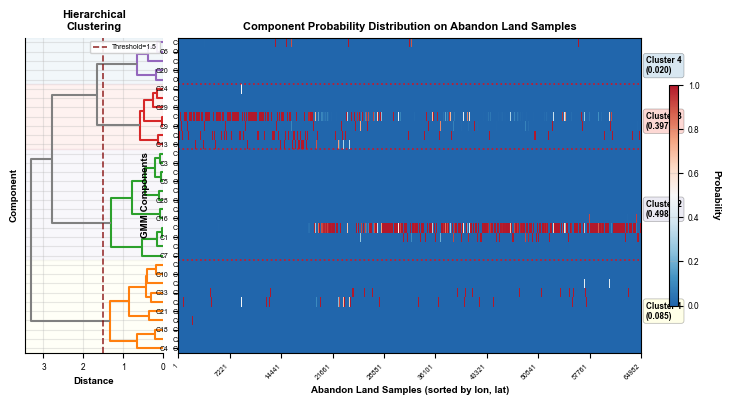


绘制完成！左右Y轴已对齐！

统计信息:
  组件数: 34
  样本数: 64982
  聚类数: 4
  树状图顺序: [4, 2, 18, 8, 21, 23, 33, 27, 10, 22, 7, 31, 1, 14, 16, 25, 28, 32, 5, 11, 3, 12, 13, 26, 9, 19, 29, 17, 24, 0, 20, 30, 6, 15]


In [6]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_abandon_component_probabilities(
    df_abandon_filtered,
    model_path="gmm_model_34c_fixed.pkl",
    features_no_coords=None,
    distance_threshold=1.5,
    save_path="figure/US_figure/US_deeplearning/abandon_component_probabilities.png"
):
    """
    绘制撂荒地样本在各个GMM component上的概率分布（左右对齐版本）
    """
    
    print("=" * 80)
    print("绘制撂荒地样本的Component概率分布")
    print("=" * 80)
    
    # ========== 1. 加载GMM模型 ==========
    print("\n步骤1: 加载GMM模型...")
    gmm_pipeline = joblib.load(model_path)
    gmm = gmm_pipeline.named_steps['gmm']
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    
    means = gmm.means_
    weights = gmm.weights_
    n_components = gmm.n_components
    
    print(f"  模型组件数: {n_components}")
    
    # ========== 2. 层次聚类 ==========
    print("\n步骤2: 执行层次聚类...")
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    n_numeric = len(numeric_features)
    
    if categorical_features:
        landcover_means = means[:, n_numeric:]
        dominant_landcover_values = np.take_along_axis(
            landcover_means, 
            np.argmax(landcover_means, axis=1)[:, np.newaxis], 
            axis=1
        ).squeeze()
        component_features_std = np.column_stack([
            means[:, :n_numeric], 
            dominant_landcover_values[:, np.newaxis]
        ])
    else:
        component_features_std = means
    
    distance_matrix = pdist(component_features_std, metric='correlation')
    linkage_matrix = linkage(distance_matrix, method='ward')
    cluster_labels = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')
    
    print(f"  聚类数量: {len(set(cluster_labels))}")
    clusters_dict = {}
    for comp_idx in range(n_components):
        cluster_id = cluster_labels[comp_idx]
        if cluster_id not in clusters_dict:
            clusters_dict[cluster_id] = []
        clusters_dict[cluster_id].append(comp_idx)
    
    for cluster_id, components in clusters_dict.items():
        print(f"  Cluster {cluster_id}: Components {components}")
    
    # ========== 3. 计算撂荒地样本的component概率 ==========
    print(f"\n步骤3: 计算撂荒地样本的component概率...")
    print(f"  撂荒地样本数量: {len(df_abandon_filtered):,}")
    
    X_abandon = preprocessor.transform(df_abandon_filtered[features_no_coords])
    component_probs = gmm.predict_proba(X_abandon)
    
    print(f"  概率矩阵形状: {component_probs.shape}")
    
    # ========== 4. 按经纬度排序样本 ==========
    print(f"\n步骤4: 按经纬度排序样本...")
    df_sorted = df_abandon_filtered.copy()
    df_sorted['sample_idx'] = range(len(df_sorted))
    df_sorted = df_sorted.sort_values(by=['lon', 'lat'], ascending=[True, True])
    sorted_indices = df_sorted['sample_idx'].values
    
    print(f"  排序后lon范围: [{df_sorted['lon'].min():.2f}, {df_sorted['lon'].max():.2f}]")
    print(f"  排序后lat范围: [{df_sorted['lat'].min():.2f}, {df_sorted['lat'].max():.2f}]")
    
    component_probs_sorted = component_probs[sorted_indices, :]
    
    # ========== 5. 计算各cluster的平均概率 ==========
    print(f"\n步骤5: 计算各cluster的平均概率...")
    
    cluster_avg_probs = {}
    for cluster_id, components in clusters_dict.items():
        cluster_probs = component_probs_sorted[:, components].sum(axis=1).mean()
        cluster_avg_probs[cluster_id] = cluster_probs
    
    sorted_clusters = sorted(cluster_avg_probs.items(), key=lambda x: x[1], reverse=True)
    
    print(f"  各Cluster的平均概率（降序）:")
    for cluster_id, avg_prob in sorted_clusters:
        print(f"    Cluster {cluster_id}: {avg_prob:.4f}")
    
    # ========== 6. 创建可视化 ==========
    print(f"\n步骤6: 创建可视化...")
    
    mm_to_inch = 1/25.4
    fig = plt.figure(figsize=(180*mm_to_inch, 100*mm_to_inch))
    
    plt.rcParams.update({
        'font.size': 7, 
        'axes.titlesize': 8, 
        'axes.labelsize': 7,
        'xtick.labelsize': 6, 
        'ytick.labelsize': 6, 
        'legend.fontsize': 6,
        'font.family': 'Arial'
    })
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[0.3, 1.0], wspace=0.05, 
                          left=0.08, right=0.95, top=0.92, bottom=0.12)
    
    # ========== 6.1 左侧：树状图 ==========
    ax_dendro = fig.add_subplot(gs[0])
    
    dendro = dendrogram(
        linkage_matrix,
        ax=ax_dendro,
        orientation='left',
        no_labels=False,
        color_threshold=distance_threshold,
        above_threshold_color='gray'
    )
    
    # ✅ 获取树状图的叶子顺序（这将用于左右对齐）
    dendro_order = dendro['leaves']
    
    ax_dendro.set_xlabel('Distance', fontsize=7, fontweight='bold')
    ax_dendro.set_ylabel('Component', fontsize=7, fontweight='bold')
    ax_dendro.set_title('Hierarchical\nClustering', fontsize=8, fontweight='bold')
    ax_dendro.axvline(x=distance_threshold, color='#800000', linestyle='--', 
                     linewidth=1.2, alpha=0.8, label=f'Threshold={distance_threshold}')
    ax_dendro.legend(loc='upper right', fontsize=5, framealpha=0.9)
    
    # ✅ Y轴标签按照树状图顺序
    y_positions = np.arange(n_components) * 10 + 5
    ax_dendro.set_yticks(y_positions)
    ax_dendro.set_yticklabels([f'C{comp_idx}' for comp_idx in dendro_order], fontsize=5)
    
    # 添加cluster背景色
    for cluster_id, components in clusters_dict.items():
        positions = [y_positions[dendro_order.index(comp)] for comp in components if comp in dendro_order]
        if positions:
            y_min, y_max = min(positions), max(positions)
            ax_dendro.axhspan(y_min - 5, y_max + 5, alpha=0.1, 
                            color=plt.cm.Set3(cluster_id % 12))
    
    ax_dendro.grid(True, alpha=0.3, axis='x')
    ax_dendro.spines['top'].set_visible(False)
    ax_dendro.spines['right'].set_visible(False)
    
    # ========== 6.2 右侧：热力图（使用相同的dendro_order） ==========
    ax_heatmap = fig.add_subplot(gs[1])

    # ✅ 按照树状图顺序重排概率矩阵
    component_probs_reordered = component_probs_sorted[:, dendro_order]
    heatmap_data = component_probs_reordered.T  # (n_components, n_samples)

    cmap = LinearSegmentedColormap.from_list(
        "prob_cmap",
        ["#2166ac", "#4393c3", "#92c5de", "#d1e5f0", "#f7f7f7", 
        "#fddbc7", "#f4a582", "#d6604d", "#b2182b"],
        N=256
    )

    # ✅ 添加 origin='lower' 让热力图从下到上显示，与树状图方向一致
    im = ax_heatmap.imshow(heatmap_data, aspect='auto', cmap=cmap, 
                        vmin=0, vmax=1, interpolation='nearest', 
                        origin='lower')  # ← 关键修复！

    ax_heatmap.set_xlabel('Abandon Land Samples (sorted by lon, lat)', 
                        fontsize=7, fontweight='bold')
    ax_heatmap.set_ylabel('GMM Components', fontsize=7, fontweight='bold')
    ax_heatmap.set_title('Component Probability Distribution on Abandon Land Samples', 
                        fontsize=8, fontweight='bold')

    # ✅ Y轴标签使用相同的dendro_order
    component_tick_positions = np.arange(n_components)
    ax_heatmap.set_yticks(component_tick_positions[::2])
    ax_heatmap.set_yticklabels([f'C{dendro_order[i]}' for i in component_tick_positions[::2]], 
                            fontsize=5)
    
    # X轴标签
    n_samples_display = min(10, len(df_sorted))
    sample_tick_positions = np.linspace(0, len(df_sorted) - 1, n_samples_display).astype(int)
    ax_heatmap.set_xticks(sample_tick_positions)
    ax_heatmap.set_xticklabels([f'{i+1}' for i in sample_tick_positions], 
                              fontsize=5, rotation=45, ha='right')
    
    for cluster_id, components in clusters_dict.items():
        # 找到该cluster在dendro_order中的位置范围
        positions_in_dendro = [dendro_order.index(comp) for comp in components if comp in dendro_order]
        if positions_in_dendro:
            min_pos = min(positions_in_dendro)
            max_pos = max(positions_in_dendro)
            
            # 只在cluster边界画线（不是第一个cluster）
            if min_pos > 0:
                ax_heatmap.axhline(y=min_pos - 0.5, color='red', 
                                 linestyle=':', linewidth=1.2, alpha=0.8)
    
    # Colorbar
    cax = inset_axes(ax_heatmap, width="2%", height="70%", loc="center right",
                    bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax_heatmap.transAxes,
                    borderpad=0)
    
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('Probability', rotation=270, labelpad=15, fontsize=7, fontweight='bold')
    cbar.ax.tick_params(labelsize=6)
    cbar.outline.set_linewidth(0.8)
    
    # ✅ 添加cluster标注（基于dendro_order中的位置）
    for cluster_id, avg_prob in sorted_clusters:
        components = clusters_dict[cluster_id]
        positions_in_dendro = [dendro_order.index(comp) for comp in components if comp in dendro_order]
        
        if positions_in_dendro:
            y_center = (min(positions_in_dendro) + max(positions_in_dendro)) / 2
            
            ax_heatmap.text(1.01, y_center / n_components, 
                           f'Cluster {cluster_id}\n({avg_prob:.3f})', 
                           transform=ax_heatmap.transAxes,
                           va='center', ha='left', fontsize=6, fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', 
                                   facecolor=plt.cm.Set3(cluster_id % 12), 
                                   alpha=0.3, edgecolor='black', linewidth=0.5))
    
    ax_heatmap.grid(False)
    
    # ========== 7. 保存图片 ==========
    print(f"\n步骤7: 保存图片...")
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"  图片已保存到: {save_path}")
    
    plt.show()
    
    stats = {
        'n_components': n_components,
        'n_samples': len(df_abandon_filtered),
        'n_clusters': len(clusters_dict),
        'clusters_dict': clusters_dict,
        'cluster_avg_probs': cluster_avg_probs,
        'dendro_order': dendro_order,
        'component_probs': component_probs_sorted,
        'sorted_indices': sorted_indices
    }
    
    print(f"\n" + "=" * 80)
    print("绘制完成！左右Y轴已对齐！")
    print("=" * 80)
    
    return fig, stats


# ==================== 运行 ====================
try:
    fig, stats = plot_abandon_component_probabilities(
        df_abandon_filtered=df_abandon_filtered,
        model_path="gmm_model_34c_fixed.pkl",
        features_no_coords=features_no_coords,
        distance_threshold=1.5,
        save_path="figure/US_figure/US_deeplearning/abandon_component_probabilities.png"
    )
    
    print(f"\n统计信息:")
    print(f"  组件数: {stats['n_components']}")
    print(f"  样本数: {stats['n_samples']}")
    print(f"  聚类数: {stats['n_clusters']}")
    print(f"  树状图顺序: {stats['dendro_order']}")
    
except Exception as e:
    print(f"❌ 绘图失败: {e}")
    import traceback
    traceback.print_exc()

## 2.2 PV环境空间分布（六边形聚合）

计算样本的Cluster概率分布

步骤1: 加载GMM模型 gmm_model_34c_fixed.pkl
  模型组件数: 34
  协方差类型: diag

步骤2: 特征标准化
  数值特征: 14
  分类特征: 1

步骤3: 执行层次聚类 (threshold=1.5)
  聚类数量: 4
  Cluster 1: Components [2, 4, 8, 10, 18, 21, 22, 23, 27, 33] (共10个)
  Cluster 2: Components [1, 3, 5, 7, 11, 12, 14, 16, 25, 28, 31, 32] (共12个)
  Cluster 3: Components [9, 13, 17, 19, 24, 26, 29] (共7个)
  Cluster 4: Components [0, 6, 15, 20, 30] (共5个)

步骤4: 计算样本的GMM component概率分布
  样本数量: 10,152
  Component概率矩阵形状: (10152, 34)
  概率总和检查 (应为1.0): 1.000000

步骤5: 聚合component概率到cluster概率
  Cluster概率总和检查:
    均值: 1.000000
    最小值: 1.000000
    最大值: 1.000000

步骤6: 生成结果DataFrame
  新增列:
    - Cluster概率: ['cluster_1_prob', 'cluster_2_prob', 'cluster_3_prob', 'cluster_4_prob']
    - dominant_cluster: 主导cluster ID
    - dominant_cluster_prob: 主导cluster的概率

概率分布统计

Cluster 1:
  均值: 0.3266
  标准差: 0.4680
  中位数: 0.0000
  分位数 [25%, 75%]: [0.0000, 1.0000]
  主导样本数: 3,315 (32.65%)

Cluster 2:
  均值: 0.4022
  标准差: 0.4883
  中位数: 0.0000
  分位数 [25%, 75%]: [0.000

C:\Users\zpy10\AppData\Local\Temp\ipykernel_67028\3847650803.py:255: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_result[cluster_prob_cols].hist(bins=50, ax=ax1, alpha=0.7, edgecolor='black')


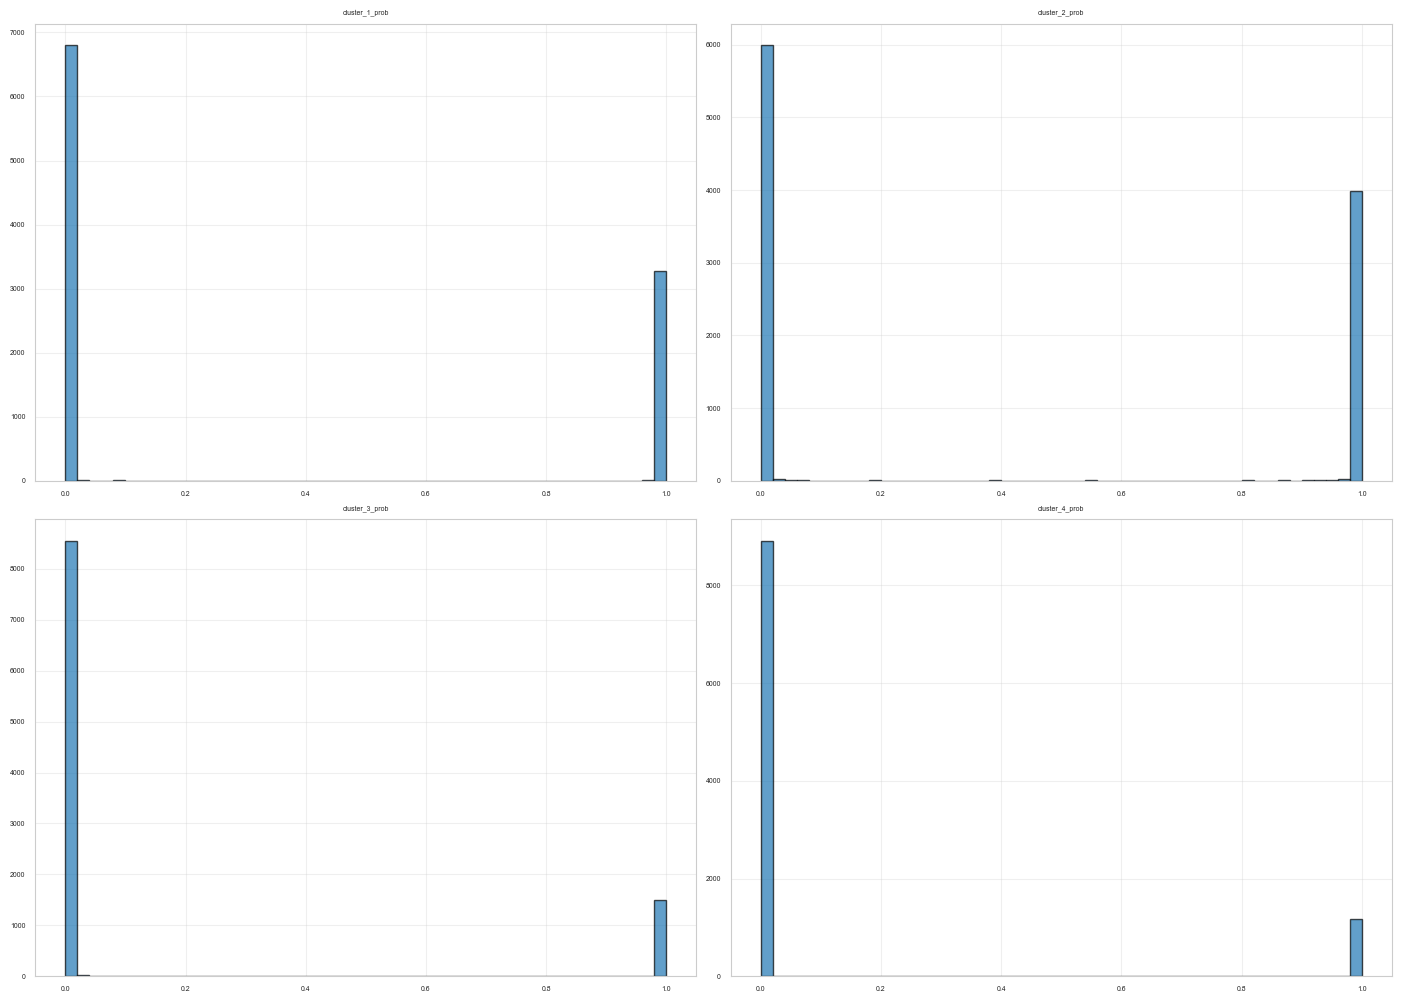

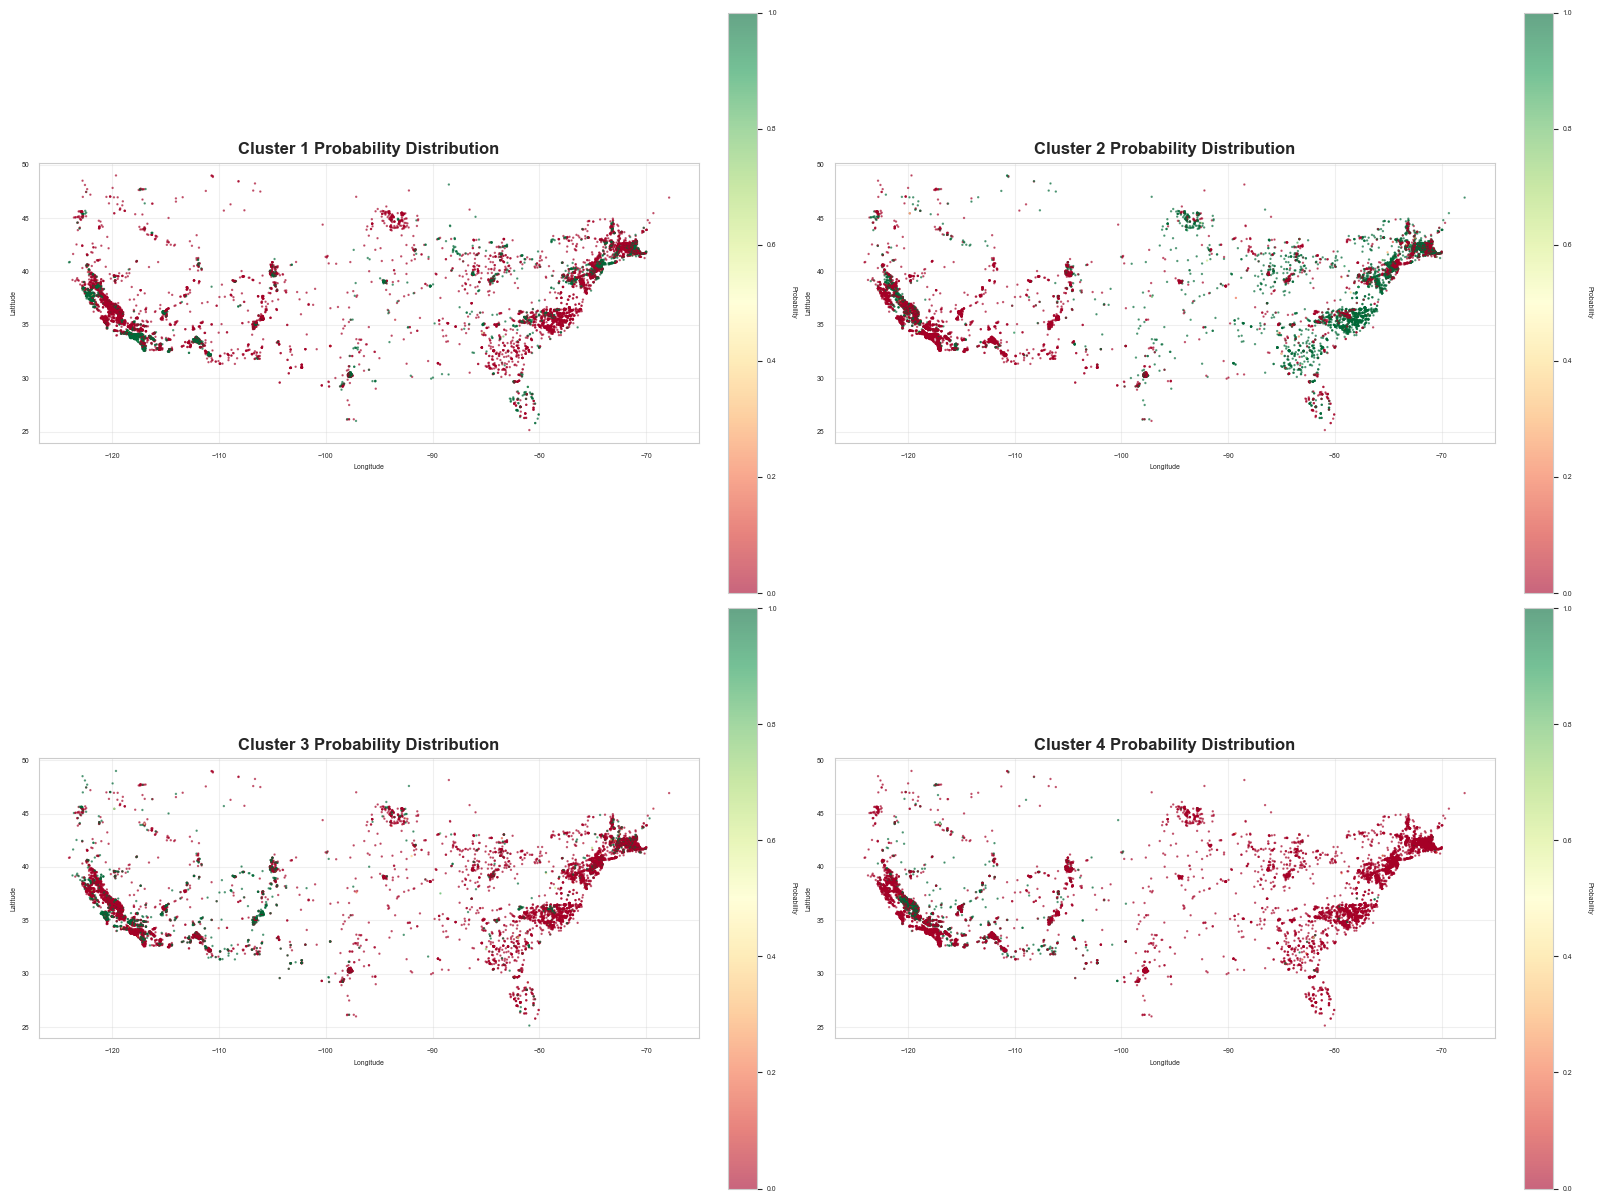


✅ 所有分析和可视化完成！


In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import os

def calculate_cluster_gaussian_parameters(
    model_path="gmm_model_34c_fixed.pkl",
    distance_threshold=1.5,
    target_cluster=1
):
    """计算指定cluster的等效高斯分布参数"""
    
    print(f"计算Cluster {target_cluster}的等效高斯分布参数")
    
    # 加载GMM模型
    gmm_pipeline = joblib.load(model_path)
    gmm = gmm_pipeline.named_steps['gmm']
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    
    means = gmm.means_
    weights = gmm.weights_
    covariances = gmm.covariances_
    
    # 层次聚类
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    n_numeric = len(numeric_features)
    
    if categorical_features:
        landcover_means = means[:, n_numeric:]
        dominant_landcover_values = np.take_along_axis(
            landcover_means, 
            np.argmax(landcover_means, axis=1)[:, np.newaxis], 
            axis=1
        ).squeeze()
        component_features_std = np.column_stack([
            means[:, :n_numeric], 
            dominant_landcover_values[:, np.newaxis]
        ])
    else:
        component_features_std = means
    
    distance_matrix = pdist(component_features_std, metric='correlation')
    linkage_matrix = linkage(distance_matrix, method='ward')
    cluster_labels = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')
    
    # 识别目标cluster的组件
    components_in_cluster = [i for i, cluster_id in enumerate(cluster_labels) if cluster_id == target_cluster]
    
    print(f"Cluster {target_cluster}包含组件: {components_in_cluster}")
    
    if len(components_in_cluster) == 0:
        raise ValueError(f"Cluster {target_cluster}不包含任何组件")
    
    # 计算等效高斯参数
    cluster_means = means[components_in_cluster]
    cluster_weights = weights[components_in_cluster]
    cluster_covariances = covariances[components_in_cluster]
    
    cluster_weights_norm = cluster_weights / cluster_weights.sum()
    
    # 等效均值
    equivalent_mean = np.average(cluster_means, axis=0, weights=cluster_weights_norm)
    
    # 等效协方差矩阵
    if gmm.covariance_type == 'diag':
        equivalent_cov = np.zeros_like(cluster_covariances[0])
        for i, (mean_i, cov_i, weight_i) in enumerate(zip(cluster_means, cluster_covariances, cluster_weights_norm)):
            equivalent_cov += weight_i * cov_i
            mean_diff = mean_i - equivalent_mean
            equivalent_cov += weight_i * (mean_diff ** 2)
    else:
        equivalent_cov = np.zeros_like(cluster_covariances[0])
        for i, (mean_i, cov_i, weight_i) in enumerate(zip(cluster_means, cluster_covariances, cluster_weights_norm)):
            equivalent_cov += weight_i * cov_i
            mean_diff = mean_i - equivalent_mean
            equivalent_cov += weight_i * np.outer(mean_diff, mean_diff)
    
    all_features = numeric_features + categorical_features
    
    return {
        'equivalent_mean': equivalent_mean,
        'equivalent_covariance': equivalent_cov,
        'components_in_cluster': components_in_cluster,
        'cluster_weights': cluster_weights_norm,
        'feature_names': all_features,
        'numeric_features': numeric_features,
        'gmm_covariance_type': gmm.covariance_type
    }


def visualize_cluster_gaussian_distribution(cluster_params, target_cluster=1, save_dir="figure/US_figure/US_deeplearning"):
    """可视化cluster的等效高斯分布"""
    
    os.makedirs(save_dir, exist_ok=True)
    
    equivalent_mean = cluster_params['equivalent_mean']
    equivalent_cov = cluster_params['equivalent_covariance']
    feature_names = cluster_params['feature_names']
    numeric_features = cluster_params['numeric_features']
    
    print(f"可视化Cluster {target_cluster}...")
    
    # 1. 参数表格
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    ax1.axis('tight')
    ax1.axis('off')
    
    table_data = []
    for i, feature in enumerate(feature_names):
        mean_val = equivalent_mean[i]
        if cluster_params['gmm_covariance_type'] == 'diag':
            var_val = equivalent_cov[i]
            std_val = np.sqrt(var_val)
        else:
            var_val = equivalent_cov[i, i]
            std_val = np.sqrt(var_val)
        
        table_data.append([
            feature,
            f"{mean_val:.4f}",
            f"{var_val:.6f}",
            f"{std_val:.4f}"
        ])
    
    table = ax1.table(
        cellText=table_data,
        colLabels=['Feature', 'Mean', 'Variance', 'Std Dev'],
        cellLoc='center',
        loc='center',
        colWidths=[0.4, 0.2, 0.2, 0.2]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    
    # 设置表格样式
    for i in range(len(feature_names) + 1):
        for j in range(4):
            cell = table[(i, j)]
            if i == 0:
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')
    
    ax1.set_title(f'Cluster {target_cluster} Gaussian Parameters', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}/cluster_{target_cluster}_parameters.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. 均值柱状图
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    
    numeric_means = equivalent_mean[:len(numeric_features)]
    bars = ax2.bar(range(len(numeric_features)), numeric_means, 
                  color='steelblue', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Numeric Features')
    ax2.set_ylabel('Mean Value')
    ax2.set_title(f'Cluster {target_cluster} - Feature Means')
    ax2.set_xticks(range(len(numeric_features)))
    ax2.set_xticklabels(numeric_features, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # 添加数值标签
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}/cluster_{target_cluster}_means.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. 2D高斯分布（选择方差最大的两个特征）
    if len(numeric_features) >= 2:
        if cluster_params['gmm_covariance_type'] == 'diag':
            variances = equivalent_cov
        else:
            variances = np.diag(equivalent_cov)
        
        top2_features_idx = np.argsort(variances)[-2:]
        top2_features = [numeric_features[i] for i in top2_features_idx]
        
        fig3, ax3 = plt.subplots(figsize=(10, 8))
        
        x_feature, y_feature = top2_features_idx
        mean_2d = equivalent_mean[[x_feature, y_feature]]
        
        if cluster_params['gmm_covariance_type'] == 'diag':
            cov_2d = np.diag(equivalent_cov[[x_feature, y_feature]])
        else:
            cov_2d = equivalent_cov[np.ix_([x_feature, y_feature], [x_feature, y_feature])]
        
        # 创建网格
        x_range = np.linspace(mean_2d[0] - 3*np.sqrt(cov_2d[0,0]), 
                             mean_2d[0] + 3*np.sqrt(cov_2d[0,0]), 100)
        y_range = np.linspace(mean_2d[1] - 3*np.sqrt(cov_2d[1,1]), 
                             mean_2d[1] + 3*np.sqrt(cov_2d[1,1]), 100)
        X, Y = np.meshgrid(x_range, y_range)
        
        # 计算概率密度
        pos = np.dstack((X, Y))
        rv = multivariate_normal(mean_2d, cov_2d)
        Z = rv.pdf(pos)
        
        # 绘制等高线
        contour = ax3.contour(X, Y, Z, levels=10, colors='blue', alpha=0.6)
        ax3.clabel(contour, inline=True, fontsize=8)
        
        # 标记均值点
        ax3.scatter(mean_2d[0], mean_2d[1], s=200, c='red', marker='*', 
                   edgecolors='black', linewidths=2, zorder=10)
        
        ax3.set_xlabel(top2_features[0], fontsize=12)
        ax3.set_ylabel(top2_features[1], fontsize=12)
        ax3.set_title(f'Cluster {target_cluster} - 2D Gaussian Distribution\n'
                     f'({top2_features[0]} vs {top2_features[1]})', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{save_dir}/cluster_{target_cluster}_2d_gaussian.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    print(f"Cluster {target_cluster}可视化完成！")
    return fig1, fig2, fig3 if len(numeric_features) >= 2 else fig2


# ==================== 主程序 ====================

# 计算Cluster 1和2的等效高斯分布参数
clusters_to_analyze = [1, 2]
all_cluster_params = {}

for cluster_id in clusters_to_analyze:
    print(f"\n{'='*60}")
    print(f"分析Cluster {cluster_id}")
    print(f"{'='*60}")
    
    try:
        cluster_params = calculate_cluster_gaussian_parameters(
            model_path="gmm_model_34c_fixed.pkl",
            distance_threshold=1.5,
            target_cluster=cluster_id
        )
        
        all_cluster_params[cluster_id] = cluster_params
        
        # 可视化
        figs = visualize_cluster_gaussian_distribution(
            cluster_params=cluster_params,
            target_cluster=cluster_id,
            save_dir="figure/US_figure/US_deeplearning"
        )
        
        # 打印关键信息
        print(f"\nCluster {cluster_id} 总结:")
        print(f"  包含的GMM组件: {cluster_params['components_in_cluster']}")
        print(f"  组件权重: {cluster_params['cluster_weights']}")
        print(f"  均值范围: [{cluster_params['equivalent_mean'].min():.3f}, {cluster_params['equivalent_mean'].max():.3f}]")
        
        # 保存参数到JSON
        import json
        params_summary = {
            'cluster_id': cluster_id,
            'components_in_cluster': cluster_params['components_in_cluster'],
            'cluster_weights': cluster_params['cluster_weights'].tolist(),
            'equivalent_mean': cluster_params['equivalent_mean'].tolist(),
            'equivalent_covariance': cluster_params['equivalent_covariance'].tolist(),
            'feature_names': cluster_params['feature_names'],
            'gmm_covariance_type': cluster_params['gmm_covariance_type']
        }
        
        with open(f'figure/US_figure/US_deeplearning/cluster_{cluster_id}_gaussian_parameters.json', 'w') as f:
            json.dump(params_summary, f, indent=2)
        
        print(f"  参数已保存到: cluster_{cluster_id}_gaussian_parameters.json")
        
    except Exception as e:
        print(f"❌ Cluster {cluster_id} 分析失败: {e}")
        continue

print(f"\n{'='*60}")
print("所有分析完成！")
print(f"{'='*60}")
print(f"成功分析的Cluster: {list(all_cluster_params.keys())}")
print(f"所有结果保存在: figure/US_figure/US_deeplearning/")

分析Cluster 1的整体概率分布特征...
分析Cluster 1的整体高斯分布
Cluster 1包含组件: [2, 4, 8, 10, 18, 21, 22, 23, 27, 33]
可视化Cluster 1的整体分布特征...


C:\Users\zpy10\AppData\Local\Temp\ipykernel_76348\1613850764.py:149: RuntimeWarning: divide by zero encountered in divide
  cv = stds / np.abs(equivalent_mean)


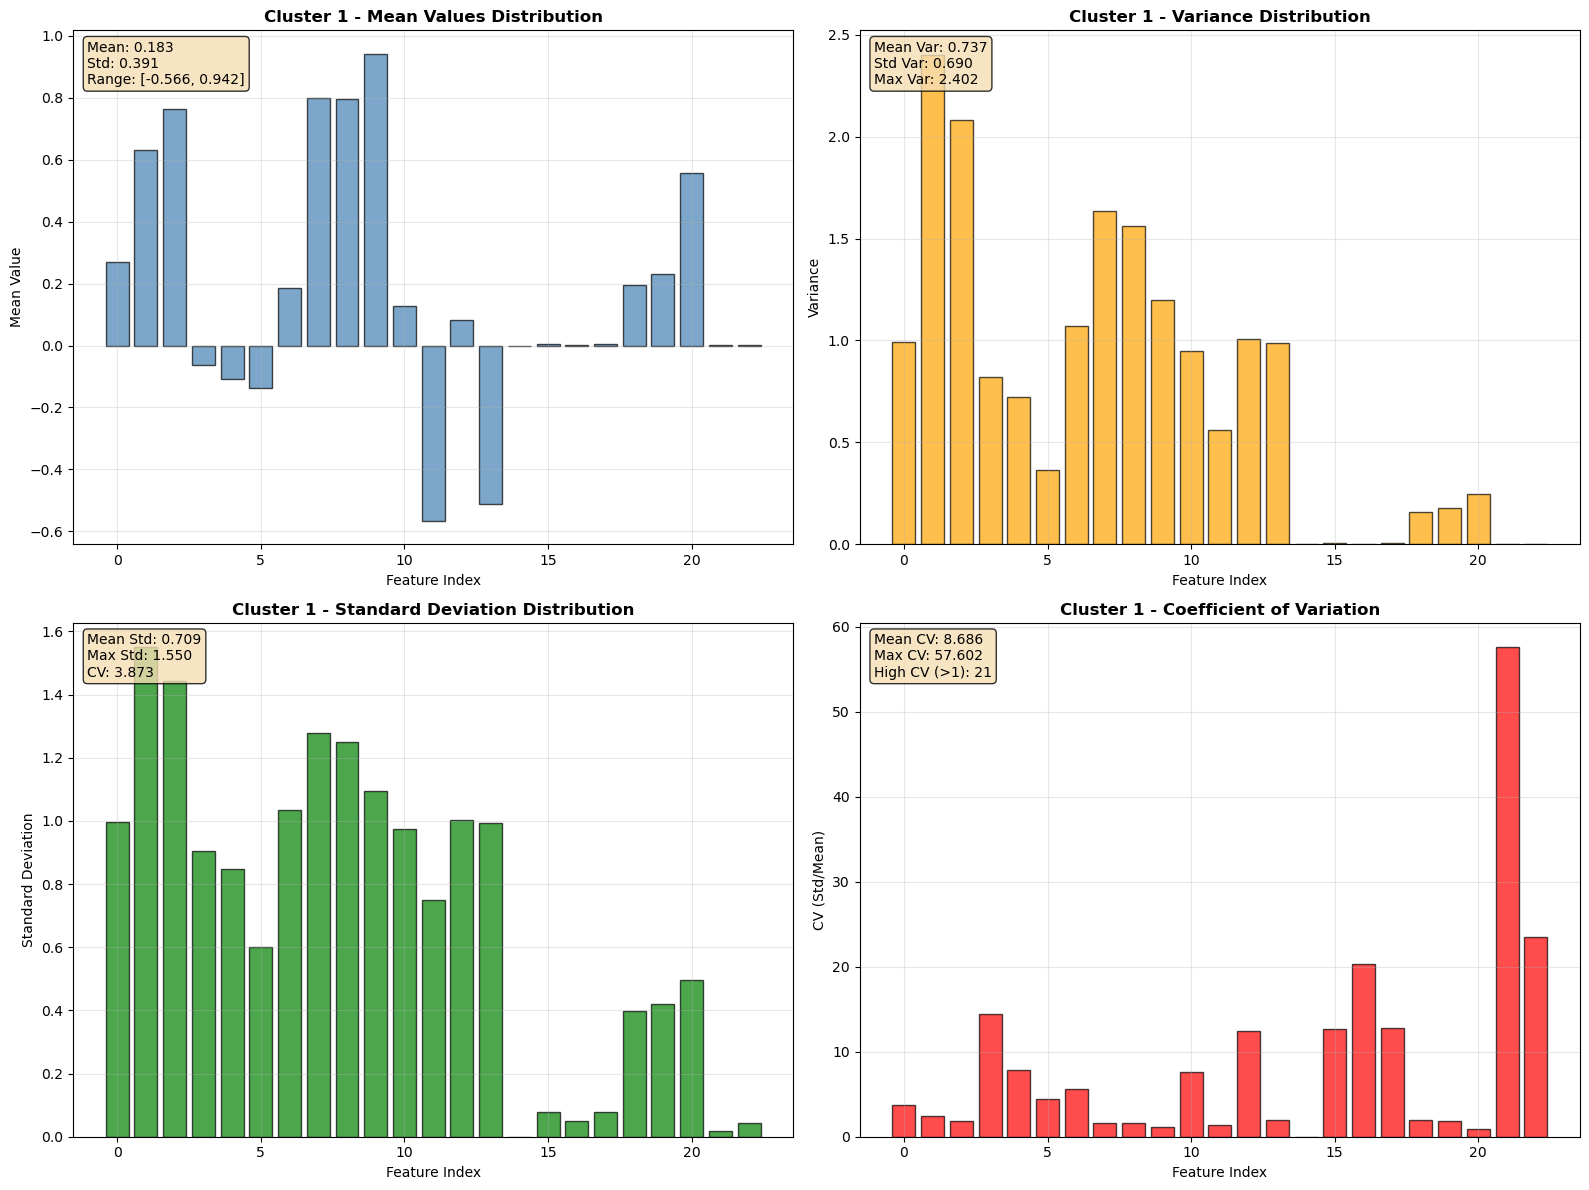

ValueError: cov must be 2 dimensional and square

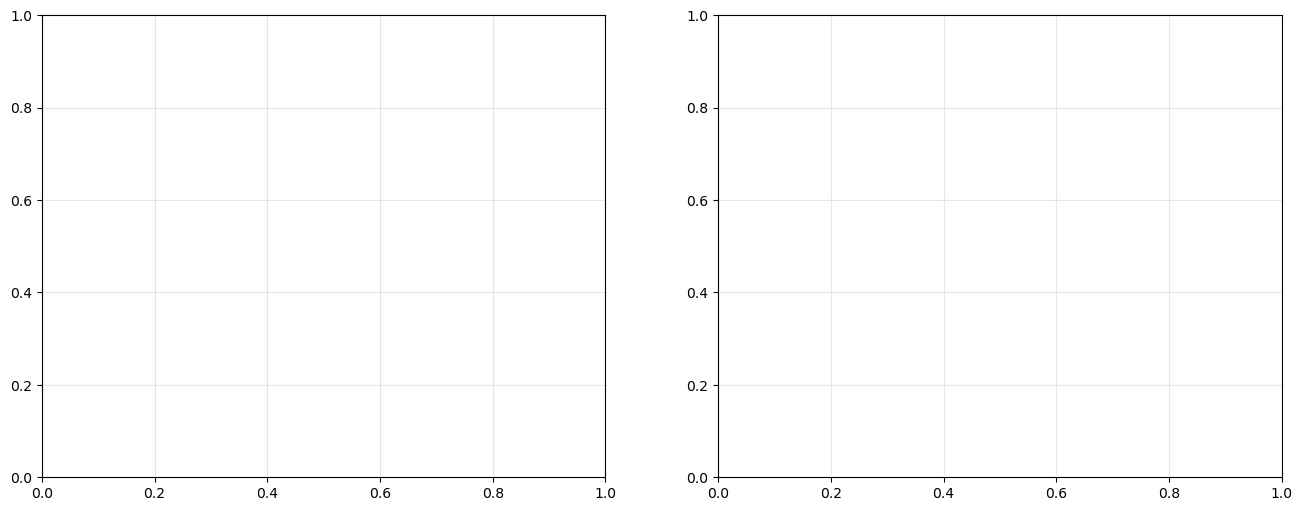

In [8]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import os

def analyze_cluster_gaussian_distribution(
    model_path="gmm_model_34c_fixed.pkl",
    distance_threshold=1.5,
    target_cluster=1
):
    """分析cluster的整体高斯分布特征"""
    
    print(f"分析Cluster {target_cluster}的整体高斯分布")
    
    # 加载GMM模型
    gmm_pipeline = joblib.load(model_path)
    gmm = gmm_pipeline.named_steps['gmm']
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    
    means = gmm.means_
    weights = gmm.weights_
    covariances = gmm.covariances_
    
    # 层次聚类
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    n_numeric = len(numeric_features)
    
    if categorical_features:
        landcover_means = means[:, n_numeric:]
        dominant_landcover_values = np.take_along_axis(
            landcover_means, 
            np.argmax(landcover_means, axis=1)[:, np.newaxis], 
            axis=1
        ).squeeze()
        component_features_std = np.column_stack([
            means[:, :n_numeric], 
            dominant_landcover_values[:, np.newaxis]
        ])
    else:
        component_features_std = means
    
    distance_matrix = pdist(component_features_std, metric='correlation')
    linkage_matrix = linkage(distance_matrix, method='ward')
    cluster_labels = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')
    
    # 识别目标cluster的组件
    components_in_cluster = [i for i, cluster_id in enumerate(cluster_labels) if cluster_id == target_cluster]
    
    print(f"Cluster {target_cluster}包含组件: {components_in_cluster}")
    
    if len(components_in_cluster) == 0:
        raise ValueError(f"Cluster {target_cluster}不包含任何组件")
    
    # 计算等效高斯参数
    cluster_means = means[components_in_cluster]
    cluster_weights = weights[components_in_cluster]
    cluster_covariances = covariances[components_in_cluster]
    
    cluster_weights_norm = cluster_weights / cluster_weights.sum()
    
    # 等效均值
    equivalent_mean = np.average(cluster_means, axis=0, weights=cluster_weights_norm)
    
    # 等效协方差矩阵
    if gmm.covariance_type == 'diag':
        equivalent_cov = np.zeros_like(cluster_covariances[0])
        for i, (mean_i, cov_i, weight_i) in enumerate(zip(cluster_means, cluster_covariances, cluster_weights_norm)):
            equivalent_cov += weight_i * cov_i
            mean_diff = mean_i - equivalent_mean
            equivalent_cov += weight_i * (mean_diff ** 2)
    else:
        equivalent_cov = np.zeros_like(cluster_covariances[0])
        for i, (mean_i, cov_i, weight_i) in enumerate(zip(cluster_means, cluster_covariances, cluster_weights_norm)):
            equivalent_cov += weight_i * cov_i
            mean_diff = mean_i - equivalent_mean
            equivalent_cov += weight_i * np.outer(mean_diff, mean_diff)
    
    return {
        'equivalent_mean': equivalent_mean,
        'equivalent_covariance': equivalent_cov,
        'components_in_cluster': components_in_cluster,
        'cluster_weights': cluster_weights_norm,
        'gmm_covariance_type': gmm.covariance_type,
        'n_features': len(equivalent_mean)
    }


def visualize_cluster_overall_distribution(cluster_params, target_cluster=1, save_dir="figure/US_figure/US_deeplearning"):
    """可视化cluster的整体概率分布特征"""
    
    os.makedirs(save_dir, exist_ok=True)
    
    equivalent_mean = cluster_params['equivalent_mean']
    equivalent_cov = cluster_params['equivalent_covariance']
    n_features = cluster_params['n_features']
    
    print(f"可视化Cluster {target_cluster}的整体分布特征...")
    
    # ========== 1. 整体分布统计摘要 ==========
    fig1, ((ax1a, ax1b), (ax1c, ax1d)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1a. 均值分布
    ax1a.bar(range(n_features), equivalent_mean, color='steelblue', alpha=0.7, edgecolor='black')
    ax1a.set_title(f'Cluster {target_cluster} - Mean Values Distribution', fontweight='bold')
    ax1a.set_xlabel('Feature Index')
    ax1a.set_ylabel('Mean Value')
    ax1a.grid(True, alpha=0.3)
    
    # 添加统计信息
    mean_stats = f"Mean: {equivalent_mean.mean():.3f}\nStd: {equivalent_mean.std():.3f}\nRange: [{equivalent_mean.min():.3f}, {equivalent_mean.max():.3f}]"
    ax1a.text(0.02, 0.98, mean_stats, transform=ax1a.transAxes, 
              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 1b. 方差分布
    if cluster_params['gmm_covariance_type'] == 'diag':
        variances = equivalent_cov
    else:
        variances = np.diag(equivalent_cov)
    
    ax1b.bar(range(n_features), variances, color='orange', alpha=0.7, edgecolor='black')
    ax1b.set_title(f'Cluster {target_cluster} - Variance Distribution', fontweight='bold')
    ax1b.set_xlabel('Feature Index')
    ax1b.set_ylabel('Variance')
    ax1b.grid(True, alpha=0.3)
    
    var_stats = f"Mean Var: {variances.mean():.3f}\nStd Var: {variances.std():.3f}\nMax Var: {variances.max():.3f}"
    ax1b.text(0.02, 0.98, var_stats, transform=ax1b.transAxes, 
              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 1c. 标准差分布
    stds = np.sqrt(variances)
    ax1c.bar(range(n_features), stds, color='green', alpha=0.7, edgecolor='black')
    ax1c.set_title(f'Cluster {target_cluster} - Standard Deviation Distribution', fontweight='bold')
    ax1c.set_xlabel('Feature Index')
    ax1c.set_ylabel('Standard Deviation')
    ax1c.grid(True, alpha=0.3)
    
    std_stats = f"Mean Std: {stds.mean():.3f}\nMax Std: {stds.max():.3f}\nCV: {stds.mean()/abs(equivalent_mean.mean()):.3f}"
    ax1c.text(0.02, 0.98, std_stats, transform=ax1c.transAxes, 
              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 1d. 变异系数分布
    cv = stds / np.abs(equivalent_mean)
    cv = np.where(np.isinf(cv) | np.isnan(cv), 0, cv)  # 处理除零情况
    
    ax1d.bar(range(n_features), cv, color='red', alpha=0.7, edgecolor='black')
    ax1d.set_title(f'Cluster {target_cluster} - Coefficient of Variation', fontweight='bold')
    ax1d.set_xlabel('Feature Index')
    ax1d.set_ylabel('CV (Std/Mean)')
    ax1d.grid(True, alpha=0.3)
    
    cv_stats = f"Mean CV: {cv.mean():.3f}\nMax CV: {cv.max():.3f}\nHigh CV (>1): {(cv > 1).sum()}"
    ax1d.text(0.02, 0.98, cv_stats, transform=ax1d.transAxes, 
              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}/cluster_{target_cluster}_overall_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ========== 2. 概率密度函数特征 ==========
    fig2, (ax2a, ax2b) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 2a. 马氏距离分布（相对于cluster中心）
    # 生成随机样本计算马氏距离
    n_samples = 10000
    random_samples = np.random.multivariate_normal(equivalent_mean, equivalent_cov, n_samples)
    
    # 计算马氏距离
    if cluster_params['gmm_covariance_type'] == 'diag':
        inv_cov = np.diag(1.0 / variances)
    else:
        inv_cov = np.linalg.inv(equivalent_cov)
    
    mahal_distances = []
    for sample in random_samples:
        diff = sample - equivalent_mean
        mahal_dist = np.sqrt(diff.T @ inv_cov @ diff)
        mahal_distances.append(mahal_dist)
    
    mahal_distances = np.array(mahal_distances)
    
    ax2a.hist(mahal_distances, bins=50, density=True, alpha=0.7, color='purple', edgecolor='black')
    ax2a.set_title(f'Cluster {target_cluster} - Mahalanobis Distance Distribution', fontweight='bold')
    ax2a.set_xlabel('Mahalanobis Distance')
    ax2a.set_ylabel('Density')
    ax2a.grid(True, alpha=0.3)
    
    # 添加理论分布（卡方分布）
    from scipy.stats import chi2
    df = n_features  # 自由度
    x_theory = np.linspace(0, mahal_distances.max(), 100)
    y_theory = chi2.pdf(x_theory**2, df) * 2 * x_theory  # 变换到马氏距离
    ax2a.plot(x_theory, y_theory, 'r-', linewidth=2, label=f'χ²({df}) Theory')
    ax2a.legend()
    
    mahal_stats = f"Mean: {mahal_distances.mean():.3f}\nStd: {mahal_distances.std():.3f}\n95%: {np.percentile(mahal_distances, 95):.3f}"
    ax2a.text(0.02, 0.98, mahal_stats, transform=ax2a.transAxes, 
              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 2b. 概率密度值分布
    # 计算每个样本的概率密度
    if cluster_params['gmm_covariance_type'] == 'diag':
        det_cov = np.prod(variances)
    else:
        det_cov = np.linalg.det(equivalent_cov)
    
    # 归一化常数
    norm_const = 1.0 / np.sqrt((2 * np.pi)**n_features * det_cov)
    
    densities = []
    for sample in random_samples:
        diff = sample - equivalent_mean
        if cluster_params['gmm_covariance_type'] == 'diag':
            exp_term = np.exp(-0.5 * np.sum(diff**2 / variances))
        else:
            exp_term = np.exp(-0.5 * diff.T @ inv_cov @ diff)
        density = norm_const * exp_term
        densities.append(density)
    
    densities = np.array(densities)
    
    ax2b.hist(densities, bins=50, density=True, alpha=0.7, color='teal', edgecolor='black')
    ax2b.set_title(f'Cluster {target_cluster} - Probability Density Distribution', fontweight='bold')
    ax2b.set_xlabel('Probability Density')
    ax2b.set_ylabel('Density')
    ax2b.grid(True, alpha=0.3)
    
    density_stats = f"Mean: {densities.mean():.6f}\nMax: {densities.max():.6f}\nStd: {densities.std():.6f}"
    ax2b.text(0.02, 0.98, density_stats, transform=ax2b.transAxes, 
              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}/cluster_{target_cluster}_probability_features.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ========== 3. 分布形状特征 ==========
    fig3, ax3 = plt.subplots(figsize=(12, 8))
    
    # 计算分布的各种形状特征
    features_data = {
        'Mean': equivalent_mean,
        'Variance': variances,
        'Std Dev': stds,
        'CV': cv
    }
    
    # 创建箱线图
    box_data = []
    box_labels = []
    for name, data in features_data.items():
        box_data.append(data)
        box_labels.append(name)
    
    bp = ax3.boxplot(box_data, labels=box_labels, patch_artist=True)
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax3.set_title(f'Cluster {target_cluster} - Distribution Shape Characteristics', fontweight='bold')
    ax3.set_ylabel('Value')
    ax3.grid(True, alpha=0.3)
    
    # 添加统计摘要
    summary_text = f"""Cluster {target_cluster} Distribution Summary:
    
Dimensions: {n_features}
Mean Range: [{equivalent_mean.min():.3f}, {equivalent_mean.max():.3f}]
Variance Range: [{variances.min():.3f}, {variances.max():.3f}]
Overall Spread: {equivalent_mean.std():.3f}
Average Uncertainty: {stds.mean():.3f}
High Variability Features: {(cv > 1).sum()}/{n_features}
"""
    
    ax3.text(1.02, 0.98, summary_text, transform=ax3.transAxes, 
             verticalalignment='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}/cluster_{target_cluster}_shape_characteristics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ========== 打印数值摘要 ==========
    print(f"\n{'='*60}")
    print(f"Cluster {target_cluster} 整体分布特征摘要")
    print(f"{'='*60}")
    print(f"维度数: {n_features}")
    print(f"包含的GMM组件: {cluster_params['components_in_cluster']}")
    print(f"组件权重: {cluster_params['cluster_weights']}")
    print(f"\n均值特征:")
    print(f"  均值范围: [{equivalent_mean.min():.3f}, {equivalent_mean.max():.3f}]")
    print(f"  均值标准差: {equivalent_mean.std():.3f}")
    print(f"  均值变异系数: {equivalent_mean.std()/abs(equivalent_mean.mean()):.3f}")
    print(f"\n方差特征:")
    print(f"  方差范围: [{variances.min():.3f}, {variances.max():.3f}]")
    print(f"  平均方差: {variances.mean():.3f}")
    print(f"  高方差特征数 (>均值): {(variances > variances.mean()).sum()}")
    print(f"\n不确定性特征:")
    print(f"  平均标准差: {stds.mean():.3f}")
    print(f"  最大标准差: {stds.max():.3f}")
    print(f"  高变异性特征 (CV>1): {(cv > 1).sum()}")
    print(f"\n概率密度特征:")
    print(f"  平均概率密度: {densities.mean():.6f}")
    print(f"  最大概率密度: {densities.max():.6f}")
    print(f"  马氏距离95%分位: {np.percentile(mahal_distances, 95):.3f}")
    
    print(f"\n✅ Cluster {target_cluster}整体分布分析完成！")
    print(f"所有图片已保存到: {save_dir}")
    
    return fig1, fig2, fig3


# ==================== 主程序 ====================

# 分析Cluster 1的整体高斯分布
print("分析Cluster 1的整体概率分布特征...")

cluster_1_params = analyze_cluster_gaussian_distribution(
    model_path="gmm_model_34c_fixed.pkl",
    distance_threshold=1.5,
    target_cluster=1
)

# 可视化Cluster 1的整体分布
figs = visualize_cluster_overall_distribution(
    cluster_params=cluster_1_params,
    target_cluster=1,
    save_dir="figure/US_figure/US_deeplearning"
)

# 保存参数摘要
import json
summary = {
    'cluster_id': 1,
    'n_features': cluster_1_params['n_features'],
    'components_in_cluster': cluster_1_params['components_in_cluster'],
    'cluster_weights': cluster_1_params['cluster_weights'].tolist(),
    'mean_range': [float(cluster_1_params['equivalent_mean'].min()), float(cluster_1_params['equivalent_mean'].max())],
    'mean_std': float(cluster_1_params['equivalent_mean'].std()),
    'covariance_type': cluster_1_params['gmm_covariance_type']
}

with open('figure/US_figure/US_deeplearning/cluster_1_overall_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n参数摘要已保存到: cluster_1_overall_summary.json")

## 2.2 边缘分布图

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D



def draw_connectors(fig, ax_ref, ax_top, ax_bottom, centers, color='0.75', lw=0.6, alpha=0.35):
    """
    在 figure 坐标系画竖线，连接 ax_top 的底边 ↔ ax_bottom 的顶边。
    ax_ref: 用来把数据x转换到屏幕坐标的参考轴（和 centers 的坐标系一致，通常是 ax_heatmap）
    centers: 各 component 的数据坐标 x 中心（如 [(i+0.5)*10 for i in range(n)]）
    """
    inv = fig.transFigure.inverted()
    # 两个轴在 figure 中的矩形位置
    y0 = ax_bottom.get_position().y1   # heatmap 顶边
    y1 = ax_top.get_position().y0      # pattern 底边
    for x in centers:
        # 数据坐标 -> 显示坐标 -> Figure 坐标
        x_disp = ax_ref.transData.transform((x, 0))[0]
        x_fig = inv.transform((x_disp, 0))[0]
        line = Line2D([x_fig, x_fig], [y0, y1],
                      transform=fig.transFigure, color=color, lw=lw, alpha=alpha,
                      zorder=5)  # zorder 可调：大一点在前，小一点在后
        fig.add_artist(line)
        
def create_joint_distribution_plot_final(merged_data_for_plot):
    """
    创建最终优化的双变量联合分布图
    新增功能：
    1. 增加边际分布和联合分布之间的空隙
    2. 优化右侧边际分布的刻度标签显示
    """
    
    # 设置字体和风格
    plt.rcParams['font.family'] = 'Arial'
    sns.set_style("whitegrid")
    
    # 数据预处理：剔除negative_sample
    filtered_data = merged_data_for_plot[merged_data_for_plot['sample_type'] != 'negative_sample'].copy()
    
    print(f"原始数据量: {len(merged_data_for_plot)}")
    print(f"过滤后数据量: {len(filtered_data)}")
    
    # 创建图形布局 - 增加空隙
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 4, figure=fig, hspace=0.15, wspace=0.20)  
    
    # 主要的联合分布图
    ax_joint = fig.add_subplot(gs[1:4, 0:3])
    
    # 顶部边际分布（x轴）
    ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_joint)
    
    # 右侧边际分布（y轴）
    ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_joint)
    
    # 隐藏子图的标签
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    
    # 获取原始数据
    original_x_data = filtered_data['gmm_density'].values
    y_data = filtered_data['predicted_prob'].values
    
    # 移除NaN值和非正值（对于对数变换）
    mask = ~(np.isnan(original_x_data) | np.isnan(y_data)) & (original_x_data > 0)
    original_x_data = original_x_data[mask]
    y_data = y_data[mask]
    
    # 对GMM density进行对数变换
    x_data = np.log(original_x_data)  
    
    print(f"有效数据点: {len(x_data)}")
    print(f"GMM density 原始范围: {original_x_data.min():.2e} - {original_x_data.max():.2e}")
    print(f"Log(GMM density) 范围: {x_data.min():.2f} - {x_data.max():.2f}")
    
    # 计算均值和统计信息
    x_mean = np.mean(x_data)
    y_mean = np.mean(y_data)
    correlation = np.corrcoef(x_data, y_data)[0, 1]
    
    # 设置数据范围
    x_range = (np.percentile(x_data, 1), np.percentile(x_data, 99))
    y_range = (np.percentile(y_data, 1), np.percentile(y_data, 99))
    
    # 创建包含对数变换数据的临时DataFrame用于seaborn
    temp_df = pd.DataFrame({
        'log_gmm_density': x_data,
        'predicted_prob': y_data
    })
    
    # 1. 绘制联合分布（只保留KDE密度图，移除散点）
    kde_plot = None
    try:
        kde_plot = sns.kdeplot(data=temp_df, x="log_gmm_density", y="predicted_prob", 
                              cmap="Blues", fill=True, ax=ax_joint, alpha=0.7, zorder=2)
    except Exception as e:
        print(f"KDE绘制警告: {e}")
    
    # 添加颜色条到右上角
    try:
        norm1 = plt.Normalize(vmin=0, vmax=1)
        sm1 = plt.cm.ScalarMappable(cmap="Blues", norm=norm1)
        sm1.set_array([])
        
        # 创建颜色条的插入轴，bbox_to_anchor的第一个参数从0.98改为0.88
        axins1 = inset_axes(ax_joint, width="60%", height="15%",
                           bbox_to_anchor=(0.93, 1.1, 0.4, 0.1), 
                           bbox_transform=ax_joint.transAxes)
        
        cbar = plt.colorbar(sm1, cax=axins1, orientation='horizontal')
        cbar.set_label('Density', fontsize=10, fontweight='bold')
        cbar.ax.tick_params(labelsize=9)
        cbar.outline.set_linewidth(1)
        
    except Exception as e:
        print(f"颜色条绘制警告: {e}")
    
    # 添加回归线（使用指定颜色 #1E88E5）
    r_squared = None
    try:
        from sklearn.linear_model import LinearRegression
        
        # 重塑数据用于回归
        X = x_data.reshape(-1, 1)
        y = y_data
        
        # 线性回归
        reg = LinearRegression()
        reg.fit(X, y)
        r_squared = reg.score(X, y)
        
        # 生成回归线数据
        x_line = np.linspace(x_range[0], x_range[1], 100)
        y_line = reg.predict(x_line.reshape(-1, 1))
        
        ax_joint.plot(x_line, y_line, color='#1E88E5', linewidth=2.5, zorder=3)
        
    except Exception as e:
        print(f"回归线绘制警告: {e}")
    
    # 添加均值线（黑色细虚线）
    ax_joint.axvline(x=x_mean, color='black', linestyle='--', linewidth=1.5, 
                    alpha=0.8, zorder=4)
    ax_joint.axhline(y=y_mean, color='black', linestyle='--', linewidth=1.5, 
                    alpha=0.8, zorder=4)
    
    # 2. 绘制顶部边际分布（使用#E28D8D，bin外框线用黑色细线）
    n_bins_x = 30
    x_bins = np.linspace(x_range[0], x_range[1], n_bins_x + 1)
    
    # 绘制直方图（百分比）
    counts_x, bins_x, patches_x = ax_histx.hist(x_data, bins=x_bins, 
                                               color='#E28D8D', edgecolor='black', 
                                               alpha=0.7, density=False, linewidth=1)
    
    # 转换为百分比
    total_samples = len(x_data)
    percentages_x = (counts_x / total_samples) * 100
    
    # 清除原直方图，重新绘制百分比直方图
    ax_histx.clear()
    bars_x = ax_histx.bar(bins_x[:-1], percentages_x, width=np.diff(bins_x), 
                color='#E28D8D', edgecolor='black', alpha=0.7, align='edge', linewidth=1)
    
    # 添加拟合的分布曲线（#E28D8D深色）
    try:
        from scipy.stats import gaussian_kde
        kde_x = gaussian_kde(x_data)
        x_plot = np.linspace(x_range[0], x_range[1], 200)
        density_x = kde_x(x_plot)
        
        # 将密度转换为百分比尺度
        bin_width = np.diff(bins_x)[0]
        density_x_percent = density_x * bin_width * 100
        
        ax_histx.plot(x_plot, density_x_percent, color='#B05B5B', linewidth=2.5)
    except Exception as e:
        print(f"X轴密度曲线警告: {e}")
    
    # 3. 绘制右侧边际分布（使用#C8E9EF，bin外框线用黑色细线）
    n_bins_y = 35
    y_bins = np.linspace(y_range[0], y_range[1], n_bins_y + 1)
    
    # 绘制直方图（百分比）
    counts_y, bins_y, patches_y = ax_histy.hist(y_data, bins=y_bins,
                                               orientation='horizontal',
                                               color='#C8E9EF', edgecolor='black', 
                                               alpha=0.7, density=False, linewidth=1)
    
    # 转换为百分比
    percentages_y = (counts_y / total_samples) * 100
    
    # 清除原直方图，重新绘制百分比直方图
    ax_histy.clear()
    bars_y = ax_histy.barh(bins_y[:-1], percentages_y, height=np.diff(bins_y), 
                 color='#C8E9EF', edgecolor='black', alpha=0.7, align='edge', linewidth=1)
    
    # 添加拟合的分布曲线（#C8E9EF深色）
    try:
        kde_y = gaussian_kde(y_data)
        y_plot = np.linspace(y_range[0], y_range[1], 200)
        density_y = kde_y(y_plot)
        
        # 将密度转换为百分比尺度
        bin_height = np.diff(bins_y)[0]
        density_y_percent = density_y * bin_height * 100
        
        ax_histy.plot(density_y_percent, y_plot, color='#6CB6C9', linewidth=2.5)
    except Exception as e:
        print(f"Y轴密度曲线警告: {e}")
    
    # 4. 设置坐标轴范围和标签
    ax_joint.set_xlim(x_range)
    ax_joint.set_ylim(y_range)
    
    # 确保边际分布与主图对齐
    ax_histx.set_xlim(ax_joint.get_xlim())
    ax_histy.set_ylim(ax_joint.get_ylim())
    
    # 设置标签
    ax_joint.set_xlabel('Stage 1: Log(GMM Density)', fontsize=12, fontweight='bold')
    ax_joint.set_ylabel('Stage 2: Predicted Probability', fontsize=12, fontweight='bold')
    
    # 设置边际分布标签（现在显示）
    ax_histx.set_ylabel('Percentage (%)', fontsize=10, fontweight='bold')
    ax_histy.set_xlabel('Percentage (%)', fontsize=10, fontweight='bold')
    
    # 重新显示边际分布的刻度标签
    ax_histx.tick_params(axis="y", labelleft=True)
    ax_histy.tick_params(axis="x", labelbottom=True)
    
    # 添加网格
    ax_joint.grid(True, alpha=0.3)
    
    # 设置专业的坐标轴样式
    # 设置刻度线位置
    ax_joint.xaxis.set_ticks_position('bottom')
    ax_joint.yaxis.set_ticks_position('left')
    ax_histx.xaxis.set_ticks_position('bottom')
    ax_histx.yaxis.set_ticks_position('left')
    ax_histy.xaxis.set_ticks_position('bottom')
    ax_histy.yaxis.set_ticks_position('left')

    # 设置刻度线的粗细和颜色（黑色）
    ax_joint.tick_params(axis='both', which='major', width=2, size=6, labelsize=10, color='black')
    ax_histx.tick_params(axis='both', which='major', width=2, size=6, labelsize=10, color='black')
    ax_histy.tick_params(axis='both', which='major', width=2, size=6, labelsize=10, color='black')

    # 设置坐标轴线的颜色和粗细（黑色）
    for spine in ax_joint.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')
    for spine in ax_histx.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')
    for spine in ax_histy.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')

    # 移除边际图上侧和右侧的坐标轴
    ax_histx.spines['top'].set_visible(False)
    ax_histx.spines['right'].set_visible(False)
    ax_histy.spines['top'].set_visible(False)
    ax_histy.spines['right'].set_visible(False)

    # 设置顶部边际分布（X轴）的Y轴刻度
    import matplotlib.ticker as mticker
    max_percent_x = percentages_x.max()
    if max_percent_x <= 10:
        x_tick_step = 2  # 0, 2, 4, 6, 8, 10
    else:
        x_tick_step = max(2, int(max_percent_x // 5) * 2)  # 保持偶数步长
    
    x_ticks = list(range(0, int(max_percent_x) + x_tick_step, x_tick_step))
    ax_histx.set_yticks(x_ticks)
    ax_histx.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))

    # 设置右侧边际分布（Y轴）的X轴刻度 - 类似顶端显示：0, 2, 4, 6, 8
    max_percent_y = percentages_y.max()
    if max_percent_y <= 10:
        y_tick_step = 2  # 0, 2, 4, 6, 8, 10
    else:
        y_tick_step = max(2, int(max_percent_y // 5) * 2)  # 保持偶数步长
    
    y_ticks = list(range(0, int(max_percent_y) + y_tick_step, y_tick_step))
    ax_histy.set_xticks(y_ticks)
    ax_histy.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
    
    # 调整边际分布的Y轴范围，给标签留出空间
    ax_histx.set_ylim(0, max_percent_x * 1.1)  # 增加10%的空间
    ax_histy.set_xlim(0, max_percent_y * 1.1)  # 增加10%的空间

    # 整合统计信息到一个框中
    stats_text = f'Correlation: {correlation:.3f}'
    if r_squared is not None:
        stats_text += f'\nR²: {r_squared:.3f}'
    stats_text += f'\nMean X: {x_mean:.1f}'
    stats_text += f'\nMean Y: {y_mean:.3f}'

    ax_joint.text(0.05, 0.95, stats_text, 
                 transform=ax_joint.transAxes, fontsize=11, 
                 verticalalignment='top',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor="white", 
                          alpha=0.9, edgecolor='none', linewidth=0))
    
    plt.tight_layout()
    return fig, (ax_joint, ax_histx, ax_histy)

# 使用最终优化的函数
try:
    fig, axes = create_joint_distribution_plot_final(merged_data_for_plot)
    
    # 保存图片
    fig.savefig("figure/US_figure/joint_distribution_final.png", 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("最终优化的联合分布图生成完成！")
    
except Exception as e:
    print(f"绘图过程中出现错误: {e}")
    import traceback
    traceback.print_exc()

原始数据量: 64982
过滤后数据量: 62444
有效数据点: 62444
GMM density 原始范围: 6.91e-32 - 1.37e+28
Log(GMM density) 范围: -71.75 - 64.79


# 三、碳汇结论图

逻辑：

裁剪保护区的shp、绘制高碳汇潜力碳汇区

预处理模式，对于栅格类数据，应该重点参照DEM

计算逻辑：
（1）对于protected_area_us，标记merged_data_for_plot的net_npv_usd，if pixel by 'lat'lon' in merged_data_for_plot == 'protected_area_us==1' 
（2）对于carbon_potential_us，标记计算merged_data_for_plot的net_npv_usd, if each pixel 'lat''lon' in merged_data_for_plot == 'carbon_potential_us >= '50%分位数'）

参与数据：
1、四类碳整合的Potential的.nc数据
2、保护区的shp

### 3.0 Load data 

In [22]:
import xarray as xr
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy as np
protected_area_ds = xr.open_dataset(r'figure\draw_shp\protected_areas.nc')
carbon_potential_ds = xr.open_dataset(r'figure\draw_shp\Base_Pot_AGB_BGB_SOC_MgCha_500m.nc')
dem = rioxarray.open_rasterio(r'figure\draw_shp\DEM.nc', masked=True)
protected_area = protected_area_ds['protected_area']
carbon_potential = carbon_potential_ds['Base_Pot_AGB_BGB_SOC_MgCha_500m']



# load administrative boundaries and transform to 4326
us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')
us_argscv = gpd.read_file("figure/draw_shp/ASD_2012_5m.shp")


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')
us_argscv_4326 = us_argscv.to_crs('EPSG:4326')



# CRS（如果缺失）
dem = dem.rio.write_crs("EPSG:4326")
protected_area = protected_area.rio.write_crs("EPSG:4326")
carbon_potential = carbon_potential.rio.write_crs("EPSG:4326")
protected_area = protected_area.rename({'lon': 'x', 'lat': 'y'})
carbon_potential = carbon_potential.rename({'lon': 'x', 'lat': 'y'})

protected_area = protected_area.rio.set_spatial_dims(x_dim='x', y_dim='y')
carbon_potential = carbon_potential.rio.set_spatial_dims(x_dim='x', y_dim='y')


# 将布尔数据转换为整数类型，避免裁剪产生的填充问题
protected_area_int = protected_area.astype('int8')

# check CRS 
if us_nation.crs != dem.rio.crs:
    print(f"转换US nation CRS从 {us_nation.crs} 到 {dem.rio.crs}")
    us_nation = us_nation.to_crs(dem.rio.crs)

# 4. 用us_nation精确裁剪DEM
dem_us = dem.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)
protected_area_us = protected_area_int.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)  
carbon_potential_us = carbon_potential.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)





转换US nation CRS从 EPSG:4269 到 EPSG:4326


c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:230: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


#### 3.0.1 分析数据处理

In [23]:
import numpy as np
import pandas as pd

df_analysis=pd.read_csv(r'data\US_data\df_merged_data_for_analysis.csv')
df_weight = pd.read_csv('data/US_data/df_weight.csv')



emission_intensity = pd.DataFrame({
    'year': ['2018',  '2030', '2035', '2040'],
    'CO2_g_per_kWh': [400.3,  302,  279.2, 261.1]
})
# Transform pv_transform (2020 emission factor) to 2030, 2040, 2050 using emission_intensity
pv_transform_2020 = 352  
# Interpolate emission intensity for 2020, 2030, 2040, 2050
years_target = [2020, 2030, 2040, 2050]
em_factors = np.interp(
    years_target,
    emission_intensity['year'].astype(int),
    emission_intensity['CO2_g_per_kWh']
)

# Calculate scaling factors relative to 2020
scaling_factors = em_factors / em_factors[0]

# 生成一个pv_transfer的dataframe
pv_transfer = pd.DataFrame({
    'year': [2020, 2030, 2040, 2050],
    'pv_transform': [pv_transform_2020] + list(pv_transform_2020 * scaling_factors[1:])
})

# 计算每10年区间的累计光伏转化能力，并最终汇总到2050
years = [2020, 2030, 2040, 2050]

for idx in range(len(years)-1):
    y_start, y_end = years[idx], years[idx+1]
    pv_start = pv_transfer.loc[pv_transfer['year'] == y_start, 'pv_transform'].values[0]
    pv_end = pv_transfer.loc[pv_transfer['year'] == y_end, 'pv_transform'].values[0]
    # 线性插值每年pv_transform，累计10年
    pv_sum = 0
    for y in range(y_start, y_end):
        pv_y = pv_start + (pv_end - pv_start) * (y - y_start) / (y_end - y_start)
        pv_sum += df_analysis['E_yr_pixel'] * pv_y / 1000 / 1000 * 0.27 / (df_analysis['area_m2'] / 10000)
    df_analysis[f'pv_potential_{y_start}_{y_end-1}_sum'] = pv_sum

# 汇总2020-2050累计值，汇总site的累计光伏减排能力(t C)
df_analysis['pv_potential_total(t)'] = sum(
    df_analysis[f'pv_potential_{years[i]}_{years[i+1]-1}_sum'] for i in range(len(years)-1)
)

df_analysis['power_generation_kwha'] = df_analysis['E_yr_pixel'] * 30 / df_analysis['area_m2'] * 10000
# emission_data = df_analysis[['lat', 'lon', 'Expectation_net_benefit_adjust','LNCS_expect','power_generation_kwha', 'area_m2']].copy()


In [24]:
df_analysis

,lat,lon,predicted_prob,gmm_density,sample_type,Expectation_net_benefit,pv_potential_dens,LNCS_expect,net_npv_usd,area_m2,E_yr_pixel,pv_potential_total(t),power_generation_kwha,Expectation_net_benefit_adjust,ccd_optimized,pv_potential_2020_2029_sum,pv_potential_2030_2039_sum,pv_potential_2040_2049_sum
0,25.295834,-80.287500,0.000000,3.874315e+16,negative_sample,6382.303639,7191.865919,809.562299,407275.912577,776295.361002,1.958127e+08,5568.344207,7.567199e+07,4758.781908,0.813290,2167.108342,1770.850632,1630.385232
1,25.437500,-80.537500,0.046746,2.054387e+18,prediction,5690.624063,7035.368191,1344.744161,283953.326746,775385.854124,1.913273e+08,5447.174926,7.402534e+07,4102.430766,0.755979,2119.951244,1732.316251,1594.907432
2,25.437500,-80.495834,0.000000,4.247702e+15,negative_sample,6055.300591,7024.124059,968.823440,275019.106094,775385.854124,1.910215e+08,5438.469092,7.390703e+07,4469.645652,0.785107,2116.563075,1729.547612,1592.358404
3,25.445833,-80.454170,0.000000,1.117299e+13,negative_sample,6048.645138,7017.640780,968.995616,269947.631894,775332.207938,1.908320e+08,5433.449375,7.383881e+07,4464.453759,0.783940,2114.609484,1727.951237,1590.888654
4,25.445833,-80.404170,0.017465,4.463459e+17,prediction,6081.010322,7045.490473,964.480123,291620.314126,775332.207938,1.915894e+08,5455.012162,7.413184e+07,4490.532039,0.790277,2123.001367,1734.808657,1597.202138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64977,48.995834,-111.970830,0.026153,1.493778e+17,prediction,6210.923349,6392.674772,181.751426,-220868.055076,563356.382622,1.263101e+08,4949.565792,6.726299e+07,4767.814366,0.653804,1926.289920,1574.066075,1449.209796
64978,48.995834,-110.345830,0.068266,4.120084e+17,prediction,6206.053157,6395.853979,189.800818,-219393.096487,563356.382622,1.263729e+08,4952.027311,6.729644e+07,4762.226494,0.653879,1927.247903,1574.848890,1449.930518
64979,48.995834,-106.020836,0.065097,3.232082e+17,prediction,6204.952188,6412.037900,207.085706,-205704.827949,563356.382622,1.266927e+08,4964.557807,6.746673e+07,4757.472100,0.650767,1932.124567,1578.833851,1453.599388
64980,48.995834,-104.087500,0.109234,6.627032e+21,prediction,6077.421747,6292.888713,215.466966,-300314.323514,563356.382622,1.243385e+08,4872.305853,6.621305e+07,4656.838886,0.611981,1896.221618,1549.495789,1426.588446


In [25]:
emission_data = df_analysis[['lat', 'lon', 'Expectation_net_benefit_adjust','LNCS_expect',
                            'area_m2', 'pv_potential_total(t)', 'power_generation_kwha',
                            'pv_potential_2020_2029_sum', 'pv_potential_2030_2039_sum','pv_potential_2040_2049_sum'
                           ]].copy()
variable_weight=['weighted_density_Agricultural','weighted_density_Forest','weighted_density_Vegetation']
emission_data_merge = emission_data.rename(columns={'Expectation_net_benefit_adjust': 'Expectation_net_benefit'})
variable_lncs = ['final_forest', 'final_agro', 'final_veg']
lncs_data = df_weight[['lat', 'lon'] + variable_lncs + variable_weight]
emission_data_merge = emission_data_merge.merge(lncs_data, on=['lat', 'lon'], how='left')

emission_data_merge

,lat,lon,Expectation_net_benefit,LNCS_expect,area_m2,pv_potential_total(t),power_generation_kwha,pv_potential_2020_2029_sum,pv_potential_2030_2039_sum,pv_potential_2040_2049_sum,final_forest,final_agro,final_veg,weighted_density_Agricultural,weighted_density_Forest,weighted_density_Vegetation
0,25.295834,-80.287500,4758.781908,809.562299,776295.361002,5568.344207,7.567199e+07,2167.108342,1770.850632,1630.385232,809.5685,764.000000,821.04486,0.000367,0.998714,0.000918
1,25.437500,-80.537500,4102.430766,1344.744161,775385.854124,5447.174926,7.402534e+07,2119.951244,1732.316251,1594.907432,1389.7133,1102.152466,1126.51390,0.007830,0.829869,0.162302
2,25.437500,-80.495834,4469.645652,968.823440,775385.854124,5438.469092,7.390703e+07,2116.563075,1729.547612,1592.358404,1026.1462,750.145691,778.08900,0.022229,0.771417,0.206354
3,25.445833,-80.454170,4464.453759,968.995616,775332.207938,5433.449375,7.383881e+07,2114.609484,1727.951237,1590.888654,1026.1462,756.315613,777.34060,0.007369,0.770923,0.221708
4,25.445833,-80.404170,4490.532039,964.480123,775332.207938,5455.012162,7.413184e+07,2123.001367,1734.808657,1597.202138,1051.1307,728.004333,758.56060,0.099801,0.714253,0.185946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64977,48.995834,-111.970830,4767.814366,181.751426,563356.382622,4949.565792,6.726299e+07,1926.289920,1574.066075,1449.209796,182.2000,170.484009,174.20488,0.017433,0.952007,0.030560
64978,48.995834,-110.345830,4762.226494,189.800818,563356.382622,4952.027311,6.729644e+07,1927.247903,1574.848890,1449.930518,198.1000,175.665878,177.52232,0.332696,0.626705,0.040599
64979,48.995834,-106.020836,4757.472100,207.085706,563356.382622,4964.557807,6.746673e+07,1932.124567,1578.833851,1453.599388,207.1000,206.000000,207.00000,0.003256,0.889626,0.107118
64980,48.995834,-104.087500,4656.838886,215.466966,563356.382622,4872.305853,6.621305e+07,1896.221618,1549.495789,1426.588446,225.2000,204.508926,207.61511,0.057912,0.456741,0.485347


In [26]:
from matplotlib import pyplot as plt
from function import *
from function.global_varibles import *
import glob
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np



df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_weight = pd.read_csv('data/US_data/df_weight.csv')
df_strategies = pd.read_csv('data/US_data/df_strategies.csv')
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')
df_pv_npv = pd.read_csv('data/US_data/df_pv_npv.csv')
df_agricultural_npv = pd.read_csv('data/US_data/df_agricultural_npv.csv')
df_afforestation_npv = pd.read_csv('data/US_data/df_afforestation_npv.csv')
df_natural_npv = pd.read_csv('data/US_data/df_natural_npv.csv')
df_gmm_scores = pd.read_csv('data/US_data/df_gmm_scores.csv')
df_pixel_optimized_data = pd.read_csv('data/US_data/df_pixel_optimized_data.csv')



# 环境维度的变量
env_data = df_weight[['lat', 'lon', 'predicted_prob','gmm_density','sample_type']].copy()

# 碳减排维度的变量
emission_data = df_weight[['lat', 'lon', 'Expectation_net_benefit']].copy()

# 经济维度的变量
economic_2050 = df_economic[df_economic['analysis_year'] == 2050]
avg_npv = economic_2050.groupby(['lat', 'lon'])['net_npv_usd'].mean().reset_index()

# 合并所有变量
merged_data_for_plot = env_data.merge(emission_data, on=['lat', 'lon'], how='outer') \
                      .merge(avg_npv, on=['lat', 'lon'], how='outer')










## 3.1 图1：LNCS与减排双变量图

In [27]:
def _setup_axes_and_graticule_for_bi(ax, usa_bounds_main, proj_fwd, proj_inv):
    """设置坐标轴和经纬度网格"""
    # 设置数据框线为灰色
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_color('#cccccc')  

    # 经纬度刻度 - 
    lon_ticks = np.arange(-125, -55, 10) 
    lat_ticks = [25, 30, 35, 40, 45, 50]
    
    # 绘制网格线和设置刻度
    _draw_graticule_for_bi(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)

def _draw_graticule_for_bi(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线 - 修改逻辑，只绘制与下框线有交点的经度线
    xticks, xlabels = [], []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 只检查下框线交点，如果下框线没有交点就不绘制
        p = _choose_point_on_edge(line.intersection(bottom))
        if p is not None:
            # 检查与已有标签的最小距离
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                xlabels.append(f"{abs(int(round(lon)))}°W")

        # 只绘制与下框线有交点的经度线
        if p is not None:
            ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

    # 纬度刻度和网格线
    yticks, ylabels = [], []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        p = _choose_point_on_edge(line.intersection(left))
        if p is None:
            p = _choose_point_on_edge(line.intersection(right))
        if p is not None:
            yticks.append(p.y)
            ylabels.append(f"{int(round(lat))}°N")

        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

    # 设置刻度
    order = np.argsort(xticks)
    ax.xaxis.set_major_locator(mticker.FixedLocator([xticks[i] for i in order]))
    ax.xaxis.set_major_formatter(mticker.FixedFormatter([xlabels[i] for i in order]))

    order = np.argsort(yticks)
    ax.yaxis.set_major_locator(mticker.FixedLocator([yticks[i] for i in order]))
    ax.yaxis.set_major_formatter(mticker.FixedFormatter([ylabels[i] for i in order]))

    ax.tick_params(axis='both', labelsize=5, pad=1)
    for label in ax.get_yticklabels():
        label.set_rotation(90)


def _draw_background_map_for_bi(ax, usa_bounds_main):
    """绘制背景地图"""
    try:
        bbox_expanded = box(
            usa_bounds_main['lon_min'] - 4, usa_bounds_main['lat_min'] - 20,
            usa_bounds_main['lon_max'] + 4, usa_bounds_main['lat_max'] + 10
        )
        helper_gdf = gpd.read_file(r'figure\draw_shp\ne_110m_land.shp').to_crs(4326)
        helper_gdf = helper_gdf.clip(bbox_expanded)
        
        if 'featurecla' in helper_gdf.columns:
            helper_gdf = helper_gdf[helper_gdf['featurecla'].str.contains('Land', na=False)]
        
        if make_valid is not None:
            helper_gdf['geometry'] = helper_gdf.geometry.map(make_valid)
        else:
            helper_gdf['geometry'] = helper_gdf.geometry.buffer(0)
            
        helper_gdf = helper_gdf[helper_gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])]
        helper_gdf = helper_gdf.explode(index_parts=False, ignore_index=True)
        helper_gdf_proj = helper_gdf.to_crs('ESRI:102003')
        helper_gdf_proj['geometry'] = helper_gdf_proj.buffer(0)
        helper_gdf_proj.plot(ax=ax, facecolor='white', edgecolor='lightgray',
                           linewidth=0.3, alpha=1, zorder=0.5)
    except Exception as e:
        print(f"Helper map error: {e}")

生成双变量地图时出错: name '_render_terrain' is not defined


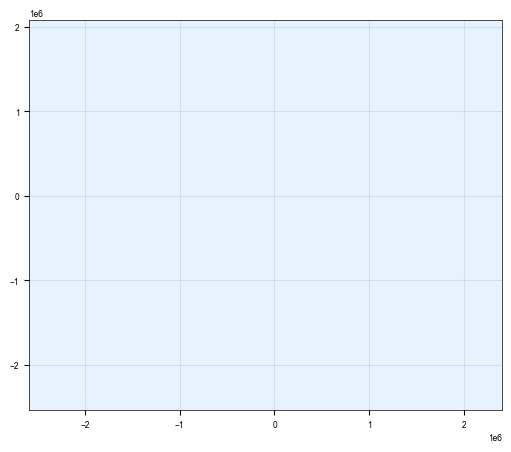

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box, LineString
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.ops import unary_union
try:
    from shapely import make_valid
except Exception:
    make_valid = None
import matplotlib as mpl
import matplotlib.ticker as mticker



def plot_bivariate_nature_style(
    emission_data_merge, 
    us_states_gdf, 
    dem_data, 
    var1_name='pv_potential_total(t)',
    var2_name='LNCS_expect',
    title1='Carbon Mitigation Potential',
    title2='Land Use Change Cost',
    unit1='MgC/ha',
    unit2='MgC/ha',
):
    """
    绘制双变量地图，Nature风格，3×3马赛克颜色条
    """
    
    # ==================== 1. 初始设置 ====================
    plt.rcParams.update({
        "font.family": "Arial",
        "pdf.fonttype": 42, 
        "ps.fonttype": 42,
        "axes.linewidth": 0.5, 
        "axes.edgecolor": "black",
        "ps.usedistiller": "ghostscript",
        "ps.distiller.res": 6000,
    })

    # 创建图形和坐标轴 - 保持figsize不变
    fig, ax = plt.subplots(1, 1, figsize=(120/25.4, 110/25.4))
    ax.set_autoscale_on(False)
    fig.patch.set_facecolor('white')      
    ax.set_facecolor('#e6f3ff')

    # ==================== 2. 地理边界设置 ====================
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    
    # 处理州界数据
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    
    # 处理国界线
    us_nation_bound = us_nation.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')

    # ==================== 3. 坐标变换设置 ====================
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    # ==================== 4. 地图范围计算 ====================
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds

    # 边界调整 - 减小边距，让图像更大
    margin_x_left = (xmax - xmin) * 0.05  
    margin_x_right = (xmax - xmin) * 0.03  
    margin_y = (ymax - ymin) * 0.02        

    # 在ymin留更多空给color bar
    colorbar_space = (ymax - ymin) * 0.22  # 从0.15减小到0.12
    xmin = xmin - margin_x_left
    xmax = xmax + margin_x_right
    ymin = ymin - margin_y * 1 - colorbar_space
    ymax = ymax + margin_y * 0.2  

    # 画布比例调整 - 修改逻辑，让数据范围更大
    fig_width, fig_height = fig.get_size_inches()
    aspect_ratio = fig_width / fig_height
    data_width = xmax - xmin
    data_height = ymax - ymin
    data_aspect = data_width / data_height
    
    if data_aspect > aspect_ratio:
        center_y = (ymin + ymax) / 2
        new_height = data_width / aspect_ratio
        ymin = center_y - new_height / 2
        ymax = center_y + new_height / 2
        # 减小边距，让图像更大
        ymin *= 1.01  # 从1.05减小到1.02
        ymax *= 1.01  # 从1.05减小到1.02
    else:
        center_x = (xmin + xmax) / 2
        new_width = data_height * aspect_ratio
        xmin = center_x - new_width / 2
        xmax = center_x + new_width / 2
        # 减小边距，让图像更大
        xmin *= 0.97  # 从0.9增大到0.95
        xmax *= 1.1  # 从1增大到1.05

    # 设置坐标轴位置和范围
    ax.set_position([0, 0.05, 1, 0.9])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ==================== 5. 数据坐标转换 ====================
    x_proj, y_proj = transformer.transform(emission_data_merge['lon'].values, 
                                          emission_data_merge['lat'].values)

    # ==================== 6. 地形渲染 ====================
    qm = _render_terrain(ax, dem_data, usa_bounds_main, transformer)

    # ==================== 7. 地图元素绘制 ====================
    # 绘制国界线光晕效果
    _draw_glow_outline_outside(ax, us_nation_albers)
    
    # 绘制州界
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4, alpha=0.4, zorder=9)

    # ==================== 8. 坐标轴设置 ====================
    _setup_axes_and_graticule_for_bi(ax, usa_bounds_main, proj_fwd, proj_inv)

    # ==================== 9. 背景地图 ====================
    _draw_background_map_for_bi(ax, usa_bounds_main)

    # ==================== 10. 双变量数据可视化 ====================
    # 获取两个变量的数据
    var1_values = np.asarray(emission_data_merge[var1_name].values, dtype=float)
    var2_values = np.asarray(emission_data_merge[var2_name].values, dtype=float)
    
    # 移除NaN值
    valid_mask = ~(np.isnan(var1_values) | np.isnan(var2_values))
    var1_values = var1_values[valid_mask]
    var2_values = var2_values[valid_mask]
    x_proj_valid = x_proj[valid_mask]
    y_proj_valid = y_proj[valid_mask]
    
    # 计算3分位数（33.33%, 66.67%）
    var1_terciles = np.percentile(var1_values, [0, 33.33, 66.67, 100])
    var2_terciles = np.percentile(var2_values, [0, 33.33, 66.67, 100])
    
    # 创建3×3马赛克颜色方案
    bivariate_colors = create_bivariate_colormap_3x3()
    
    # 为每个点分配马赛克类别
    var1_categories = np.digitize(var1_values, var1_terciles[1:-1])  # 1-3
    var2_categories = np.digitize(var2_values, var2_terciles[1:-1])  # 1-3
    
    # 创建颜色映射
    colors = []
    for i in range(len(var1_categories)):
        # 马赛克索引：var2_cat-1 + (var1_cat-1)*3
        mosaic_idx = (var2_categories[i] - 1) + (var1_categories[i] - 1) * 3
        colors.append(bivariate_colors[mosaic_idx])
    
    # 绘制散点
    scatter = ax.scatter(x_proj_valid, y_proj_valid, c=colors, s=0.2, alpha=1, 
                        edgecolors='none', zorder=5)

    # ==================== 11. 3×3马赛克颜色条 ====================
    _add_bivariate_colorbar_3x3(fig, ax, var1_terciles, var2_terciles, 
                               title1, title2, unit1, unit2)

    # ==================== 12. 最终处理 ====================
    fig.canvas.draw()          
    if qm is not None:
        qm.set_clip_path(ax.patch)
        qm.set_rasterized(True)

    return fig, ax


def create_bivariate_colormap_3x3(style: str = "warm_top_on_bluebg"):
    """
    3×3 双变量配色（按行展开）：
      [ (var1低,var2低), (var1低,var2中), (var1低,var2高),
        (var1中,var2低), (var1中,var2中), (var1中,var2高),
        (var1高,var2低), (var1高,var2中), (var1高,var2高) ]

    设计：底部偏绿、顶部偏黄/琥珀；整体明快、几乎不含蓝，适合蓝色底图。
    """

    if style == "warm_top_on_bluebg":
        # 明快版（推荐）
        return [
            "#F3F3F3",  # (var1低, var2低): 灰白色，低-低
            "#D9CFE4",  # (var1低, var2中): 淡紫色，低-中
            "#FF6FCF",  # (var1低, var2高): 粉紫色，低-高

            "#D8EEB3",  # (var1中, var2低): 浅绿色，中-低
            "#D2D27E",  # (var1中, var2中): 黄绿色，中-中
            "#FF8800",  # (var1中, var2高): 橙色，中-高

            "#A6D7B0",  # (var1高, var2低): 苍绿色，高-低
            "#5B9BD5",  # (var1高, var2中): 蓝色，高-中
            "#0077FF",  # (var1高, var2高): 深蓝色，高-高
            # "#8FCB7B", "#A8BA57", "#A0772C",  
        ]

    else:
        raise ValueError(f"Unknown style: {style}")




def _add_bivariate_colorbar_3x3(fig, ax, var1_terciles, var2_terciles, 
                               title1, title2, unit1, unit2):
    """添加3×3马赛克颜色条（外侧箭头 + 双行数值标签）"""
    import numpy as np
    from matplotlib.patches import FancyArrowPatch

    # —— 位置：贴着主图底部，留出外部箭头空间 ——
    pos = ax.get_position()
    mosaic_left   = pos.x0 + 0.04 * pos.width
    mosaic_bottom = pos.y0 + 0.06 * pos.height
    mosaic_size   = 0.28 * pos.width  # 整个马赛克的边长（正方形）

    # 每个格子的边长
    cell_size = mosaic_size / 3

    mosaic_ax = fig.add_axes([mosaic_left, mosaic_bottom, mosaic_size, mosaic_size], zorder=30)
    mosaic_ax.set_xlim(0, 3)
    mosaic_ax.set_ylim(0, 3)
    mosaic_ax.set_aspect('equal')

    # —— 绘格子 ——
    bivariate_colors = create_bivariate_colormap_3x3()
    # 3x3格子，每个格子边长为1（坐标系0~3），cell_size体现在add_axes的mosaic_size/3
    for i in range(3):          # var1：x（低→高）
        for j in range(3):      # var2：y（低→高），视觉上上高下低
            color_idx = j + i * 3
            # (i, j)为左下角，宽高均为1，实际显示时格子边长=cell_size
            rect = plt.Rectangle((i, j), 1, 1, facecolor=bivariate_colors[color_idx],
                                 edgecolor='black', linewidth=0.6)
            mosaic_ax.add_patch(rect)

    # 刻度（T1/T2/T3）
    mosaic_ax.set_xticks([0.5, 1.5, 2.5])
    mosaic_ax.set_yticks([0.5, 1.5, 2.5])
    mosaic_ax.set_xticklabels(['T1', 'T2', 'T3'], fontsize=6)
    mosaic_ax.set_yticklabels(['T3', 'T2', 'T1'], fontsize=6)  # 视觉上上高下低
    mosaic_ax.tick_params(axis='x', which='major', pad=1.5, length=2, width=0.5, labelsize=6)
    mosaic_ax.tick_params(axis='y', which='major', pad=1.5, length=2, width=0.5, labelsize=6)

    # ——— 外侧箭头（使用轴坐标，clip_on=False 不裁剪） ———
    # X 轴箭头：从(0, -0.14) -> (1, -0.14)
    arrow_x = FancyArrowPatch((0.0, 1.05), (1.0, 1.05),
                              transform=mosaic_ax.transAxes, clip_on=False,
                              arrowstyle='-|>', mutation_scale=6,
                              linewidth=0.5, color='black', zorder=50)
    mosaic_ax.add_artist(arrow_x)
    # Y 轴箭头：从(-0.14, 0) -> (-0.14, 1)
    arrow_y = FancyArrowPatch((1.07, 0.0), (1.07, 1.0),
                              transform=mosaic_ax.transAxes, clip_on=False,
                              arrowstyle='-|>', mutation_scale=6,
                              linewidth=0.5, color='black', zorder=50)
    mosaic_ax.add_artist(arrow_y)

    # 轴标题（可选；同样放在轴坐标并置于外部）
    mosaic_ax.text(0.5, 1.2, f'{title1} ({unit1})', ha='center', va='top',
                   transform=mosaic_ax.transAxes, fontsize=6, fontweight='bold',
                   clip_on=False, color='black', zorder=60)
    mosaic_ax.text(1.25, 0.5, f'{title2} ({unit2})', ha='center', va='center',
                   rotation=90, transform=mosaic_ax.transAxes, fontsize=6, fontweight='bold',
                   clip_on=False, color='black', zorder=60)


    # —— 只在 (0,0) 与 (2,2) 标注极值；第一行 Net_expected，第二行 (LNCS) ——
    fs = 6

    # 全局极值
    net_min = float(np.nanpercentile(emission_data_merge['Expectation_net_benefit'], 1))
    net_max = float(np.nanpercentile(emission_data_merge['Expectation_net_benefit'], 99))
    lncs_min = float(np.nanpercentile(emission_data_merge['LNCS_expect'], 1))
    lncs_max = float(np.nanpercentile(emission_data_merge['LNCS_expect'], 99))

    # 左下角 (0,0) ：最小值
    mosaic_ax.text(0.5, 0.68, f'{net_min:.0f}', ha='center', va='center',
                fontsize=fs, color='black', zorder=40)
    mosaic_ax.text(0.5, 0.32, f'({lncs_min:.0f})', ha='center', va='center',
                fontsize=fs, color='black', zorder=40)

    # 右上角 (2,2) ：最大值
    mosaic_ax.text(2.5, 2.68, f'{net_max:.0f}', ha='center', va='center',
                fontsize=fs, color='black', zorder=40)
    mosaic_ax.text(2.5, 2.32, f'({lncs_max:.0f})', ha='center', va='center',
                fontsize=fs, color='black', zorder=40)


    # 边框
    for spine in mosaic_ax.spines.values():
        spine.set_visible(False)
        spine.set_linewidth(0.8)
        spine.set_color('black')

# ==================== 主程序 ====================
# 使用示例
try:
    fig, ax = plot_bivariate_nature_style(
        emission_data_merge, 
        us_states_4326, 
        dem_us,
        var1_name='pv_potential_total(t)',
        var2_name='LNCS_expect',
        title1='PV',
        title2='LNCS',
        unit1='MgC/ha',
        unit2='MgC/ha',
    )

    # 添加面板标签
    ax.text(-0.05, 1.05, 'a', transform=ax.transAxes,
            ha='left', va='top', fontsize=7, fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)

    # 保存图片
    filename_png = "figure/US_figure/bivariate_emission_lucs_nature_style_300dpi.png"
    filename_pdf = "figure/US_figure/bivariate_emission_lucs_nature_style_300dpi.pdf"
    
    fig.savefig(filename_png, dpi=300, facecolor='White')  
    fig.canvas.draw()
    fig.savefig(filename_pdf, dpi=300, facecolor='None')                       

    plt.show()
    plt.close(fig)
    
    print("双变量地图生成完成！")

except Exception as e:
    print(f"生成双变量地图时出错: {e}")

## 3.2 图2：LNCS策略权重密度

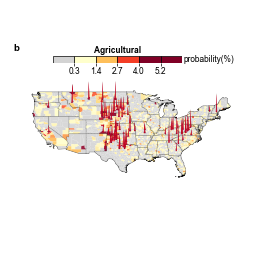

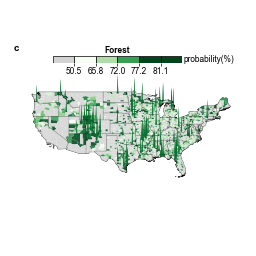

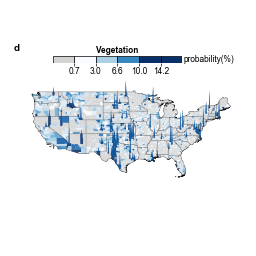

3D密度图生成完成！


In [127]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import math

def plot_3d_density(
    df_weight, 
    us_counties_4326, 
    us_states_4326, 
    var_names=('weighted_density_Forest','weighted_density_Agricultural','weighted_density_Vegetation'),
    var_threshold_pcts=(5,5,5),
    *, 
    spike_mode='line'        # 'line' | 'cone' | 'pyramid'
):
    """
    目标：
    - def _stretch_xy 函数控制的是图像伸缩程度（需要大量实验测试，不同的底图有不同伸缩方式来适应）
    - def _fullwidth_axe函数控制的是数据框大小（相当于地图外侧有个数据框，它与画布的设置figsize是有所不同的）
    - 主要控制视觉效果的是CFG中的elev，azim；
    - 峰值尽量简单（我这里给出了三种）
    """

    CFG = dict(
        fig_size=(60/25.4, 40/25.4),
        elev=70, azim=-90,        # ≈30°俯视、另外一个控制朝向，一般来说从南看北是这个角度。
        bg="white",               # 背景色设置为白色
        border_frac=0.02,         # 地图四周小留白
        z_exag=0.78,               # 控制峰值的大小
        peak_floor=0.25,
        max_spikes=200,
        line_width=1.0,
        cmaps=(plt.cm.YlOrRd, plt.cm.Greens, plt.cm.Blues),
        colorbar_percentiles=[90, 80, 70, 60, 50],  # 5段colorbar
        colorbar_labels=['90%', '80%', '70%', '60%', '50%'],
    )

    plt.rcParams.update({
        "font.family": "Arial",
        "pdf.fonttype": 42, "ps.fonttype": 42,
        "axes.linewidth": 0.5, "axes.edgecolor": "black",
    })

    # ——— 数据准备（4326，裁剪大陆48州） ———
    bbox = box(-125, 24, -65, 51)
    counties = us_counties_4326.to_crs(4326).clip(bbox)
    states   = us_states_4326.to_crs(4326).clip(bbox)

    xmin0, ymin0, xmax0, ymax0 = counties.total_bounds
    bx = (xmax0 - xmin0) * CFG["border_frac"]
    by = (ymax0 - ymin0) * CFG["border_frac"]
    xmin, xmax = xmin0 - bx, xmax0 + bx
    ymin, ymax = ymin0 - by, ymax0 + by
    xmid, ymid = 0.5*(xmin+xmax), 0.5*(ymin+ymax)
    xspan, yspan = (xmax-xmin), (ymax-ymin)

    gdf_weight = gpd.GeoDataFrame(
        df_weight.copy(),
        geometry=gpd.points_from_xy(df_weight["lon"], df_weight["lat"]),
        crs=4326
    )
    joined = gpd.sjoin(
        gdf_weight[["geometry"] + list(var_names)],
        counties[["geometry","NAME"]],
        predicate="within", how="inner"
    )
    stats = joined.groupby("NAME").agg({vn:"mean" for vn in var_names}).reset_index()
    counties_plot = counties.merge(stats, on="NAME", how="left").fillna(0.0)

    figs = []

    # —— 关键：自动把 3D pane 变成“以宽度为限的正方形”，并贴到底边 —— 
    def _fullwidth_axes(fig, ax):
        fw, fh = fig.get_size_inches()         # 例如 60mm×35mm
        need_h_norm = (fw / fh)                # 让轴域的归一化高度 >= 宽度（1.0）* (fw/fh)
        h = need_h_norm * 1.02              # 略加 2% 缓冲
        bottom = 1.2 - h                       # 顶边对齐到 1.0，把轴域整体“向下拉出画布”
        ax.set_position([0.0, bottom, 1.0, h]) # → pane 会以“宽度”为限制，横向吃满 60mm

    def _stretch_xy(fig, y_scale=1.0):
        # x和y都可拉伸，y_scale控制y方向拉伸倍数（默认1.0为不变）
        fw, fh = fig.get_size_inches()
        target_aspect = fw / fh
        data_aspect   = (xspan / yspan) if yspan > 0 else 1.0
        sx = target_aspect / data_aspect
        sy = y_scale * 1.25
        def sx_fun(xx): return xmid + sx*(xx - xmid)
        def sy_fun(yy): return ymid + sy*(yy - ymid)
        return sx_fun, sy_fun, sx, sy

    # ——— 可选的体块峰（若需要） ———
    def _add_line(ax, cx, cy, H, color, lw):
        ax.plot([cx,cx],[cy,cy],[0,H], color=color, lw=lw, alpha=0.95, zorder=20)

    def _add_cone(ax, cx, cy, H, color):
        # 极简圆锥：两圈就够（轻量）
        th = np.linspace(0, 2*np.pi, 24, endpoint=False)
        r0, r1 = 0.12, 0.0
        x0, y0 = cx + r0*np.cos(th), cy + r0*np.sin(th)
        x1, y1 = cx + r1*np.cos(th), cy + r1*np.sin(th)
        faces=[]
        for j in range(len(th)):
            j2=(j+1)%len(th)
            faces.append([(x0[j],y0[j],0.0),(x0[j2],y0[j2],0.0),(x1[j2],y1[j2],H)])
            faces.append([(x0[j],y0[j],0.0),(x1[j2],y1[j2],H), (x1[j],y1[j],H)])
        ax.add_collection3d(Poly3DCollection(faces, facecolor=(*color[:3],0.96), edgecolor=None, linewidths=0.1))

    def _add_pyramid(ax, cx, cy, H, color):
        d = 0.1
        base = np.array([[cx-d,cy,0],[cx,cy+d,0],[cx+d,cy,0],[cx,cy-d,0]])
        apex = np.array([cx,cy,H])
        faces=[[base[0],base[1],apex],[base[1],base[2],apex],[base[2],base[3],apex],[base[3],base[0],apex]]
        ax.add_collection3d(Poly3DCollection(faces, facecolor=(*color[:3],0.96), edgecolor=None, linewidths=0.12))
    
    def _add_colorbar(fig, ax, colorbar_thresholds, cmap, variable_name, peak_threshold):
        """添加左下角5段colorbar，在颜色交界处显示原始数值"""
        left, bottom, width, height = 0.18, 0.85, 0.55, 0.04
        cax = fig.add_axes([left, bottom, width, height], zorder=100)
        cax.set_in_layout(False)
        cax.set_zorder(50)

        # 6段颜色：灰色(0-50%) + 4段渐变(50%-90%) + 峰值色(90%+)
        colors = ['lightgray']
        for i in range(4):
            norm = i / 3
            colors.append(cmap(norm))
        colors.append(cmap(1.0))

        # 绘制colorbar - 修正对齐问题
        segment_width = 1.0 / 6
        for i in range(6):
            x_start = i * segment_width
            x_end = (i + 1) * segment_width
            cax.barh(0.5, x_end - x_start, left=x_start, height=1,
                    color=colors[i], edgecolor='black', linewidth=0.5)

        # 设置范围
        cax.set_xlim(0, 1)
        cax.set_ylim(0, 1)
        cax.set_yticks([])
        for spine in cax.spines.values():
            spine.set_visible(False)
        
        # 在颜色交界处显示原始数值 - 5个交界处对应5个数值
        tick_positions = [i * segment_width for i in range(1, 6)]  # 5个交界处位置
        tick_values = colorbar_thresholds  # 5个阈值
        tick_labels = [f'{v*100:.1f}' for v in tick_values]  # 乘以100，保留2位小数
        
        cax.set_xticks(tick_positions)
        cax.set_xticklabels(tick_labels, fontsize=6)
        
        # 缩小tick大小
        cax.tick_params(axis='x', which='major', length=2, width=0.5, pad=1, labelsize=6)
        cax.tick_params(axis='x', which='minor', length=1, width=0.3, label1On=False)
        
        # 添加标题
        cax.text(0.5, 1.3, f"{variable_name}", ha='center', va='bottom', 
                fontsize=6, fontweight='bold', transform=cax.transAxes)
        # 在坐标轴右侧添加 'probability(%)'
        cax.text(1.01, 0.5, 'probability(%)', ha='left', va='center', fontsize=6, transform=cax.transAxes)

        return cax
    

    for i,(vn,pctl) in enumerate(zip(var_names, var_threshold_pcts)):
        cmap = CFG["cmaps"][i] if i < len(CFG["cmaps"]) else plt.cm.viridis

        fig = plt.figure(figsize=CFG["fig_size"])
        ax  = fig.add_subplot(111, projection="3d")
        ax.set_axis_off()
        fig.patch.set_facecolor("white")
        ax.set_facecolor(CFG["bg"])

        # —— 横向拉伸（x 变宽，y 不变）——
        sx_fun, sy_fun, sx, sy = _stretch_xy(fig)
        xmin_s, xmax_s = sx_fun(xmin), sx_fun(xmax)
        ymin_s, ymax_s = sy_fun(ymin), sy_fun(ymax)
        xspan_s, yspan_s = (xmax_s-xmin_s), (ymax_s-ymin_s)
        z_target = CFG["z_exag"] * max(xspan_s, yspan_s)

        # —— 先设置范围 —— 
        ax.set_xlim(xmin_s, xmax_s)
        ax.set_ylim(ymin_s, ymax_s)
        ax.set_zlim(0, z_target)

        try: ax.set_proj_type('ortho')
        except Exception: pass
        ax.view_init(elev=CFG["elev"], azim=CFG["azim"])

        # —— 把 pane 做“又宽又扁”，但关键靠下面的 _fullwidth_axes —— 
        try: ax.set_box_aspect([xspan_s*1.8, yspan_s, z_target*0.6])
        except Exception: pass

        # —— 彻底让 pane 以“宽度”为限制，并贴到底边 —— 
        _fullwidth_axes(fig, ax)   
        for f in (ax.set_zmargin, ax.set_xmargin, ax.set_ymargin):
            try: f(0.0)
            except Exception: pass

        # 州界（Z=0）
        for geom in states.geometry:
            if geom.is_empty: continue
            geoms = [geom] if geom.geom_type=="Polygon" else list(geom.geoms)
            for g in geoms:
                x,y = g.exterior.xy
                ax.plot(sx_fun(np.asarray(x)), sy_fun(np.asarray(y)), np.zeros_like(x), 
                        color="black", lw=0.5, alpha=0.7)

        ## 方便你自己检查数据框的位置，把握
        # ax.plot([xmin_s, xmax_s, xmax_s, xmin_s, xmin_s], 
        #         [ymin_s, ymin_s, ymax_s, ymax_s, ymin_s], 
        #         [0, 0, 0, 0, 0], 
        #         color="black", lw=0.5, alpha=0.8, zorder=10)
                        

        # 底图
        vals_all = counties_plot[vn].to_numpy(float)
        pos_all  = vals_all[vals_all > 0]
        thr  = np.percentile(pos_all, 100-pctl) if pos_all.size else 0.0


        colorbar_thresholds = [np.percentile(pos_all, 100-p) if pos_all.size else 0.0 for p in CFG["colorbar_percentiles"]]



        for _, row in counties_plot.iterrows():
            geom = row.geometry
            v    = float(row[vn])
            
            # 确定颜色 - 使用渐变而不是单色
            if v <= 0:
                color = 'lightgray'  # 0值显示为灰色
            elif v < colorbar_thresholds[-1]:  # 小于50%阈值
                color = 'lightgray'  # 0-50%显示为灰色
            elif v >= thr:  # 超过峰值阈值（前var_threshold_pcts%）
                color = cmap(1.0)  # 前var_threshold_pcts%保持最亮颜色
            else:
                # 在50%-var_threshold_pcts%之间，使用连续渐变
                # 将v映射到50%-90%的范围内
                v_min = colorbar_thresholds[-1]  # 50%阈值
                v_max = thr  # 峰值阈值
                if v_max > v_min:
                    norm = (v - v_min) / (v_max - v_min)
                    color = cmap(norm)
                else:
                    color = cmap(0.5)
            
            patches = [geom] if geom.geom_type=="Polygon" else list(geom.geoms)
            for poly in patches:
                x,y = poly.exterior.xy
                xs,ys = sx_fun(np.asarray(x)), sy_fun(np.asarray(y))
                ax.add_collection3d(Poly3DCollection([list(zip(xs,ys,np.zeros_like(xs)))],
                                                    facecolor=color, edgecolor='none', alpha=0.88))

        # 峰（默认线段，最简单）
        needles = counties_plot[counties_plot[vn] > thr].copy()
        needles = needles.sort_values(vn, ascending=False).head(CFG["max_spikes"])
        Hmin = CFG["peak_floor"] * z_target
        vmax = max(thr, needles[vn].max()) if not needles.empty else thr
        for _, row in needles.iterrows():
            v = float(row[vn]); s = 0 if vmax<=0 else (v - thr) / (vmax - thr + 1e-9)
            H = Hmin + (z_target - Hmin) * (s ** 0.7)
            c  = row.geometry.centroid
            cx, cy = sx_fun(c.x), sy_fun(c.y)
            col = cmap(0.85)
            if spike_mode == 'line':
                ax.plot([cx,cx],[cy,cy],[0,H], color=col, lw=CFG["line_width"], alpha=0.95, zorder=20)
            elif spike_mode == 'cone':
                _add_cone(ax, cx, cy, H, col)
            elif spike_mode == 'pyramid':
                _add_pyramid(ax, cx, cy, H, col)

        # 面板字母
        fig.text(0.015, 0.97, chr(ord('b')+i), ha='left', va='top',
                 fontsize=7, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.85, pad=0.25, lw=0))

        cax_colorbar=_add_colorbar(fig, ax, colorbar_thresholds, cmap, titles[i], thr)

        

        figs.append(fig)

    return figs



# ==================== 主程序 ====================
# 使用示例
try:
    titles = ['Agricultural','Forest' ,'Vegetation',]
    figs = plot_3d_density(
    emission_data_merge, us_counties_4326, us_states_4326,
    var_names=['weighted_density_Agricultural','weighted_density_Forest','weighted_density_Vegetation'],
    var_threshold_pcts=[3,3,3],
    spike_mode='cone'  # 或 'cone' / 'pyramid'
    )
    
    for i, fig in enumerate(figs):
        filename_png = f"figure/US_figure/3d_density_{titles[i].lower()}_300dpi.png"
        filename_pdf = f"figure/US_figure/3d_density_{titles[i].lower()}_300dpi.pdf"
        
        fig.savefig(filename_png, dpi=300, facecolor='White')  
        fig.canvas.draw()
        fig.savefig(filename_pdf, dpi=300, facecolor='None')                       

        plt.show()
        plt.close(fig)
    
    print("3D密度图生成完成！")

except Exception as e:
    print(f"生成3D密度图时出错: {e}")

## 3.3 图3：LNCS与PV的云雨图

云雨图生成完成！


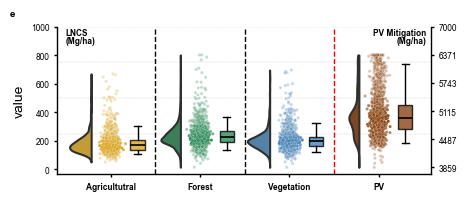

In [98]:
def integrated_cloudrain_carbon_analysis(emission_data_merge, us_counties_4326):
    import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
    import ptitprince as pt
    from scipy.stats import gaussian_kde
    import geopandas as gpd

    # ---------- 样式 ----------
    plt.rcParams.update({
        "font.family": "Arial", "pdf.fonttype": 42, "ps.fonttype": 42,
        "axes.linewidth": 0.5, "axes.edgecolor": "black",
        "ps.usedistiller": "ghostscript", "ps.distiller.res": 6000,
    })

    def get_density_colors(data, base_color, n_levels=5):
        from matplotlib.colors import to_rgba
        if len(data) < 2: return [to_rgba(base_color)] * len(data)
        kde = gaussian_kde(data); density = kde(data)
        qs = np.percentile(density, np.linspace(0,100,n_levels+1))
        base = to_rgba(base_color); out=[]
        for d in density:
            lvl = np.clip(np.digitize(d, qs)-1, 0, n_levels-1)
            a = 0.3 + 0.7*(lvl/max(1,n_levels-1))
            out.append((base[0], base[1], base[2], float(a)))
        return out

    # ---------- 数据 ----------
    required_cols = ['final_forest','final_agro','final_veg','pv_potential_total(t)','lat','lon']
    missing = [c for c in required_cols if c not in emission_data_merge.columns]
    if missing: raise ValueError(f"缺少必要的列: {missing}")
    data = emission_data_merge[required_cols].copy()

    # 99%分位截断
    data['final_forest'] = data['final_forest'].clip(upper=data['final_forest'].quantile(0.99))
    for c in ['final_agro','final_veg','pv_potential_total(t)']:
        data[c] = data[c].clip(upper=data[c].quantile(0.99))

    gdf = gpd.GeoDataFrame(data,
            geometry=gpd.points_from_xy(data['lon'], data['lat']), crs='EPSG:4326')
    counties = us_counties_4326.to_crs(4326)
    joined = gpd.sjoin(gdf, counties[['geometry','NAME']], predicate='within', how='inner')

    aggregated = (joined.groupby('NAME')[['final_forest','final_agro','final_veg','pv_potential_total(t)']]
                  .mean().reset_index())

    # 顺序：Agro, Forest, Veg, PV
    order = ['final_agro','final_forest','final_veg','pv_potential_total(t)']
    df_long = aggregated[order].melt(var_name="Clade", value_name="value")

    palette = {
        'final_agro':'#DAA520', 'final_forest':'#2E8B57',
        'final_veg':'#4682B4', 'pv_potential_total(t)':'#8B4513'
    }

    # ---------- 画布 ----------
    fig, ax = plt.subplots(1,1, figsize=(120/25.4, 50/25.4))

    # ---------- 双轴（把 PV 映射到左轴） ----------
    carbon = df_long[df_long['Clade']!='pv_potential_total(t)']['value']
    cmin, cmax = carbon.min(), carbon.max()
    y_upper = 1000 if cmax>550 else 650
    ax.set_ylim(cmin - 0.05*(y_upper - cmin), y_upper)

    pv = df_long[df_long['Clade']=='pv_potential_total(t)']['value']
    if len(pv)>0:
        pv_min, pv_max = pv.min(), pv.max()
        pv_max_display = max(7000, pv_max)
        scale = (y_upper - cmin) / (pv_max_display - pv_min)
        def pv_to_c(y): return cmin + (y - pv_min)*scale
        def c_to_p(y):  return pv_min + (y - cmin)/scale
        df_long.loc[df_long['Clade']=='pv_potential_total(t)','value'] = \
            pv_to_c(df_long.loc[df_long['Clade']=='pv_potential_total(t)','value'].values)
        secax = ax.secondary_yaxis('right', functions=(c_to_p, pv_to_c))
        secax.tick_params(axis='y', colors='black', labelsize=6, width=1)
        secax.spines['right'].set_position(('outward', -20))
        secax.spines['right'].set_color('black'); 
        secax.spines['right'].set_linewidth(1)
        # secax.set_ylabel('PV mitigation', fontsize=6, fontweight='bold')
        ax.annotate(r'(Mg/ha)', xy=(0.92,0.94), xycoords='axes fraction',
            ha='right', va='top', fontweight='bold', fontsize=6)
        ax.annotate(r'PV Mitigation', xy=(0.92, 0.99), xycoords='axes fraction',
                    ha='right', va='top', fontweight='bold', fontsize=6, color='black')
                
        # 副Y轴刻度设置：与主轴Y一致，包含0刻度
        secax.yaxis.set_major_locator(plt.MaxNLocator(nbins=6))
        secax.set_ylim(pv_min, pv_max_display)

        # 确保0刻度显示
        ticks = np.linspace(pv_min, pv_max_display, 6)
        if 0 not in ticks:
            ticks = np.concatenate([[0], ticks])
        secax.set_yticks(ticks)
        secax.set_yticklabels([str(int(v)) for v in ticks], fontsize=6)
        secax.tick_params(axis='y', labelsize=6, length=2, width=1)

    # ---------- 核心布局（同一坐标系：0,1,2,3） ----------
    n = len(order)
    centers = np.arange(n, dtype=float)    # 0,1,2,3

    # 组内：左(半提琴) → 中(散点) → 右(箱线)
    delta_v = 0.22    # 半提琴相对中心向左
    delta_j =  0.00    # 抖点在中心
    delta_b =  0.30    # 箱线相对中心向右

    violin_width = 0.50
    box_width    = 0.16
    jitter_width = 0.04

    # 1) 半提琴（一次性画全部类别；注意 offset 是相对中心的小位移）
    pt.half_violinplot(
        x='Clade', y='value', data=df_long, order=order,
        palette=[palette[v] for v in order],
        bw=.2, cut=0, scale="area",
        width=violin_width, inner=None, orient="v",
        ax=ax, offset=delta_v, zorder=1
    )
    ax.set_xlabel('')  # 去掉 ptitprince 可能加的 'Clade' 标签

    # 2) 箱线（在右侧）
    data_list = [df_long[df_long['Clade']==v]['value'].values for v in order]
    box_pos = centers + delta_b
    bp = ax.boxplot(
        data_list, positions=box_pos, widths=box_width,
        patch_artist=True, showfliers=False, whis=(5,95),
        medianprops={'linewidth':1.2,'color':'black'},
        whiskerprops={'linewidth':1.0,'color':'black'},
        capprops={'linewidth':1.0,'color':'black'},
        boxprops={'linewidth':1.0}, zorder=3
    )
    # 给每个箱图上色，颜色与琴图一致
    for i, p in enumerate(bp['boxes']):
        p.set(facecolor=palette[order[i]], alpha=0.8, edgecolor='black')

    # 3) 抖点（在中间）
    for i, v in enumerate(order):
        vals = df_long[df_long['Clade']==v]['value'].values
        if len(vals)==0: continue
        cols = get_density_colors(vals, palette[v])
        xj = np.random.normal(centers[i] + delta_j, jitter_width, size=len(vals))
        ax.scatter(xj, vals, c=cols, s=5, edgecolors='white', linewidth=0.1, zorder=2)

    ax.axvline((order.index('final_veg') + order.index('pv_potential_total(t)')) / 2.0,
            color='red', linestyle='--', linewidth=1, alpha=1, zorder=10)
        # 分界线：Veg 与 PV 之间（索引 2 和 3 的中点）
    ax.axvline((order.index('final_agro') + order.index('final_forest')) / 2.0,
            color='black', linestyle='--', linewidth=1, alpha=1, zorder=10)
        # 分界线：Veg 与 PV 之间（索引 2 和 3 的中点）
    ax.axvline((order.index('final_forest') + order.index('final_veg')) / 2.0,
            color='black', linestyle='--', linewidth=1, alpha=1, zorder=10)

    # x 轴刻度与留白
    ax.set_xticks(centers)
    ax.set_xticklabels(['Agricultutral','Forest','Vegetation','PV'], fontsize=6, fontweight='bold')

    # 调整边距以适应新的布局
    left_pad  = 0.6
    right_pad = 0.6 + delta_b
    ax.set_xlim(centers[0]-left_pad, centers[-1]+right_pad)

    ax.set_position([0.11, 0.15, 0.85, 0.75])
    fig.canvas.draw()  # 需要实际像素尺寸

    pos_mode, pos_val = secax.spines['right'].get_position()
    if pos_mode == 'outward':
        # outward 模式：pt -> 像素 -> 轴坐标（0~1）
        dx_pt = -pos_val                     # -20 pt（向内） -> 20 pt
        dx_px = dx_pt * fig.dpi / 72.0       # pt -> px
        ax_w  = ax.get_window_extent().width # 轴的像素宽度
        x_axes = 1.0 - (dx_px / ax_w)        # 副轴右脊线在“轴坐标”中的位置
    elif pos_mode == 'axes':
        x_axes = pos_val                     # 已是轴坐标（0~1）
    else:
        x_axes = 1.0                         # 其他模式：当作最右边界

    # 轴坐标 -> 数据坐标（在 y=0 处取 x）
    x_data = ax.transData.inverted().transform(ax.transAxes.transform((x_axes, 0)))[0]

    ax.grid(False)
    xmin, xmax = ax.get_xlim()
    yticks = [t for t in ax.get_yticks() if t != 0]   # 可选：不在 y=0 画，避免与 x 轴重合
    for y in yticks:
        ax.hlines(y, xmin, x_data, colors='0.8', linestyles='--', linewidth=0.3, zorder=0)

    
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=6))
    ax.tick_params(axis='y', labelsize=6, length=2, width=1, colors='black', labelcolor='black')
    ax.tick_params(axis='x', labelsize=6, length=2, width=1)

    # ax.set_ylabel('LNCS', fontsize=6, fontweight='bold', labelpad=2)
    ax.annotate(r'(Mg/ha)', xy=(0.02,0.94), xycoords='axes fraction',
                ha='left', va='top', fontweight='bold', fontsize=6)
    ax.annotate(r'LNCS', xy=(0.02, 0.99), xycoords='axes fraction',
                ha='left', va='top', fontweight='bold', fontsize=6, color='black')

    # 边框设置 - 让XY轴相连，精简轴线
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    
    # 副Y轴边框设置
    secax.spines['top'].set_visible(False)
    secax.spines['left'].set_visible(False)
    secax.spines['right'].set_linewidth(1)
    secax.spines['right'].set_color('black')
    secax.spines['bottom'].set_visible(False)
    
    # 调整底边框位置，不超过副Y轴位置
    ax.spines['bottom'].set_bounds(ax.get_xlim()[0], ax.get_xlim()[1])
    


    # 把 bottom 脊线裁到 [xmin, x_data]
    xmin, _ = ax.get_xlim()
    ax.spines['bottom'].set_bounds(xmin, x_data)

    # 细节：提高脊线 zorder，确保交汇处清晰
    ax.spines['bottom'].set_zorder(10)
    ax.spines['left'].set_zorder(10)

    fig.text(0.01, 0.99, 'e', ha='left', va='top',
             fontsize=7, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.85, pad=0, lw=0))

    print("云雨图生成完成！")
    return fig

# 执行函数
fig = integrated_cloudrain_carbon_analysis(emission_data_merge, us_counties_4326)

# 保存图片模块放在外面
filename_png = "figure/US_figure/integrated_cloudrain_carbon.png"
filename_pdf = "figure/US_figure/integrated_cloudrain_carbon.pdf"
fig.savefig(filename_png, dpi=300, facecolor='white', pad_inches=0.1)
fig.canvas.draw()
fig.savefig(filename_pdf, dpi=300, facecolor='white', pad_inches=0.1)
plt.show()
plt.close(fig)

## 3.4 图4：PV发电能力折线图

In [9]:
emission_data_merge

,lat,lon,Expectation_net_benefit,LNCS_expect,area_m2,pv_potential_total(t),power_generation_kwha,pv_potential_2020_2029_sum,pv_potential_2030_2039_sum,pv_potential_2040_2049_sum,final_forest,final_agro,final_veg,weighted_density_Agricultural,weighted_density_Forest,weighted_density_Vegetation
0,25.295834,-80.287500,4758.781908,809.562299,776295.361002,5568.344207,7.567199e+07,2167.108342,1770.850632,1630.385232,809.5685,764.000000,821.04486,0.000367,0.998714,0.000918
1,25.437500,-80.537500,4102.430766,1344.744161,775385.854124,5447.174926,7.402534e+07,2119.951244,1732.316251,1594.907432,1389.7133,1102.152466,1126.51390,0.007830,0.829869,0.162302
2,25.437500,-80.495834,4469.645652,968.823440,775385.854124,5438.469092,7.390703e+07,2116.563075,1729.547612,1592.358404,1026.1462,750.145691,778.08900,0.022229,0.771417,0.206354
3,25.445833,-80.454170,4464.453759,968.995616,775332.207938,5433.449375,7.383881e+07,2114.609484,1727.951237,1590.888654,1026.1462,756.315613,777.34060,0.007369,0.770923,0.221708
4,25.445833,-80.404170,4490.532039,964.480123,775332.207938,5455.012162,7.413184e+07,2123.001367,1734.808657,1597.202138,1051.1307,728.004333,758.56060,0.099801,0.714253,0.185946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64977,48.995834,-111.970830,4767.814366,181.751426,563356.382622,4949.565792,6.726299e+07,1926.289920,1574.066075,1449.209796,182.2000,170.484009,174.20488,0.017433,0.952007,0.030560
64978,48.995834,-110.345830,4762.226494,189.800818,563356.382622,4952.027311,6.729644e+07,1927.247903,1574.848890,1449.930518,198.1000,175.665878,177.52232,0.332696,0.626705,0.040599
64979,48.995834,-106.020836,4757.472100,207.085706,563356.382622,4964.557807,6.746673e+07,1932.124567,1578.833851,1453.599388,207.1000,206.000000,207.00000,0.003256,0.889626,0.107118
64980,48.995834,-104.087500,4656.838886,215.466966,563356.382622,4872.305853,6.621305e+07,1896.221618,1549.495789,1426.588446,225.2000,204.508926,207.61511,0.057912,0.456741,0.485347


PV潜力分段: 31.954074, 26.111243, 24.040077
PV潜力累积: [31.954074384817687, 58.065317514960306, 82.10539431913611]
LNCS分段: 3.137677, 0.226523, 0.551758
LNCS累积: [3.1376772946135243, 3.3642007317124176, 3.9159588375094194]
发电量 (T kWh): 3.01e+02
累积柱状图生成完成！
PV潜力 (Gt CO₂): 82.105394
LNCS (Gt CO₂): 3.915959
发电量 (T kWh): 3.01e+02


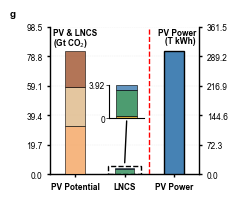

In [85]:
def plot_cumulative_bar_charts(emission_data_merge):
    """
    绘制累积柱状图
    第一个order: PV潜力累积柱状图
    第二个order: LNCS累积柱状图  
    第三个order: 发电量柱状图（副Y轴）
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.patches import Rectangle, ConnectionPatch
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    # ---------- 样式 ----------
    plt.rcParams.update({
        "font.family": "Arial", "pdf.fonttype": 42, "ps.fonttype": 42,
        "axes.linewidth": 0.5, "axes.edgecolor": "black",
        "ps.usedistiller": "ghostscript", "ps.distiller.res": 6000,
    })

    # ---------- 数据 ----------
    required_cols = [
        'pv_potential_2020_2029_sum', 'pv_potential_2030_2039_sum', 'pv_potential_2040_2049_sum',
        'final_forest', 'final_agro', 'final_veg', 'weighted_density_Forest', 
        'weighted_density_Agricultural', 'weighted_density_Vegetation',
        'power_generation_kwha', 'area_m2'
    ]
    missing = [c for c in required_cols if c not in emission_data_merge.columns]
    if missing: raise ValueError(f"缺少必要的列: {missing}")

    # 面积转换为公顷
    area_ha = emission_data_merge['area_m2'].values / 10000

    # ---------- 计算数据 ----------
    # 1. PV潜力累积 (Gt CO2)
    pv_2020_2029 = (emission_data_merge['pv_potential_2020_2029_sum'] * area_ha).sum() / 0.27 / 1e9
    pv_2030_2039 = (emission_data_merge['pv_potential_2030_2039_sum'] * area_ha).sum() / 0.27 / 1e9
    pv_2040_2049 = (emission_data_merge['pv_potential_2040_2049_sum'] * area_ha).sum() / 0.27 / 1e9
    pv_cumulative = [pv_2020_2029, pv_2020_2029 + pv_2030_2039, pv_2020_2029 + pv_2030_2039 + pv_2040_2049]

    # 2. LNCS累积 (Gt CO2) - 参照PV的处理方式
    lncs_forest = (emission_data_merge['final_forest'] * emission_data_merge['weighted_density_Forest'] * area_ha).sum() / 0.27 / 1e9
    lncs_agro = (emission_data_merge['final_agro'] * emission_data_merge['weighted_density_Agricultural'] * area_ha).sum() / 0.27 / 1e9
    lncs_veg = (emission_data_merge['final_veg'] * emission_data_merge['weighted_density_Vegetation'] * area_ha).sum() / 0.27 / 1e9
    lncs_cumulative = [lncs_forest, lncs_forest + lncs_agro, lncs_forest + lncs_agro + lncs_veg]

    # 3. 发电量 (T kWh) - 除以1e12转换为T kWh
    power_total = (emission_data_merge['power_generation_kwha'] * area_ha).sum() / 1e12

    # 调试输出
    print(f"PV潜力分段: {pv_2020_2029:.6f}, {pv_2030_2039:.6f}, {pv_2040_2049:.6f}")
    print(f"PV潜力累积: {pv_cumulative}")
    print(f"LNCS分段: {lncs_forest:.6f}, {lncs_agro:.6f}, {lncs_veg:.6f}")
    print(f"LNCS累积: {lncs_cumulative}")
    print(f"发电量 (T kWh): {power_total:.2e}")

    # ---------- 画布 ----------
    fig, ax = plt.subplots(1, 1, figsize=(60/25.4, 50/25.4))

    # ---------- 绘制柱状图 ----------
    x_pos = np.arange(3)  # 3个order
    width = 0.4  # 收窄柱子

    # 第三个order: 
    ax2 = ax.twinx()
    if power_total > 0:  
        power_bars = ax2.bar(x_pos[2], power_total, width,
                             color='#4682B4', alpha=1, edgecolor='black', linewidth=1,
                             label='Power', zorder=2)

    # ---------- 绘制分段累积效果 ----------
    # PV分段
    if pv_cumulative[-1] > 0:
        pv_segments = [pv_2020_2029, pv_2030_2039, pv_2040_2049]
        pv_colors = ['#F4A460', '#DEB887', '#A0522D']  
        bottom = 0
        for i, (seg, color) in enumerate(zip(pv_segments, pv_colors)):
            if seg > 0: 
                ax.bar(x_pos[0], seg, width, bottom=bottom, color=color, alpha=0.8, 
                       edgecolor='black', linewidth=0.5, zorder=3)
                bottom += seg

    # LNCS分段
    if lncs_cumulative[-1] > 0:
        lncs_segments = [lncs_agro, lncs_forest, lncs_veg]
        lncs_colors = ['#DAA520', '#2E8B57', '#4682B4']  
        bottom = 0
        for i, (seg, color) in enumerate(zip(lncs_segments, lncs_colors)):
            if seg > 0:
                ax.bar(x_pos[1], seg, width, bottom=bottom, color=color, alpha=0.8,
                       edgecolor='black', linewidth=0.5, zorder=3)
                bottom += seg

    # ---------- 坐标轴设置 ----------
    # X轴
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['PV Potential', 'LNCS', 'PV Power'], fontsize=6, fontweight='bold')
    ax.set_xlim(-0.5, 2.5)

    # 主Y轴设置 - 确保包含所有非零值
    main_values = []
    if pv_cumulative[-1] > 0:
        main_values.append(pv_cumulative[-1])
    if lncs_cumulative[-1] > 0:
        main_values.append(lncs_cumulative[-1])

    if main_values:
        max_main = max(main_values)
        ax.set_ylim(0, max_main * 1.2)
    else:
        ax.set_ylim(0, 1)  # 默认范围

    # 设置主Y轴刻度（1位小数）
    main_ticks = np.linspace(0, max_main * 1.2, 6)
    ax.set_yticks(main_ticks)
    ax.set_yticklabels([f'{t:.1f}' for t in main_ticks], fontsize=6)
    ax.tick_params(axis='y', labelsize=6, length=2, width=1, colors='black', labelcolor='black')
    ax.tick_params(axis='x', labelsize=6, length=2, width=1)

    # 副Y轴设置
    if power_total > 0:
        main_min, main_max = ax.get_ylim()
        power_min, power_max = 0, power_total * 1.2
        ax2.set_ylim(power_min, power_max)
        ax2.set_yticks([])
        ax2.spines['right'].set_visible(False)

        def power_to_main(y):
            return main_min + (y - power_min) * (main_max - main_min) / (power_max - power_min)
        def main_to_power(y):
            return power_min + (y - main_min) * (power_max - power_min) / (main_max - main_min)

        secax = ax.secondary_yaxis('right', functions=(main_to_power, power_to_main))
        # secax.set_ylabel('Power Generation', fontsize=6, fontweight='bold', color='black')
        n_ticks = 6
        ticks_power = np.linspace(power_min, power_max, n_ticks)
        secax.set_yticks(ticks_power)
        secax.set_yticklabels([f'{t:.1f}' for t in ticks_power], fontsize=6)
        secax.tick_params(axis='y', labelsize=6,length=2, width=1)
        secax.tick_params(axis='x', labelsize=6, length=2, width=1)
    else:
        ax2.set_ylim(0, 1)
        ax2.set_yticks([])
        ax2.spines['right'].set_visible(False)

    # ax2.tick_params(axis='y', labelsize=6, length=2, width=1, colors='black', labelcolor='black')

    # 网格
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.3, axis='y')

    # ---------- LNCS放大框（根据数据调整，进一步放大） ----------
    if lncs_cumulative[-1] > 0 and lncs_cumulative[-1] < max_main * 0.1:
        lncs_center = x_pos[1]                 # 第二组中心
        y_zoom_max = lncs_cumulative[-1] * 1.5 # 增加放大范围

        # 1) 主图中的"脚印"框：与 LNCS 柱同中心，稍宽一些，覆盖 [0, y_zoom_max]，改为虚线
        rect_w  = width * 1.7                  
        rect_x0 = lncs_center - rect_w / 2
        footprint = Rectangle(
            (rect_x0, 0), rect_w, y_zoom_max,
            fill=False, edgecolor='black', linewidth=1, zorder=9, linestyle='--'
        )
        ax.add_patch(footprint)

        # 2) 放大窗口：锚到 LNCS 正上方，且在 Y 方向居中（axes 坐标 0~1）
        xmin, xmax = ax.get_xlim()
        x_rel = (lncs_center - xmin) / (xmax - xmin) - 0.16 
        y_rel = 0.30                                  # 在 Y 方向中部（

        zoom_ax = inset_axes(
            ax,
            width=0.35, height=0.5,             
            bbox_to_anchor=(x_rel, y_rel, 0.35, 0.5),  # 提供4元组 (x, y, width, height)
            bbox_transform=ax.transAxes,
            loc='center', borderpad=0
        )

        # 放大窗口画 LNCS 的堆叠分段；y 范围与脚印一致
        zoom_ax.set_ylim(0, y_zoom_max)
        zoom_ax.set_xlim(0, 1)
        bottom = 0
        for seg, color in zip([lncs_agro, lncs_forest, lncs_veg],
                              ['#DAA520', '#2E8B57', '#4682B4']):
            if seg > 0:
                zoom_ax.bar(0.5, seg, 0.6, bottom=bottom,
                            color=color, alpha=0.85,
                            edgecolor='black', linewidth=0.5)
                bottom += seg

        # 简洁刻度与标签 - 去掉Y轴标签，缩短y轴
        zoom_ax.set_xticks([])
        zoom_ax.set_yticks([0, lncs_cumulative[-1]])
        zoom_ax.set_yticklabels(['0', f'{lncs_cumulative[-1]:.2f}'], fontsize=5)
        zoom_ax.tick_params(axis='y', labelsize=6, length=2, width=0.5, pad=1)
        zoom_ax.spines['left'].set_bounds(0, lncs_cumulative[-1])  # 只显示y轴短段
        # 注释掉Y轴标签
        # zoom_ax.set_ylabel('LNCS Detail', fontsize=5, fontweight='bold')

        # 窗口边框：只保留左、下
        for s in ['top', 'right']:
            zoom_ax.spines[s].set_visible(False)
        for s in ['left', 'bottom']:
            zoom_ax.spines[s].set_visible(True)
            zoom_ax.spines[s].set_linewidth(0.8)
            zoom_ax.spines[s].set_color('black')

        # 3) 单条连接线：脚印顶边中心 -> 放大窗口底边中心
        ax.annotate(
            '', xy=(0.5, 0), xycoords=zoom_ax.transAxes,      # 目标：窗口底边中心
            xytext=(lncs_center, y_zoom_max), textcoords=ax.transData,  # 起点：脚印顶边中心
            arrowprops=dict(arrowstyle='-', color='black', lw=1.0)
        )

    # 标签
    ax.annotate('PV & LNCS', xy=(0.02, 0.99), xycoords='axes fraction',
                ha='left', va='top', fontweight='bold', fontsize=6, color='black')
    ax.annotate(r'(Gt CO$_2$)', xy=(0.02, 0.94), xycoords='axes fraction',
                ha='left', va='top', fontweight='bold', fontsize=6, color='black')

    # ax2.set_ylabel('Power Generation', fontsize=6, fontweight='bold', labelpad=2, color='black')
    ax2.annotate('PV Power', xy=(0.98, 0.99), xycoords='axes fraction',
            ha='right', va='top', fontweight='bold', fontsize=6, color='black')
    ax2.annotate(r'(T kWh)', xy=(0.98, 0.94), xycoords='axes fraction',
                ha='right', va='top', fontweight='bold', fontsize=6, color='black')
    ax.axvline((x_pos[1] + x_pos[2]) / 2.0,
           color='red', linestyle='--', linewidth=1, alpha=1, zorder=10)

    # 边框设置
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')

    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)  
    ax2.spines['bottom'].set_visible(False)

    # 确保secax的右脊线与主Y轴左脊线宽度一致
    secax.spines['right'].set_linewidth(1)
    secax.spines['right'].set_color('black')

    # 布局位置
    ax.set_position([0.18, 0.15, 0.63, 0.75]) 

    # 面板标签
    fig.text(0.01, 0.99, 'g', ha='left', va='top',
             fontsize=7, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.85, pad=0, lw=0))

    print("累积柱状图生成完成！")
    print(f"PV潜力 (Gt CO₂): {pv_cumulative[-1]:.6f}")
    print(f"LNCS (Gt CO₂): {lncs_cumulative[-1]:.6f}")
    print(f"发电量 (T kWh): {power_total:.2e}")
    
    return fig

# 执行函数
fig = plot_cumulative_bar_charts(emission_data_merge)

# 保存图片
filename_png = "figure/US_figure/cumulative_bar_charts.png"
filename_pdf = "figure/US_figure/cumulative_bar_charts.pdf"
fig.savefig(filename_png, dpi=300, facecolor='white', pad_inches=0.1)
fig.canvas.draw()
fig.savefig(filename_pdf, dpi=300, facecolor='white', pad_inches=0.1)
plt.show()
plt.close(fig)

# 四、经济内容图

绘制瀑布图（级联条形图）的嵌套图，主要绘制'revenue' 'expenditure' 'oppotunity' 'net' 四个主要group，并且记录这几个order，主要数据输入有df_economic，df_pv_npv，df_agricultural_npv，df_afforestation_npv，df_natural_npv。你最好分成计算聚合模块与绘图模块两个。


一、图片主要逻辑：
（1）在各个Group内：
在'revenue' 中，绘制总体'Overall Mean' 'P1 Mean' 'P2 Mean' 'P3 Mean' 四个variable，但是需要体现'P1' 'P2' 'P3'与'Overall Mean'的difference， 这些difference与'mean'桥连
在'expenditure'中，也按照以上的逻辑绘制总体'Overall Mean' 'P1 Mean' 'P2 Mean' 'P3 Mean' 四个variable，但是需要体现'P1' 'P2' 'P3'与'Overall Mean'的difference， 这些difference与'mean'桥连
在'oppotunity'中，绘制'Agricultural' 'Forest' 'Vegetation' 的 'Mean' ，其中'Agricultural''Forest' 'Vegetation'需要区分P1,P2,P3的'Mean'，以误差棒的形式在它自己的'Mean'柱子上，这三个'Mean'彼此桥连
在'net' 中，仅绘制'Overall Mean' 
（2）在Group之间：
用桥连接'revenue' 的总体'Mean'- 'expenditure' 的 'Mean'- 'oppotunity'的各个成本项 = 'net' 的 'Mean'。

二、变量计算逻辑
在'revenue'中的的 'Overall Mean' 与  'P1' 'P2' 'P3' 的各个 'Mean'可以参考create_policy_scenarios_analysis计算方法，但是需要对['cumulative_npv_usd']+['cumulative_cost_usd']已经算好的净收益与成本进行相加
在'expenditure' 的 'Overall Mean' 与  'P1' 'P2' 'P3' 的各个 'Mean'可以参考create_policy_scenarios_analysis计算方法，对每个pixel根据Policy_category进行group聚合
在'oppotunity'中，各个变量需要 (df_weight['weighted_density_Forest'] * df_agricultural_npv['cumulative_npv_usd'] +
                 df_weight['weighted_density_Agricultural'] * df_afforestation_npv['agri_npv'] +
                 df_weight['weighted_density_Vegetation'] * ，df_natural_npv['natural_npv'])
在'net' 的 'Overall Mean' 与  'P1' 'P2' 'P3' 的各个 'Mean'可以参考create_policy_scenarios_analysis计算方法，对每个pixel根据Policy_category进行group聚合

数据接口：
'revenue' 的各个数据需要用到df_pv_npv的['Policy_category']['analysis_year']==2050 , 它需要['cumulative_npv_usd']+['cumulative_cost_usd']；
'expenditure'的各个数据需要用到df_pv_npv的 ['Policy_category']['analysis_year']==2050 ['cumulative_cost_usd']；
'oppotunity'的各个数据需要用到df_agricultural_npv['cumulative_npv_usd']['RCP_Category']，df_afforestation_npv['cumulative_npv_usd']['RCP_Category']，df_natural_npv['cumulative_npv_usd']['RCP_Category']三个df，并且需要merge df_weight的'lat' 'lon' 'weighted_density_Agricultural' 'weighted_density_Forest' 'weighted_density_Vegetation	' 
'net'的需要用到df_economic的['policy_category'][analysis_year==2050][net_npv_usd]



In [3]:
df_pv_npv

,pixel_id,lat,lon,Model,Scenario,Policy_category,Category,analysis_year,cumulative_npv_usd,cumulative_cost_usd
0,805,31.320833,-105.929170,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,C1,2020,-2365471.77,2365471.77
1,807,31.329166,-105.929170,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,C1,2020,-2365471.77,2365471.77
2,808,31.337500,-105.937500,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,C1,2020,-2365471.77,2365471.77
3,809,31.337500,-105.929170,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,C1,2020,-2365471.77,2365471.77
4,810,31.345833,-105.937500,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,C1,2020,-2365471.77,2365471.77
...,...,...,...,...,...,...,...,...,...,...
68880915,70272,46.937500,-67.920830,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,C7,2050,4445834.80,4656004.18
68880916,70281,47.145832,-67.962500,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,C7,2050,4147469.12,4656004.18
68880917,70287,47.237500,-68.620834,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,C7,2050,4293476.89,4656004.18
68880918,70288,47.254166,-68.354164,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,C7,2050,4329913.93,4656004.18


## Load data

In [1]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np
from function.global_varibles import PATHS



df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_pv_npv = pd.read_csv(r'data\US_data\df_pv_npv.csv')
df_agricultural_npv=pd.read_csv(r'data\US_data\df_agricultural_npv.csv')
df_afforestation_npv=pd.read_csv(r'data\US_data\df_afforestation_npv.csv')
df_natural_npv=pd.read_csv(r'data\US_data\df_natural_npv.csv')
df_climate_zone=pd.read_csv(r'data\US_data\df_zones.csv')
df_weight=pd.read_csv(r'data\US_data\df_weight.csv')


us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')
# us_argscv_4326 = us_argscv.to_crs('EPSG:4326')


gogogo


### 4.0.1 Calculation of waterfall

In [2]:
def calculate_waterfall_data_fixed(df_pv_npv, df_agricultural_npv, df_afforestation_npv, 
                                  df_natural_npv, df_economic, df_weight):
    """
    计算瀑布图所需的数据，修复Opportunity计算问题
    """
    import pandas as pd
    import numpy as np

    # 列名小写
    for df in [df_pv_npv, df_agricultural_npv, df_afforestation_npv, df_natural_npv, df_economic, df_weight]:
        df.columns = df.columns.str.lower()

    def match_policy(val):
        s = str(val)
        if 'P1' in s: return 'P1'
        if 'P2' in s: return 'P2'
        if 'P3' in s: return 'P3'
        return 'Other'

    # 2050年数据
    pv_2050 = df_pv_npv[df_pv_npv['analysis_year'] == 2050].copy()
    agri_2050 = df_agricultural_npv[df_agricultural_npv['analysis_year'] == 2050].copy()
    aff_2050 = df_afforestation_npv[df_afforestation_npv['analysis_year'] == 2050].copy()
    natural_2050 = df_natural_npv[df_natural_npv['analysis_year'] == 2050].copy()
    economic_2050 = df_economic[df_economic['analysis_year'] == 2050].copy()

    # policy_group
    pv_2050['policy_group'] = pv_2050['policy_category'].astype(str).apply(match_policy)
    economic_2050['policy_group'] = economic_2050['policy_category'].astype(str).apply(match_policy)

    # 合并权重数据
    def merge_with_weight(df, weight_cols):
        return df.merge(df_weight[['lat', 'lon'] + weight_cols], on=['lat', 'lon'], how='left')

    # Revenue
    revenue_data = {}
    for policy in ['Overall', 'P1', 'P2', 'P3']:
        subset = pv_2050 if policy == 'Overall' else pv_2050[pv_2050['policy_group'] == policy]
        if subset.empty:
            revenue_data[f'{policy}_Mean'] = 0
            continue
        py = subset.groupby(['lat','lon'], as_index=False)[['cumulative_npv_usd', 'cumulative_cost_usd']].mean()
        total_revenue = (py['cumulative_npv_usd'] + py['cumulative_cost_usd']).mean()
        revenue_data[f'{policy}_Mean'] = total_revenue

    # Expenditure
    expenditure_data = {}
    for policy in ['Overall', 'P1', 'P2', 'P3']:
        subset = pv_2050 if policy == 'Overall' else pv_2050[pv_2050['policy_group'] == policy]
        if subset.empty:
            expenditure_data[f'{policy}_Mean'] = 0
            continue
        py = subset.groupby(['lat','lon'], as_index=False)['cumulative_cost_usd'].mean()
        total_cost = py['cumulative_cost_usd'].mean()
        expenditure_data[f'{policy}_Mean'] = total_cost

    # Opportunity - 修复计算逻辑
    agri_weighted = merge_with_weight(agri_2050, ['weighted_density_agricultural'])
    aff_weighted = merge_with_weight(aff_2050, ['weighted_density_forest'])
    natural_weighted = merge_with_weight(natural_2050, ['weighted_density_vegetation'])

    opportunity_data = {}
    
    # 为每个政策计算Opportunity
    for policy in ['Overall', 'P1', 'P2', 'P3']:
        # 获取该政策的数据子集
        if policy == 'Overall':
            agri_subset = agri_weighted
            aff_subset = aff_weighted
            natural_subset = natural_weighted
        else:
            # 由于没有policy_group，这里需要从economic数据中匹配
            # 简化处理：直接使用所有数据
            agri_subset = agri_weighted
            aff_subset = aff_weighted
            natural_subset = natural_weighted
        
        # 像素级别计算
        agri_pixel = agri_subset.groupby(['lat','lon'], as_index=False)[['cumulative_npv_usd', 'weighted_density_agricultural']].mean()
        aff_pixel = aff_subset.groupby(['lat','lon'], as_index=False)[['cumulative_npv_usd', 'weighted_density_forest']].mean()
        natural_pixel = natural_subset.groupby(['lat','lon'], as_index=False)[['cumulative_npv_usd', 'weighted_density_vegetation']].mean()
        
        # 合并数据
        merged = agri_pixel.merge(aff_pixel, on=['lat', 'lon'], how='inner', suffixes=('', '_aff'))
        merged = merged.merge(natural_pixel, on=['lat', 'lon'], how='inner', suffixes=('', '_natural'))
        
        # 计算像素级别的机会成本 - 修正权重列名
        merged['pixel_opportunity_cost'] = (
            merged['weighted_density_forest'] * merged['cumulative_npv_usd_aff'] +
            merged['weighted_density_agricultural'] * merged['cumulative_npv_usd'] +
            merged['weighted_density_vegetation'] * merged['cumulative_npv_usd_natural']
        )
        
        # 计算各组成部分的平均值 - 修正权重列名
        if policy == 'Overall':
            opportunity_data['Agricultural_Mean'] = (merged['weighted_density_agricultural'] * merged['cumulative_npv_usd']).mean()
            opportunity_data['Forest_Mean'] = (merged['weighted_density_forest'] * merged['cumulative_npv_usd_aff']).mean()
            opportunity_data['Vegetation_Mean'] = (merged['weighted_density_vegetation'] * merged['cumulative_npv_usd_natural']).mean()
        
        # 计算该政策的总体机会成本
        policy_opportunity = merged['pixel_opportunity_cost'].mean()
        opportunity_data[f'{policy}_Agricultural_Mean'] = policy_opportunity
        opportunity_data[f'{policy}_Forest_Mean'] = policy_opportunity
        opportunity_data[f'{policy}_Vegetation_Mean'] = policy_opportunity

    # Net
    net_data = {}
    for policy in ['Overall', 'P1', 'P2', 'P3']:
        subset = economic_2050 if policy == 'Overall' else economic_2050[economic_2050['policy_group'] == policy]
        if subset.empty:
            net_data[f'{policy}_Mean'] = 0
            continue
        py = subset.groupby(['lat','lon'], as_index=False)['net_npv_usd'].mean()
        net_value = py['net_npv_usd'].mean()
        net_data[f'{policy}_Mean'] = net_value

    # 最终结果打印
    print("=== Fixed Waterfall Data Summary ===")
    print("Revenue:", revenue_data)
    print("Expenditure:", expenditure_data)
    print("Opportunity:", opportunity_data)
    print("Net:", net_data)

    return {
        'revenue': revenue_data,
        'expenditure': expenditure_data,
        'opportunity': opportunity_data,
        'net': net_data
    }

# 使用修复后的函数
benefit_data_fixed = calculate_waterfall_data_fixed(
    df_pv_npv, df_agricultural_npv, df_afforestation_npv, 
    df_natural_npv, df_economic, df_weight
)

=== Fixed Waterfall Data Summary ===
Revenue: {'Overall_Mean': 5133500.074394675, 'P1_Mean': 3593993.225385349, 'P2_Mean': 5034659.697452152, 'P3_Mean': 6744520.086562541}
Expenditure: {'Overall_Mean': 5252962.1035094345, 'P1_Mean': 5251680.950615385, 'P2_Mean': 5431188.818809523, 'P3_Mean': 4920550.0616666665}
Opportunity: {'Agricultural_Mean': 220.9179737490696, 'Forest_Mean': -969.0928132064406, 'Vegetation_Mean': -28.670148770292215, 'Overall_Agricultural_Mean': -776.8449882276632, 'Overall_Forest_Mean': -776.8449882276632, 'Overall_Vegetation_Mean': -776.8449882276632, 'P1_Agricultural_Mean': -776.8449882276632, 'P1_Forest_Mean': -776.8449882276632, 'P1_Vegetation_Mean': -776.8449882276632, 'P2_Agricultural_Mean': -776.8449882276632, 'P2_Forest_Mean': -776.8449882276632, 'P2_Vegetation_Mean': -776.8449882276632, 'P3_Agricultural_Mean': -776.8449882276632, 'P3_Forest_Mean': -776.8449882276632, 'P3_Vegetation_Mean': -776.8449882276632}
Net: {'Overall_Mean': -118684.11888114533, 'P1_

In [3]:
benefit_data_fixed

{'revenue': {'Overall_Mean': 5133500.074394675,
  'P1_Mean': 3593993.225385349,
  'P2_Mean': 5034659.697452152,
  'P3_Mean': 6744520.086562541},
 'expenditure': {'Overall_Mean': 5252962.1035094345,
  'P1_Mean': 5251680.950615385,
  'P2_Mean': 5431188.818809523,
  'P3_Mean': 4920550.0616666665},
 'opportunity': {'Agricultural_Mean': 220.9179737490696,
  'Forest_Mean': -969.0928132064406,
  'Vegetation_Mean': -28.670148770292215,
  'Overall_Agricultural_Mean': -776.8449882276632,
  'Overall_Forest_Mean': -776.8449882276632,
  'Overall_Vegetation_Mean': -776.8449882276632,
  'P1_Agricultural_Mean': -776.8449882276632,
  'P1_Forest_Mean': -776.8449882276632,
  'P1_Vegetation_Mean': -776.8449882276632,
  'P2_Agricultural_Mean': -776.8449882276632,
  'P2_Forest_Mean': -776.8449882276632,
  'P2_Vegetation_Mean': -776.8449882276632,
  'P3_Agricultural_Mean': -776.8449882276632,
  'P3_Forest_Mean': -776.8449882276632,
  'P3_Vegetation_Mean': -776.8449882276632},
 'net': {'Overall_Mean': -118684

## 4.1 瀑布图

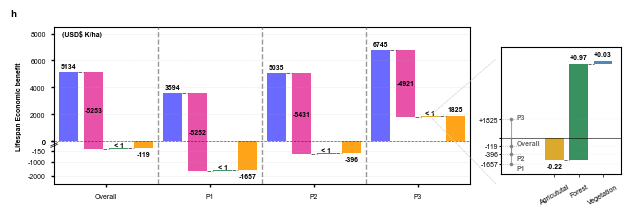

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.transforms import blended_transform_factory
from matplotlib.patches import Rectangle, FancyBboxPatch

# =========== 精简的辅助函数 ===========
def add_y_break_marks(ax, y_frac, *, width=0.008, half_len=0.01, gap=0.010, lw=0.5, color='k'):
    """在 y=y_frac 处画左侧断轴符号"""
    tr = ax.transAxes
    x0, x1 = 0.0 - width, 0.0 + width
    ax.plot([x0, x1], [y_frac - half_len, y_frac + half_len], transform=tr,
            color=color, lw=lw, clip_on=False, zorder=20)
    ax.plot([x0, x1], [y_frac - half_len - gap, y_frac + half_len - gap], transform=tr,
            color=color, lw=lw, clip_on=False, zorder=20)

def draw_bar_between(ax, x, v0, v1, color, width, y_transform, breaks=(-150.0, 0.0, 5.0), alpha=0.9):
    """在 v0→v1 之间按分段轴映射画段柱"""
    if v0 == v1:
        return
    pts = [v0] + [b for b in breaks if (v0 < b < v1) or (v1 < b < v0)] + [v1]
    pts.sort()
    for a, b in zip(pts[:-1], pts[1:]):
        yb, yt = y_transform(min(a, b)), y_transform(max(a, b))
        h = abs(yt - yb)
        if h > 0:
            ax.bar(x, h, width=width, bottom=min(yb, yt),
                   color=color, alpha=alpha, edgecolor='none', linewidth=0)

def draw_from_zero(ax, x, value_k, width, color, y_transform):
    draw_bar_between(ax, x, 0.0, value_k, color, width, y_transform)

def draw_from_end(ax, x, before_k, after_k, width, color, y_transform):
    draw_bar_between(ax, x, before_k, after_k, color, width, y_transform)

def draw_from_end_linear_signed(ax, x, before_k, after_k, width, ytr, color, alpha=0.95):
    """纯线性轴：以 before→after 画带符号高度的段柱"""
    yb, ya = ytr(before_k), ytr(after_k)
    h = ya - yb
    if abs(h) < 1e-12:
        return
    ax.bar(x, h, width=width, bottom=yb, color=color, alpha=alpha, edgecolor='none')

def build_linear_transform(vmin, vmax):
    span = max(vmax - vmin, 1e-9)
    return lambda v: (v - vmin) / span

def build_segmented_axis(values_for_extent, y_stretch_neg_max=-150.0, y_stretch_pos_max=0.0,
                         neg_stretch_ratio=0.06, pos_stretch_ratio=0.0, normal_ratio=0.94):
    """构建分段Y轴"""
    y_min = min(values_for_extent) * 1.6
    y_max = max(max(values_for_extent) * 1.08, 8500)

    lo_span = max(y_stretch_neg_max - y_min, 1e-9)
    neg_stretch_span = max(0.0 - y_stretch_neg_max, 1e-9)
    pos_stretch_span = max(y_stretch_pos_max - 0.0, 1e-9)
    hi_span = max(y_max - y_stretch_pos_max, 1e-9)

    total_normal_span = lo_span + hi_span
    lower_norm_ratio = (normal_ratio * (lo_span / total_normal_span)
                        if total_normal_span > 1e-9 else normal_ratio * 0.5)
    upper_norm_ratio = normal_ratio - lower_norm_ratio

    B0 = 0.0
    B1 = B0 + lower_norm_ratio
    B2 = B1 + neg_stretch_ratio
    B3 = B2 + pos_stretch_ratio
    B4 = 1.0

    def y_transform(v):
        if v <= y_stretch_neg_max:
            return B0 + (v - y_min) / lo_span * (B1 - B0)
        elif v <= 0.0:
            return B1 + (v - y_stretch_neg_max) / neg_stretch_span * (B2 - B1)
        elif v <= y_stretch_pos_max:
            return B2 + (v - 0.0) / pos_stretch_span * (B3 - B2)
        else:
            return B3 + (v - y_stretch_pos_max) / hi_span * (B4 - B3)

    ticks = [-1000.0, -2000.0, y_stretch_neg_max, 0.0, y_stretch_pos_max,
             2000.0, 4000.0, 6000.0, 8000.0]
    info = dict(y_min=y_min, y_max=y_max, y_stretch_neg_max=y_stretch_neg_max,
                y_stretch_pos_max=y_stretch_pos_max, B=(B0, B1, B2, B3, B4))
    return y_transform, ticks, info

# =========== 主函数 ===========
# 修改主函数中的关键部分：

def plot_waterfall_with_subplot(data, magnify_opp=15, figsize_mm=(140, 50)):
    """
    使用subplot形式：
    - 主图：保持当前尺寸
    - 辅图：压缩高度，避免重叠
    - 总宽度：140mm
    """
    # 数据准备
    K = 1000.0
    rev = [data['revenue'][f'{p}_Mean']/K for p in ['Overall', 'P1', 'P2', 'P3']]
    exp = [data['expenditure'][f'{p}_Mean']/K for p in ['Overall', 'P1', 'P2', 'P3']]
    net = [data['net'][f'{p}_Mean']/K for p in ['Overall', 'P1', 'P2', 'P3']]
    
    # 全局的Opportunity组成部分（用于辅图）
    ag_k = data.get('opportunity', {}).get('Agricultural_Mean', 0.0)/K
    fo_k = data.get('opportunity', {}).get('Forest_Mean', 0.0)/K
    ve_k = data.get('opportunity', {}).get('Vegetation_Mean', 0.0)/K
    
    after_exp = [rv - ex for rv, ex in zip(rev, exp)]
    
    # 构建分段Y轴
    extent_vals = rev + exp + net + after_exp + [ag_k, fo_k, ve_k, -150.0, 0.0]
    ytr, yticks, axinfo = build_segmented_axis(extent_vals)
    y0 = ytr(0.0)
    y0_main = ytr(0.0)
    net_end_axes_list = []
    # 创建画布和subplot - 调整布局避免重叠
    plt.rcParams['font.family'] = 'Arial'
    fig = plt.figure(figsize=(figsize_mm[0]/25.4, figsize_mm[1]/25.4))
    
    # 使用简单的subplot布局，避免复杂的GridSpec
    ax_main = fig.add_subplot(121)  # 1行2列，第1个
    ax_sub = fig.add_subplot(122)   # 1行2列，第2个
    
    # 手动调整subplot位置和大小
    # 主图：左边，占约75%宽度，全高度
    main_pos = [0.08, 0.1, 0.66, 0.8]  # [left, bottom, width, height]
    ax_main.set_position(main_pos)
    
    # 辅图：右边，占约25%宽度，高度压缩为1/3，位置在右上角
    sub_pos = [0.79, 0.15, 0.19, 0.65]  # [left, bottom, width, height]，右居中，高度压缩
    ax_sub.set_position(sub_pos)
    
    # =========== 主图绘制 ===========
    ax_main.set_ylim(0, 1)
    ax_main.set_yticks([ytr(v) for v in yticks])
    ax_main.tick_params(axis='y', length=2.5, width=0.5)
    ax_main.set_yticklabels([f'{v:.0f}' for v in yticks], fontsize=5)
    ax_main.axhline(y0, color='k', lw=0.5, ls='--', alpha=0.6)
    add_y_break_marks(ax_main, ytr(axinfo['y_stretch_neg_max'])+0.04)
    policies = ['Overall', 'P1', 'P2', 'P3']
    x_positions = list(range(4))  # 重命名避免冲突
    step, base_w = 0.24, 0.18
    col_rev, col_exp, col_net = '#5A5AFE', '#E63FA0', '#FF9900'
    col_opp = ['#DAA520', '#2E8B57', '#4682B4']

    # 存储P3 Opportunity的位置信息，用于绘制box和引线
    p3_opp_x = None
    p3_opp_y_bottom = None
    p3_opp_y_top = None

    for i, name in enumerate(policies):
        x = x_positions[i]

        # 保留注释的代码部分
        # # 获取政策特定的机会成本组成部分
        # if name == 'Overall':
        #     ag_k_policy = data.get('opportunity', {}).get('Agricultural_Mean', 0.0)/K
        #     fo_k_policy = data.get('opportunity', {}).get('Forest_Mean', 0.0)/K
        #     ve_k_policy = data.get('opportunity', {}).get('Vegetation_Mean', 0.0)/K
        # else:
        #     ag_k_policy = data.get('opportunity', {}).get(f'{name}_Agricultural_Mean', 0.0)/K
        #     fo_k_policy = data.get('opportunity', {}).get(f'{name}_Forest_Mean', 0.0)/K
        #     ve_k_policy = data.get('opportunity', {}).get(f'{name}_Vegetation_Mean', 0.0)/K

        # 统一使用 Overall 的机会成本构成
        ag_k_policy = ag_k
        fo_k_policy = fo_k
        ve_k_policy = ve_k

        # ---- Revenue ----
        x_rev = x - 1.5*step
        draw_from_zero(ax_main, x_rev, rev[i], base_w, col_rev, ytr)
        ax_main.text(x_rev, ytr(rev[i]) + 0.02, f'{rev[i]:.0f}',
                    ha='center', va='bottom', fontsize=5, fontweight='bold')

        # ---- Expenditure ----
        x_exp = x - 0.5*step
        draw_from_end(ax_main, x_exp, rev[i], after_exp[i], base_w, col_exp, ytr)
        exp_height = ytr(rev[i]) - ytr(after_exp[i])
        ax_main.text(x_exp, ytr(after_exp[i]) + exp_height/2, f'{-exp[i]:.0f}',
                    ha='center', va='center', fontsize=5, fontweight='bold')

        # ---- Opportunity（向上绘制，从after_exp[i]开始）----
        x_opp = x + 0.5*step
        parts = [-ag_k_policy*magnify_opp, -fo_k_policy*magnify_opp, -ve_k_policy*magnify_opp]

        # 先用 ytr 计算"原始"三段在轴坐标(0..1)下的高度
        y_bottom_axes = ytr(after_exp[i])  # 起始点：after_exp[i]
        seg_h_raw = []
        cur_data = after_exp[i]
        for p in parts:
            nxt_data = cur_data + p
            seg_h_raw.append(abs(ytr(nxt_data) - ytr(cur_data)))
            cur_data = nxt_data
        raw_total_h = sum(seg_h_raw)

        # 用 Overall 的 raw_total_h 作为全局目标高度
        if i == 0:              # Overall
            target_h_axes = raw_total_h
        # 对 P1/P2/P3，计算放大系数使总高度等于 Overall 的高度
        scale = 1.0 if raw_total_h < 1e-12 else (target_h_axes / raw_total_h)

        # 按比例缩放每段高度，并从 y_bottom_axes 向上堆叠画出
        cum = 0.0
        for h_raw, c in zip(seg_h_raw, col_opp):
            h_scaled = h_raw * scale
            bottom_axes = y_bottom_axes + cum
            ax_main.bar(x_opp, h_scaled, width=base_w, bottom=bottom_axes,
                        color=c, alpha=0.9, edgecolor='none', linewidth=0)
            cum += h_scaled

        # 机会成本标签：显示真实总值，不受缩放影响；位置用"显示几何"居中
        total_opp = -(ag_k_policy + fo_k_policy + ve_k_policy)
        label_txt = '< 1' if abs(total_opp) < 1 else f'{total_opp:.0f}'
        opp_end_axes = y_bottom_axes + target_h_axes  # 终点：起始点 + 总高度
        ax_main.text(x_opp, (y_bottom_axes + opp_end_axes)/2 + 0.02, label_txt,
                    ha='center', va='center', fontsize=5, fontweight='bold')

        # 记录 P3 位置（如需）
        if name == 'P3':
            p3_opp_x = x_opp
            p3_opp_y_bottom = y_bottom_axes
            p3_opp_y_top = opp_end_axes

        # ---- Net（终点与 opportunity 的"显示终点"对齐；标签仍是原始 net[i]）----
        x_net = x + 1.5*step
        net_end_axes_list.append(ytr(net[i]))
        net_start_axes = ytr(0.0)  # Net从0轴开始
        net_end_axes = opp_end_axes  # Net的终点与Opportunity的终点对齐
        net_height_axes = abs(net_end_axes - net_start_axes)
        net_bottom_axes = min(net_start_axes, net_end_axes)
        ax_main.bar(x_net, net_height_axes, width=base_w, bottom=net_bottom_axes,
                    color=col_net, alpha=0.9, edgecolor='none', linewidth=0)

        # Net的数据标签显示实际值（未放大的）
        ax_main.text(x_net, net_end_axes + (0.02 if net[i] >= 0 else -0.02), f'{net[i]:.0f}',
                    ha='center', va='bottom' if net[i] >= 0 else 'top',
                    fontsize=5, fontweight='bold')

        # 组内连线（保持水平）
        ax_main.plot([x_rev + base_w/2, x_exp - base_w/2], [ytr(rev[i]), ytr(rev[i])],
                    color='black', linestyle='--', lw=0.7, alpha=0.6)
        ax_main.plot([x_exp + base_w/2, x_opp - base_w/2], [ytr(after_exp[i]), ytr(after_exp[i])],
                    color='black', linestyle='--', lw=0.7, alpha=0.6)
        # Opportunity到Net：现在连接线是水平的（平行）
        ax_main.plot([x_opp + base_w/2, x_net - base_w/2], [opp_end_axes, opp_end_axes],
                    color='black', linestyle='--', lw=0.7, alpha=0.6)

    # 主图样式
    ax_main.set_xlim(-0.5, 3.5)
    ax_main.set_xticks(x_positions)  # 使用 x_positions
    ax_main.set_xticklabels(policies, fontsize=5)
    ax_main.set_ylabel('Lifespan Economic benefit', fontsize=5, fontweight='bold')
    ax_main.annotate('(USD$ K/ha)', xy=(0.02, 0.98), xycoords='axes fraction',
                     ha='left', va='top', fontweight='bold', fontsize=5, color='black')
    
    ax_main.tick_params(axis='both', labelsize=5, length=2.5, width=1)
    ax_main.spines['top'].set_visible(True)
    ax_main.spines['right'].set_visible(True)
    ax_main.grid(True, axis='y', linestyle='--', linewidth=0.4, alpha=0.3)

    # =========== 为P3 Opportunity绘制box和引线 ===========
    if p3_opp_x is not None:
        # 1) 画黑色细线框线，宽度扩大40%，降低zorder
        box_width = base_w * 1.12  # 0.8*1.4=1.12
        box_height = (p3_opp_y_top - p3_opp_y_bottom) * 1.4
        box_center_y = (p3_opp_y_top + p3_opp_y_bottom) / 2
        # box = FancyBboxPatch(
        #     (p3_opp_x - box_width/2, box_center_y - box_height/2),
        #     box_width, box_height,
        #     boxstyle="round,pad=0.01",
        #     facecolor='none', edgecolor='black', linewidth=1, zorder=2
        # )
        # ax_main.add_patch(box)

        # 2) 计算sub图数据框左上角和左下角的figure-fraction坐标
        sub_ax_bbox = ax_sub.get_position()  # figure-fraction 坐标
        # 柱状框的左侧x
        sub_bar_left = sub_ax_bbox.x0 
        sub_y_top = sub_ax_bbox.y1
        sub_y_bottom = sub_ax_bbox.y0

        # 3) 虚线分别指向sub数据框左上角和左下角（保持方向信息）
        ax_main.annotate(
            '',
            xy=(sub_bar_left, sub_y_top), xycoords='figure fraction',
            xytext=(p3_opp_x, p3_opp_y_top), textcoords=ax_main.transData,
            arrowprops=dict(arrowstyle='-', color='lightgray', lw=0.5, alpha=1, linestyle='--')
        )
        ax_main.annotate(
            '',
            xy=(sub_bar_left, sub_y_bottom), xycoords='figure fraction',
            xytext=(p3_opp_x, p3_opp_y_bottom), textcoords=ax_main.transData,
            arrowprops=dict(arrowstyle='-', color='lightgray', lw=0.5, alpha=1, linestyle='--')
        )
    

# 修改辅图绘制部分：

    # =========== 辅图绘制（压缩版）===========
    # Opportunity增量链
    d1, d2, d3 = -ag_k, -fo_k, -ve_k
    zvals = [0.0, d1, d1+d2, d1+d2+d3]
    zmin, zmax = min(zvals), max(zvals)
    span = max(zmax - zmin, 0.03)
    ztr = build_linear_transform(zmin - 0.15*span, zmax + 0.15*span)

    # 调整柱子位置，确保与文字标注不冲突
    xlim_left = -0.55                     # ← 可按需微调，越小左侧越宽
    ix_offset = 1.2                       # ← 柱子整体右移量（你关心的旋钮）
    ix = [ix_offset, ix_offset + 0.8, ix_offset + 1.6]
    bar_pad = 0.05
    xlim_right = ix[-1] + 0.5 + bar_pad   # 右边界随柱子更新即可

    # 更精确的宽度计算：考虑实际显示尺寸比例
    main_pos = ax_main.get_position()  # 主图位置
    sub_pos = ax_sub.get_position()    # 副图位置


    ax_sub.set_xlim(xlim_left, xlim_right)
    fig.canvas.draw()  



    # 综合计算：显示宽度比例 × 数据范围比例 × 主图柱子宽度
    # 每个坐标单位对应的像素数
    px_per_unit_main = (ax_main.transData.transform((1, 0))[0]
                        - ax_main.transData.transform((0, 0))[0])
    px_per_unit_sub  = (ax_sub.transData.transform((1, 0))[0]
                        - ax_sub.transData.transform((0, 0))[0])

    # 让视觉宽度一致
    bw = base_w * (px_per_unit_main / px_per_unit_sub)


    y0, y1, y2, y3 = 0.0, d1, d1+d2, d1+d2+d3

    # 绘制链式段柱
    draw_from_end_linear_signed(ax_sub, ix[0], y0, y1, bw, ztr, col_opp[0])
    draw_from_end_linear_signed(ax_sub, ix[1], y1, y2, bw, ztr, col_opp[1])
    draw_from_end_linear_signed(ax_sub, ix[2], y2, y3, bw, ztr, col_opp[2])

    # 端点虚线
    y1m, y2m = ztr(y1), ztr(y2)
    ax_sub.plot([ix[0]+bw/2, ix[1]-bw/2], [y1m, y1m], 'k--', lw=0.6, alpha=0.7)
    ax_sub.plot([ix[1]+bw/2, ix[2]-bw/2], [y2m, y2m], 'k--', lw=0.6, alpha=0.7)

    # 数值标注
    ax_sub.text(ix[0], ztr(y1)+(0.03 if y1>=0 else -0.03), f'{-ag_k:+.2f}',
            ha='center', va='bottom' if y1>=0 else 'top', fontsize=5, fontweight='bold', color='black')
    ax_sub.text(ix[1], ztr(y2)+(0.03 if (y2-y1)>=0 else -0.03), f'{-fo_k:+.2f}',
            ha='center', va='bottom' if (y2-y1)>=0 else 'top', fontsize=5, fontweight='bold', color='black')
    ax_sub.text(ix[2], ztr(y3)+(0.03 if (y3-y2)>=0 else -0.03), f'{-ve_k:+.2f}',
            ha='center', va='bottom' if (y3-y2)>=0 else 'top', fontsize=5, fontweight='bold', color='black')

    # =========== 四组起点标注（L形状线段，与主图Net柱子高度对应）===========
    y0 = ztr(0.0)  # 基线在当前子图坐标中的y值
    x_start = xlim_left
    label_gap_from_bar = 0.15  # 减少间距
    x_end   = ix[0] - label_gap_from_bar

    names  = ['Overall', 'P1', 'P2', 'P3']
    values = np.array(after_exp)

    # 计算主图中每个Net柱子的总视觉高度（包括标签和原点）
    net_total_heights = []
    for i, name in enumerate(policies):
        # 主图中Net柱子的实际高度
        net_height_main = abs(ytr(net[i]) - ytr(0.0))
        
        # 标签高度（大约0.02）
        label_height = 0.02
        
        # 原点高度（从0轴到Net柱子底部）
        origin_height = abs(ytr(0.0) - ytr(0.0))  # 原点在0轴，所以为0
        
        # 总视觉高度
        total_height = net_height_main + label_height + origin_height
        net_total_heights.append(total_height)

    # 按照数值从小到大排序
    sorted_pairs = sorted(zip(values, names, net_total_heights), key=lambda x: x[0])
    sorted_values, sorted_names, sorted_heights = zip(*sorted_pairs)

    # 根据主图Net柱子的总高度来设置L形状线段的长度
    # 将主图的高度映射到辅图的坐标系统
    max_main_height = max(net_total_heights)
    min_main_height = min(net_total_heights)

    # 在辅图中预留的空间（从基线向上和向下）
    sub_available_space = 0.6  # 辅图中可用的垂直空间

    # 计算每个L形状线段的长度（按比例缩放）
    l_segment_lengths = []
    for height in sorted_heights:
        # 将主图高度按比例缩放到辅图空间
        if max_main_height > min_main_height:
            normalized_height = (height - min_main_height) / (max_main_height - min_main_height)
        else:
            normalized_height = 0.5
        l_length = normalized_height * sub_available_space
        l_segment_lengths.append(l_length)

    # 计算L形状线段的位置
    y_positions = []
    for i, (value, l_length) in enumerate(zip(sorted_values, l_segment_lengths)):
        if value >= 0:
            # 正值：从基线向上
            y_pos = y0 + l_length
        else:
            # 负值：从基线向下
            y_pos = y0 - l_length
        y_positions.append(y_pos)

    # =========== L 形对齐 + 坐标轴对齐（与主图 Net 终点完全一致） ===========
    # 与主图同高的 0 轴
    y0_anchor = y0  # 使用辅图的y0，而不是未定义的y0_main
    ax_sub.axhline(y0_anchor, color='k', lw=0.6, ls='-', alpha=0.7, zorder=1)

    # L 区域和"火柴线"在副图左侧固定一块区域，和柱子脱钩
    x_start = xlim_left
    L_width = 0.65                        # ← L 区域固定宽度，按需调大/调小
    x_end   = x_start + L_width
    x_mid   = (x_start + x_end) / 2.0

    # 刻度位置 = [0] + 四个 net 终点（轴坐标）；刻度标签建议用数值，名字放在 L 形文字里
    names = ['Overall', 'P1', 'P2', 'P3']
    net_end_axes_list = [
    net_end_axes_list[0] ,  # Overall向上移动
    net_end_axes_list[1] ,  # P1向下移动
    net_end_axes_list[2] - 0.03,  # P2向下移动
    net_end_axes_list[3]    # P3向上移动
    ]

    tick_pos  = [y0_anchor] + net_end_axes_list
    tick_labs = [''] + [f'{v:+.0f}' for v in net]   # 0处不显示label

    ax_sub.set_yticks(tick_pos)
    ax_sub.set_yticklabels(tick_labs, fontsize=5)
    ax_sub.tick_params(axis='y', left=True, right=False, labelleft=True, length=2, pad=1.5)

    # 画 L 形到每个 net 终点（与 ytick 完全同高）
    # 轻微错位文字避免重叠（像素偏移：上/下/上/下）
    text_dy_pts = [2, -3, -3, 2]
    for (nm, y_pos, dy) in zip(names, net_end_axes_list, text_dy_pts):
        # 垂线（基线 -> 终点）
        ax_sub.plot([x_mid, x_mid], [y0_anchor, y_pos],
                    color='gray', linestyle='-', linewidth=0.8, alpha=0.7, zorder=4)
        # 火柴头
        ax_sub.plot(x_mid, y_pos, 'o', color='gray', markersize=1.6, alpha=0.9, zorder=5)
        # 横线（只画到 x_end）
        ax_sub.plot([x_start, x_end], [y_pos, y_pos],
                    color='gray', lw=0.5, ls=':', alpha=0.7, zorder=3)
        # 名称文字（与 ytick 分离，便于阅读）
        ax_sub.annotate(nm, xy=(x_mid, y_pos), xycoords='data',
                        xytext=(4, dy), textcoords='offset points',
                        ha='left', va='center', fontsize=5, color='dimgray', fontweight='bold', zorder=6)

    # 保持副图纵坐标范围 0..1
    ax_sub.set_ylim(0, 1)

    ax_sub.tick_params(axis='y', left=True, right=False, labelleft=True, length=1.5, pad=0.5)
    ax_sub.set_xlim(xlim_left, xlim_right + 0.05)

    # 辅图样式（压缩版）
    ax_sub.set_xticks(ix)
    ax_sub.tick_params(axis='x', length=2.5, width=0.5)
    ax_sub.set_xticklabels(['Agricututal', 'Forest', 'Vegetation'], fontsize=5, rotation=30, ha='center')
    ax_sub.set_ylim(0, 1)
    ax_sub.tick_params(axis='x', labelsize=5)
    ax_sub.spines['top'].set_visible(True)
    ax_sub.spines['right'].set_visible(True)
    ax_sub.grid(True, alpha=0.3, linestyle='--', linewidth=0.2, axis='y', zorder=0)

    # Revenue, Expenditure, Opportunity, Net 的中心位置
    group_centers = []
    for i, name in enumerate(policies):
        x = x_positions[i]  # 使用 x_positions 而不是 x_pos
        group_centers.append({
            'Revenue': x - 1.5*step,
            'Expenditure': x - 0.5*step, 
            'Opportunity': x + 0.5*step,
            'Net': x + 1.5*step
        })

    # =========== 政策组间分界线 ===========
    # 在政策组之间绘制分界线（Overall与P1，P1与P2，P2与P3之间）
    if len(policies) > 1:
        for i in range(len(policies) - 1):
            # 计算两个相邻政策组的中点位置
            sep_x = (x_positions[i] + x_positions[i + 1]) / 2
            ax_main.axvline(sep_x, color='gray', linestyle='--', linewidth=1, alpha=0.8, zorder=5)

    # 角标
    fig.text(0.01, 0.99, 'h', ha='left', va='top', fontsize=7, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.85, pad=0, lw=0))
    
    return fig, (ax_main, ax_sub)

# 使用
fig, (ax_main, ax_sub) = plot_waterfall_with_subplot(benefit_data_fixed, magnify_opp=15, figsize_mm=(160, 50))
fig.savefig('figure/US_figure/US_waterfall.png', dpi=300)
fig.savefig('figure/US_figure/US_waterfall.pdf', dpi=300)
plt.show()

## 4.1 图1：经济折线图

Logic: 

总共有三张图：

第一是机会成本：机会成本按照C1-C7进行划分；
第二是政策收益：政策收益按照P1-P3进行归类；
第三是累积路线：全生命周期的累积路线；

政策收益：

修改一下，对于坐标轴line和xticks统一为黑色、width==2。 数据标签为12号字体，黑色bold。其次，我需要按照P1,P2,P3进行Group绘制曲线（三张折线图，横版放置）。以P1 Group为例，首先：绘制每个pixel对应的analysis_year	==2020, 2030, 2040, 2050的'net_npv_usd'。用#CCCCCC配色进行绘制。其次，对于所有的pixel各个年份计算对应analysis_year的mean，并且形成曲线。利用#4E4EFF配色，其置信区间使用#CCCCFF。P2, P3group按照类似的逻辑，但是对于mean曲线分别采用P2：#359A35（mean主线），#CCE6CC(置信区间)，具体曲线#CCCCCC。P3：#FFBA3D(mean主线)，#FFEDCC（置信区间）。一般pixel级别曲线都使用用#CCCCCC配色

以上3个group置信区间用95% CI 计算，不要用SD或者SE。


机会收益：

对于坐标轴line和xticks统一为黑色、width==2，字体为Arial。数据标签为12号字体，黑色bold。其次，我需要你绘制一张机会成本的柱状堆积图（带误差棒，图幅fig大概是（6，5）），去观察P1,P2,P3三大类政策中，df_agricultural_npv，df_afforestation_npv，df_natural_npv机会收益是占比如何（只需要到analysis_year==2050）。变量名称都是['cumulative_npv_usd']。

在执行之前，你需要创建双重映射，第一重映射是提取df_economic['policy_category']到'rcp_category'的unique group，然后将df_agricultural_npv，df_afforestation_npv，df_natural_npv中的'rcp_category'（每个变量都有RCP2.6, 4.5, 6.0, 6.5, df_agricultural_npv列名叫做RCP_Category，可以都对列名小写后查询）与df_economic['policy_category']进行匹配。这样就实现了每个row有对应的三类成本数据。这个映射大致应该如下执行：（1）按照rcpmapping的逻辑，先匹配df_economic['pv_category']。（2）获取df_economic['policy_category']与df_economic['pv_category']的unique组合，进而建立df_economic['pv_category']，df_economic['policy_category']，各个变量rcp_category的联系。
rcp_mapping = {
        'C1': 'RCP2.6', 'C2': 'RCP2.6', 'C3': 'RCP2.6',
        'C4': 'RCP4.5',
        'C5': 'RCP6.0', 
        'C6': 'RCP8.5', 'C7': 'RCP8.5', 'C8': 'RCP8.5'
    }



第二重映射是为了聚类，本质上是要把unique group中按照policy_category各个小类合并成大类的P1,P2,P3，类似于match_policy，但是可以用考虑字符串匹配，（用mean聚合）
    def match_policy(val):
        s = str(val)
        if 'P1' in s: return 'P1'
        if 'P2' in s: return 'P2'
        if 'P3' in s: return 'P3'
        return 'Other'
    

累积路线：




In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch
from matplotlib.collections import LineCollection
from scipy import stats
from tqdm.auto import tqdm

def create_policy_scenarios_analysis(df_economic):
    """
    修复版本：
    - Y轴标题标注10^3单位
    - 图例在各图左上角，向下移动
    - 均值线在图例中显示
    - 修复红线范围，只到2050
    - 优化P1的Y轴，压缩-500,000到0区间
    - 优化：使用已有的py变量计算30年平均值，避免重复计算
    """
    def match_policy(val):
        s = str(val)
        if 'P1' in s: return 'P1'
        if 'P2' in s: return 'P2'
        if 'P3' in s: return 'P3'
        return 'Other'

    df = df_economic.copy()
    df['policy_group'] = df['policy_category'].astype(str).apply(match_policy)
    df = df[df['policy_group'].isin(['P1','P2','P3'])]

    years = np.sort(df['analysis_year'].unique())
    policy_groups = ['P1','P2','P3']

    # 设置字体为Arial
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.sans-serif'] = ['Arial']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    # 使用当前颜色方案（P2 mean为洋红，P3 mean为紫色系）
    colors = {
        'P1': dict(mean='#4E4EFF', ci='#6B6BFF', pixel='#BBBBBB', 
                   band_75='#E6E6FF'),
        'P2': dict(mean='#E6007A', ci='#FF4FA3', pixel='#BBBBBB', 
                   band_75='#F9D1E6'),  # mean洋红，ci亮洋红，带淡粉
        'P3': dict(mean='#8B3EFF', ci='#B266FF', pixel='#BBBBBB', 
                   band_75='#E6D6FF')   # mean紫色，ci淡紫，带淡紫
    }

    # ==================== 新增：计算各政策情景30年平均NPV和标准误 ====================
    print("="*80)
    print("各政策情景30年期间平均NPV统计分析")
    print("="*80)
    
    policy_npv_stats = {}
    
    for ax, policy in zip(axes, policy_groups):
        g = df[df['policy_group'] == policy]
        if g.empty:
            ax.text(0.5,0.5,f'No data for {policy}', ha='center', va='center', transform=ax.transAxes)
            continue

        # —— 统一到"像素-年份"样本 —— #
        py = (g.groupby(['lat','lon','analysis_year'], as_index=False)['net_npv_usd']
              .mean())

        # ==================== 使用py变量计算30年平均值 ====================
        # 第一步：按年份计算均值
        year_means = (py.groupby('analysis_year')['net_npv_usd']
                     .mean()
                     .reindex(years))
        
        # 第二步：计算30年期间的平均值
        overall_mean = year_means.mean()
        
        # 第三步：计算30年期间的标准差（年份间的变异）
        overall_std = year_means.std(ddof=1)
        
        # 第四步：计算标准误（年份间标准差除以年份数量的平方根）
        n_years = len(years)
        standard_error = overall_std / np.sqrt(n_years)
        
        # 计算95%置信区间
        confidence_interval_95 = 1.96 * standard_error
        
        # 存储统计结果
        policy_npv_stats[policy] = {
            'n_years': n_years,
            'overall_mean': overall_mean,
            'overall_std': overall_std,
            'standard_error': standard_error,
            'ci_95_lower': overall_mean - confidence_interval_95,
            'ci_95_upper': overall_mean + confidence_interval_95,
            'year_means': year_means  # 保存年份均值用于绘图
        }
        
        # 打印结果
        print(f"\n{policy} 政策情景:")
        print(f"  年份数量: {n_years}")
        print(f"  30年平均NPV: {overall_mean:,.2f} USD/ha")
        print(f"  年份间标准差: {overall_std:,.2f} USD/ha")
        print(f"  标准误: {standard_error:,.2f} USD/ha")
        print(f"  95%置信区间: [{overall_mean - confidence_interval_95:,.2f}, {overall_mean + confidence_interval_95:,.2f}] USD/ha")
        
        # 打印各年份的均值
        print(f"  各年份均值:")
        for year, mean_val in year_means.items():
            print(f"    {year}: {mean_val:,.2f} USD/ha")
        
        # 转换为更易读的单位
        if abs(overall_mean) >= 1e6:
            print(f"  30年平均NPV: {overall_mean/1e6:.3f} M USD/ha")
        elif abs(overall_mean) >= 1e3:
            print(f"  30年平均NPV: {overall_mean/1e3:.3f} K USD/ha")
        
        if abs(standard_error) >= 1e6:
            print(f"  标准误: {standard_error/1e6:.3f} M USD/ha")
        elif abs(standard_error) >= 1e3:
            print(f"  标准误: {standard_error/1e3:.3f} K USD/ha")

        # —— 像素曲线（极低透明度） —— #
        pivot = (py.pivot_table(index=['lat','lon'], columns='analysis_year',
                                values='net_npv_usd', aggfunc='mean')
                 .reset_index())

        segs = []
        for _, row in pivot.iterrows():
            xs, ys = [], []
            for y in years:
                v = row.get(y, np.nan)
                if pd.notna(v):
                    xs.append(float(y)); ys.append(float(v))
            if len(xs) > 1:
                segs.append(np.column_stack([xs, ys]))
        if segs:
            lc = LineCollection(segs, colors=colors[policy]['pixel'],
                                linewidths=0.25, alpha=0.04, zorder=1)
            lc.set_rasterized(True)
            ax.add_collection(lc)

        # —— 只显示25-75%分位数带 —— #
        q = (py.groupby('analysis_year')['net_npv_usd']
               .quantile([0.25,0.75]).unstack())
        q = q.reindex(years)
        x  = q.index.to_numpy(dtype=float)
        q25, q75 = [q[c].to_numpy(dtype=float) for c in [0.25,0.75]]

        # 25-75%分位数带
        ax.fill_between(x, q25, q75, color=colors[policy]['band_75'], 
                        alpha=1, zorder=3, linewidth=0)

        # —— 均值线 —— #
        # 直接使用已计算的年份均值
        x_ci = years
        mu = year_means.values
        
        # 均值线
        mean_line, = ax.plot(x_ci, mu, color=colors[policy]['mean'], linewidth=3,
                marker='o', markersize=7, label=f'{policy} Mean', zorder=12)

        # —— 轴样式 —— #
        ax.set_title(policy, fontsize=14, fontweight='bold', color='black', pad=10)
        ax.grid(True, alpha=0.25, linewidth=0.5, zorder=0)
        ax.set_axisbelow(True)
        ax.tick_params(axis='both', labelsize=12, width=1.5, colors='black')
        ax.set_xticks(years)
        ax.set_xticklabels(years, fontweight='bold')

        # 0 线 - 只到2050年
        ax.axhline(0, color='#FF1744', linestyle='--', linewidth=2, alpha=0.8, zorder=20, 
                   xmin=0, xmax=1)  # 确保只到x轴范围

        # y轴单位格式：以千为单位显示，千分位分隔
        def yfmt(v, pos):
            return f'{v/1000:,.0f}'
        ax.yaxis.set_major_formatter(FuncFormatter(yfmt))

        # 智能y轴范围：结合单位缩放，自动对齐主刻度
        vals = py['net_npv_usd'].to_numpy()
        data_min, data_max = np.nanmin(vals), np.nanmax(vals)
        q01, q99 = np.nanpercentile(vals, [1, 99])

        # 以千为单位，主刻度间隔自动适配
        def nice_ticks(lo, hi, step=500_000):
            ticks = np.arange(np.floor(lo/step)*step, np.ceil(hi/step)*step+1, step)
            return ticks[(ticks >= lo) & (ticks <= hi)]

        if policy == 'P1':
            # P1: 负值主导，压缩-500,000到0区间，主刻度每50万
            lo = min(q01, data_min) - 0.1e6
            hi = max(q99, 0.1e6) + 0.5e6
            ax.set_ylim(lo, hi)
            ax.set_yticks(nice_ticks(lo, hi, 500_000))
            
        elif policy == 'P2':
            # P2从负值到正值，确保完整显示
            lo = min(q01, data_min) - 0.2e6
            hi = max(data_min, data_max) + 0.2e6
            ax.set_ylim(lo, hi)
            
        elif policy == 'P3':
            # P3主要是正值，确保完整显示
            lo = min(data_min, -0.5e6)- 0.3e6
            hi = max(q99, data_max) + 0.3e6
            ax.set_ylim(lo, hi)

        # 合并图例：均值线 + 分位数带颜色块，确保所有均值线都显示
        legend_handles = [
            mean_line,  # 均值线
            Patch(facecolor=colors[policy]['band_75'], alpha=0.8, label='25–75% quantile')
        ]
        # 设置bbox_to_anchor时无需再指定loc，直接用bbox_to_anchor精确定位图例
        ax.legend(
            handles=legend_handles,
            loc='upper left',
            bbox_to_anchor=(0.02, 1),
            fontsize=11,
            frameon=True,
            framealpha=0.9,
            borderaxespad=0.
        )

    # 计算政策情景间的比较
    print("\n" + "="*80)
    print("政策情景间比较分析")
    print("="*80)
    
    valid_policies = {k: v for k, v in policy_npv_stats.items() if v is not None}
    
    if len(valid_policies) > 1:
        # 计算均值排序
        sorted_policies = sorted(valid_policies.items(), 
                               key=lambda x: x[1]['overall_mean'], 
                               reverse=True)
        
        print("\n按30年平均NPV排序:")
        for i, (policy, stats) in enumerate(sorted_policies, 1):
            print(f"  {i}. {policy}: {stats['overall_mean']:,.2f} ± {stats['standard_error']:,.2f} USD/ha")
        
        # 计算政策间的差异显著性
        print("\n政策间差异分析:")
        policy_names = list(valid_policies.keys())
        for i in range(len(policy_names)):
            for j in range(i+1, len(policy_names)):
                policy1, policy2 = policy_names[i], policy_names[j]
                stats1, stats2 = valid_policies[policy1], valid_policies[policy2]
                
                mean_diff = stats1['overall_mean'] - stats2['overall_mean']
                se_diff = np.sqrt(stats1['standard_error']**2 + stats2['standard_error']**2)
                
                # 计算t统计量和p值（简化版本）
                t_stat = mean_diff / se_diff
                # 使用正态分布近似计算p值
                # # 修正：scipy.stats.norm.cdf
                # p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))  # <-- 错误行

                # 修正如下：
                # p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))
                # stats 是 dict, 不是 scipy.stats
                # 应该用 scipy.stats.norm.cdf
                from scipy.stats import norm
                p_value = 2 * (1 - norm.cdf(abs(t_stat)))
                
                print(f"  {policy1} vs {policy2}: {mean_diff:+,.2f} ± {se_diff:,.2f} USD/ha")
                print(f"    t-stat: {t_stat:.3f}, p-value: {p_value:.4f}")
                
                # 判断显著性
                if p_value < 0.001:
                    significance = "***"
                elif p_value < 0.01:
                    significance = "**"
                elif p_value < 0.05:
                    significance = "*"
                else:
                    significance = "ns"
                print(f"    显著性: {significance}")
    
    print("\n" + "="*80)

    # 公共标签与布局 - Y轴标题标注10^3单位
    axes[0].set_ylabel('Net NPV (USD/ha) × 10³', fontsize=12, fontweight='bold', color='black')
    
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        for side in ['left','bottom']:
            ax.spines[side].set_linewidth(1.8)
            ax.spines[side].set_color('black')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88, wspace=0.2)
    
    # 返回统计结果和图形
    return fig, axes, policy_npv_stats

# 使用优化版本
fig_policy, axes_policy, npv_stats = create_policy_scenarios_analysis(df_economic)

# 保存图片
fig_policy.savefig('figure/US_figure/Figure_policy_scenarios_analysis.eps', 
                   bbox_inches='tight', dpi=300, format='eps')
fig_policy.savefig('figure/US_figure/Figure_policy_scenarios_analysis.png', 
                   bbox_inches='tight', dpi=300, format='png')

plt.show()

print("优化版本政策情景分析图创建完成！")




各政策情景30年期间平均NPV统计分析

P1 政策情景:
  年份数量: 4
  30年平均NPV: -1,995,805.12 USD/ha
  年份间标准差: 283,213.68 USD/ha
  标准误: 141,606.84 USD/ha
  95%置信区间: [-2,273,354.52, -1,718,255.71] USD/ha
  各年份均值:
    2020: -2,257,879.91 USD/ha
    2030: -2,198,755.93 USD/ha
    2040: -1,869,672.14 USD/ha
    2050: -1,656,912.50 USD/ha
  30年平均NPV: -1.996 M USD/ha
  标准误: 141.607 K USD/ha

P2 政策情景:
  年份数量: 4
  30年平均NPV: -1,206,625.48 USD/ha
  年份间标准差: 769,225.07 USD/ha
  标准误: 384,612.53 USD/ha
  95%置信区间: [-1,960,466.05, -452,784.92] USD/ha
  各年份均值:
    2020: -2,133,221.85 USD/ha
    2030: -1,503,959.57 USD/ha
    2040: -793,570.25 USD/ha
    2050: -395,750.27 USD/ha
  30年平均NPV: -1.207 M USD/ha
  标准误: 384.613 K USD/ha

P3 政策情景:
  年份数量: 4
  30年平均NPV: 110,692.00 USD/ha
  年份间标准差: 1,717,830.03 USD/ha
  标准误: 858,915.01 USD/ha
  95%置信区间: [-1,572,781.42, 1,794,165.43] USD/ha
  各年份均值:
    2020: -2,063,747.26 USD/ha
    2030: -394,190.70 USD/ha
    2040: 1,075,957.30 USD/ha
    2050: 1,824,748.67 USD/ha
  30年平均NPV: 110.692 K US

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


In [79]:
df_economic

,lat,lon,pv_category,pv_model,pv_scenario,policy_category,rcp_category,net_npv_usd,net_cost_usd,analysis_year
0,31.320833,-105.929170,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364320e+06,2.364320e+06,2020
1,31.329166,-105.929170,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364268e+06,2.364268e+06,2020
2,31.337500,-105.937500,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364232e+06,2.364232e+06,2020
3,31.337500,-105.929170,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364223e+06,2.364223e+06,2020
4,31.345833,-105.937500,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364196e+06,2.364196e+06,2020
...,...,...,...,...,...,...,...,...,...,...
68880915,46.937500,-67.920830,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.447125e+06,4.654054e+06,2050
68880916,47.145832,-67.962500,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.148731e+06,4.654008e+06,2050
68880917,47.237500,-68.620834,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.294753e+06,4.654032e+06,2050
68880918,47.254166,-68.354164,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.331141e+06,4.654020e+06,2050


In [80]:
df_climate_zone['State'].unique()

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UM', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI',
       'WV', 'WY'], dtype=object)

## 4.3 图3：多情景的政策累积路线

进一步细分不同政策情景（P1,P2,P3, average）之下的单目标累积路线+各个州average policy情况下的柱状堆积图

具体逻辑是：
第一步：数据准备

（1），按照create_opportunity_cost_unified函数的P1,P2,P3 group方法，只关注analysis_year==2050，并为每个pixel挂上states_simple = us_states_4326[['NAME','STUSPS', 'geometry']].copy()字段。在这个操作中，实际上不需要挂上df_natural,df_agri，df_forest等成本信息，只要关注net_npv_usd的值就可以了

（2），聚合子类对应得出每个pixel中['net_npv_usd'] P1.mean, P2.mean, P3.mean, 以及 P1,P2,P3所有政策group的total.mean（这里实际上存在P4，在计算mean的时候也要考虑这个group，但是由于其样本过少，不参与polciy group独立分析，不过要加入总体均值）。

第三，按照area_data = df_net_benefit[['lat', 'lon', 'area_m2']].copy()中的lat lon字段进行merge赋予pixel面积信息。并且利用P1.mean, P2.mean, P3.mean，total.mean针对每个pixel计算['area_m2']*四个值等到累积收益。

第二步：计算与绘图

（1）按照create_cross_target_analysis函数进行累积，但是不需要按照ccd进行排序，以total.mean为x轴基准进行排序累积（要求从分位数从高到低进行累积）。最终得到四条曲线。（从最大值累加到最小值，但是x轴额外设置，需要固定类似3%，10%，...100%的priority percentile排列），由此生成polciy_group P1, P2, P3三个政策类别的累积路线图。

（2）按照各个STUSPS挂上的state信息，再以州为单位，每个pixel按照total.mean在各自州内（从分位数从高到低进行累积）。绘制州的堆积柱状图（分bin可以跟着分位数的轴来决定、尽量保持连续）






布局：
所有字体arial ； X、Y轴要求linewith==2，xtick fonsize==12 , bold ； y tick fontsize ==12 , 不用bold加粗。图幅控制figsize控制在8,4。




开始执行政策情景累积分析（修正版）...
开始政策情景累积分析（修正版）...
1. 数据预处理...
2. 按pixel聚合数据...
聚合后数据: 64982 行
数据准备完成
面积单位: 公顷 (ha)
数据范围检查:
  P1: -2.58e+06 到 -4.46e+04
  P2: -1.69e+06 到 1.86e+06
  P3: 8.84e+04 到 4.85e+06
  total_mean: -1.44e+06 到 2.18e+06
3. 开始绘图...
绘制累积路线图...
P1累积值范围: -7.21e+12 到 0.00e+00
P2累积值范围: -1.67e+12 到 3.86e+11
P3累积值范围: 0.00e+00 到 8.07e+12
Total累积值范围: -4.59e+11 到 6.98e+11
Total累积标准误: 1.89e+04
绘制州堆积图...

=== 总体标准误信息 ===
Total累积标准误: 1.89e+04
Total累积标准误 (显示单位): 0.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


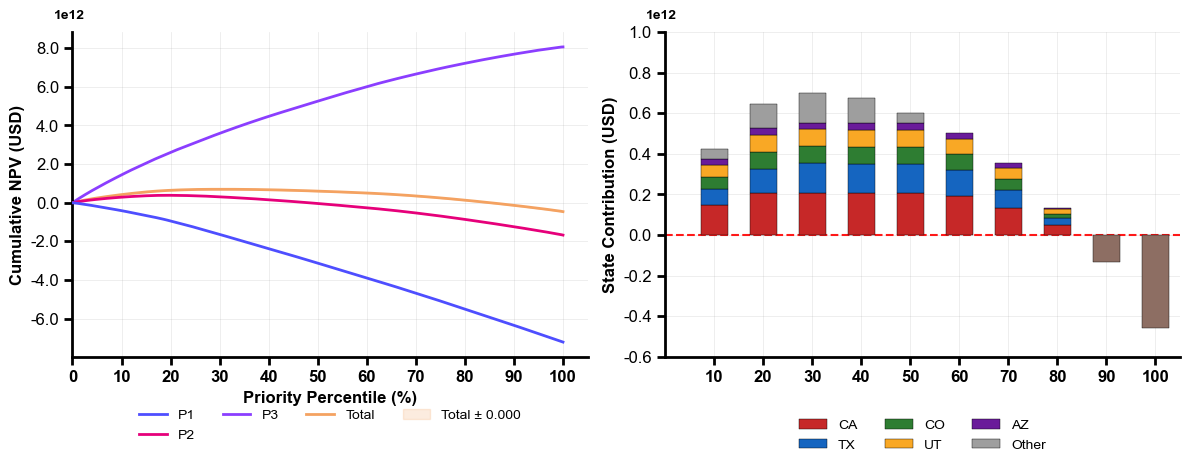

政策情景累积分析图（修正版）创建完成！


In [7]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def create_policy_cumulative_analysis_simple(df_economic, us_states_4326, df_net_benefit):
    """
    创建政策情景累积分析图：P1,P2,P3累积路线 + 各州柱状堆积图
    修正版本：确保与create_cross_target_analysis的数据处理一致
    """
    # 设置字体
    plt.rcParams['font.family'] = 'Arial'
    
    print("开始政策情景累积分析（修正版）...")
    
    # 第一步：数据准备
    print("1. 数据预处理...")
    
    # RCP映射
    rcp_mapping = {
        'C1': 'RCP2.6', 'C2': 'RCP2.6', 'C3': 'RCP2.6',
        'C4': 'RCP4.5', 'C5': 'RCP6.0', 
        'C6': 'RCP8.5', 'C7': 'RCP8.5', 'C8': 'RCP8.5'
    }
    
    # 处理df_economic，只关注net_npv_usd
    df_economic_2050 = df_economic[df_economic['analysis_year'] == 2050].copy()
    df_economic_2050['mapped_rcp'] = df_economic_2050['pv_category'].map(rcp_mapping)
    df_economic_2050['policy_group'] = df_economic_2050['policy_category'].str.extract(r'(P[1234])')[0]
    
    # 过滤有效数据（包括P4用于总体均值计算）
    valid_mask = df_economic_2050['policy_group'].isin(['P1', 'P2', 'P3', 'P4'])
    df_economic_2050 = df_economic_2050[valid_mask]
    
    # 关键修正：先按pixel聚合，再处理policy_group
    print("2. 按pixel聚合数据...")
    
    # 先按lat, lon聚合所有policy_group的net_npv_usd
    pixel_agg = df_economic_2050.groupby(['lat', 'lon']).agg({
        'net_npv_usd': 'mean'  # 每个pixel的平均值
    }).reset_index()
    
    # 再按policy_group聚合
    policy_agg = df_economic_2050.groupby(['lat', 'lon', 'policy_group']).agg({
        'net_npv_usd': 'mean'
    }).reset_index()
    
    # 透视表：每个pixel的P1, P2, P3, total均值
    pixel_pivot = policy_agg.pivot_table(
        index=['lat', 'lon'], 
        columns='policy_group', 
        values='net_npv_usd', 
        aggfunc='mean'
    ).reset_index()
    
    # 添加总体均值（每个pixel的平均值）
    pixel_pivot = pixel_pivot.merge(pixel_agg, on=['lat', 'lon'], how='inner')
    pixel_pivot.rename(columns={'net_npv_usd': 'total_mean'}, inplace=True)
    
    print(f"聚合后数据: {len(pixel_pivot)} 行")
    
    # 添加面积信息
    area_data = df_net_benefit[['lat', 'lon', 'area_m2']].copy()
    pixel_final = pixel_pivot.merge(area_data, on=['lat', 'lon'], how='inner')
    
    # 关键修正：面积单位转换，与create_cross_target_analysis保持一致
    pixel_final['area_ha'] = pixel_final['area_m2'] / 10000  # 转换为公顷
    
    # 计算累积收益（面积 * net_npv_usd）- 使用公顷单位
    for col in ['P1', 'P2', 'P3', 'total_mean']:
        if col in pixel_final.columns:
            pixel_final[f'{col}_cumulative'] = pixel_final[col] * pixel_final['area_ha']
    
    print("数据准备完成")
    print(f"面积单位: 公顷 (ha)")
    print(f"数据范围检查:")
    for col in ['P1', 'P2', 'P3', 'total_mean']:
        if col in pixel_final.columns:
            print(f"  {col}: {pixel_final[col].min():.2e} 到 {pixel_final[col].max():.2e}")
    
    # 第二步：计算与绘图
    print("3. 开始绘图...")
    
    # 创建图形：累积路线图 + 州堆积图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # 累积路线图
    print("绘制累积路线图...")
    total_std_error = plot_cumulative_curves_simple(ax1, pixel_final)  # 接收返回值
    
    # 州堆积图
    print("绘制州堆积图...")
    plot_state_stacked_bars_combined(ax2, pixel_final, us_states_4326, None, x_max=105)
    
    # 在主函数中也打印标准误信息
    print(f"\n=== 总体标准误信息 ===")
    print(f"Total累积标准误: {total_std_error:.2e}")
    print(f"Total累积标准误 (显示单位): {total_std_error/1e12:.6f}")
    
    plt.tight_layout()
    # 去掉上方和右边框线，对两幅图执行相同操作
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    return fig, (ax1, ax2)

def plot_cumulative_curves_simple(ax, pixel_final):
    """绘制P1, P2, P3累积路线图，并计算total的标准误"""
    # 按total_mean排序（从高到低）
    sorted_data = pixel_final.sort_values('total_mean_cumulative', ascending=False)
    
    # 计算累积百分比
    total_pixels = len(sorted_data)
    cumulative_percentage = np.arange(1, total_pixels + 1) / total_pixels * 100
    
    # 计算累积值
    p1_values = sorted_data['P1_cumulative'].fillna(0)
    p2_values = sorted_data['P2_cumulative'].fillna(0)
    p3_values = sorted_data['P3_cumulative'].fillna(0)
    total_values = sorted_data['total_mean_cumulative'].fillna(0)
    
    # 累积计算
    p1_cumulative = np.cumsum(p1_values)
    p2_cumulative = np.cumsum(p2_values)
    p3_cumulative = np.cumsum(p3_values)
    total_cumulative = np.cumsum(total_values)
    
    # 添加起始点
    cumulative_percentage = np.concatenate([[0], cumulative_percentage])
    p1_cumulative = np.concatenate([[0], p1_cumulative])
    p2_cumulative = np.concatenate([[0], p2_cumulative])
    p3_cumulative = np.concatenate([[0], p3_cumulative])
    total_cumulative = np.concatenate([[0], total_cumulative])
    
    # 计算total累积的标准误
    def calculate_cumulative_std_error(cumulative_values, cumulative_percentage):
        """基于样本贡献计算累积值的标准误"""
        # 将百分比转换为[0,1]区间
        x_01 = cumulative_percentage / 100.0
        
        # 计算每个小段的贡献
        n_segments = len(cumulative_values) - 1
        if n_segments > 1:
            segment_contributions = []
            for i in range(n_segments):
                dx = x_01[i+1] - x_01[i]
                avg_y = (cumulative_values[i+1] + cumulative_values[i]) / 2.0
                contribution = avg_y * dx
                segment_contributions.append(contribution)
            
            # 基于贡献计算标准误
            contribution_std = np.std(segment_contributions, ddof=1)
            contribution_std_error = contribution_std / np.sqrt(n_segments)
        else:
            contribution_std_error = 0
        
        return contribution_std_error
    
    # 计算total累积的标准误
    total_std_error = calculate_cumulative_std_error(total_cumulative, cumulative_percentage)
    
    # 打印累积值范围和标准误
    print(f"P1累积值范围: {p1_cumulative.min():.2e} 到 {p1_cumulative.max():.2e}")
    print(f"P2累积值范围: {p2_cumulative.min():.2e} 到 {p2_cumulative.max():.2e}")
    print(f"P3累积值范围: {p3_cumulative.min():.2e} 到 {p3_cumulative.max():.2e}")
    print(f"Total累积值范围: {total_cumulative.min():.2e} 到 {total_cumulative.max():.2e}")
    print(f"Total累积标准误: {total_std_error:.2e}")
    
    # 使用自定义颜色
    colors = {
        'P1': '#4E4EFF',
        'P2': '#E6007A',
        'P3': '#8B3EFF',
        'Total': '#F4A261'
    }
    
    # 绘制主要曲线
    ax.plot(cumulative_percentage, p1_cumulative/1e12, color=colors['P1'], linewidth=2, label='P1', zorder=4)
    ax.plot(cumulative_percentage, p2_cumulative/1e12, color=colors['P2'], linewidth=2, label='P2', zorder=3)
    ax.plot(cumulative_percentage, p3_cumulative/1e12, color=colors['P3'], linewidth=2, label='P3', zorder=2)
    ax.plot(cumulative_percentage, total_cumulative/1e12, color=colors['Total'], linewidth=2, label='Total', zorder=1)
    
    # 添加Total曲线的标准误区间（阴影区域）
    total_std_error_display = total_std_error / 1e12  # 转换为显示单位
    ax.fill_between(cumulative_percentage, 
                    (total_cumulative/1e12) - total_std_error_display,
                    (total_cumulative/1e12) + total_std_error_display,
                    color=colors['Total'], alpha=0.2, zorder=0, 
                    label=f'Total ± {total_std_error_display:.3f}')
    
    # 设置X轴，Xmax=105但只显示到100
    key_percentages = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    ax.set_xticks(key_percentages)
    ax.set_xticklabels([f'{p}' for p in key_percentages], fontsize=12, fontweight='bold')
    ax.set_xlim(0, 105)  # 留出呼吸感但不显示105标签
    ax.set_xlabel('Priority Percentile (%)', fontsize=12, fontweight='bold')
    
    # 设置Y轴
    ax.set_ylabel('Cumulative NPV (USD)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='y', labelsize=12)
    
    # Y轴标签显示为普通数字（因为已经除以1e12了）
    def sci_fmt_left(x, pos):
        return f'{x:.1f}'
    ax.yaxis.set_major_formatter(FuncFormatter(sci_fmt_left))
    
    # 在Y轴顶部加1e12的单位标注
    ax.annotate('1e12', xy=(-0.05, 1.05), xycoords='axes fraction', xytext=(5, 0),
                textcoords='offset points', ha='left', va='center',
                fontsize=10, fontweight='bold', color='black')
    
    # 网格和样式
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
    ax.set_axisbelow(True)
    
    # 坐标轴样式
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')
    # 去掉上方和右边框线
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.tick_params(axis='both', which='major', width=2, size=6)
    
    # 图例
    ax.legend(fontsize=10, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=4, frameon=False, title=None)
    
    # 返回标准误信息供外部使用
    return total_std_error
    

def plot_state_stacked_bars_combined(ax, pixel_final, us_states_4326, left_y_limits, x_max=105):
    """
    右轴：按分位点动态堆积
      - 若 net >= 0：只画正柱，并按 r = net/pos 等比压缩（负值不单独显示）
      - 若 net < 0 ：正柱为 0；负柱开始向下累计，总高度 = -net，
                    每个负州用 g = (-net)/|neg_sum| 等比分摊；负柱统一颜色
    这样每个分位点柱总高度 == 左轴 Total 曲线在该分位点的累计值。
    x_max: x轴最大值，保证柱子不被截断
    """
    # 1) 全局排序 + 空间连接得到州
    base = pixel_final.sort_values('total_mean_cumulative', ascending=False).reset_index(drop=True)
    gdf = gpd.GeoDataFrame(
        base, geometry=gpd.points_from_xy(base['lon'], base['lat']), crs='EPSG:4326'
    )
    gdf = gpd.sjoin(gdf, us_states_4326[['STUSPS','geometry']], how='left', predicate='within')
    gdf['STUSPS'] = gdf['STUSPS'].fillna('UNK')

    # 2) Top-5 颜色（正柱用固定色），其余合并为 Other；负柱统一色
    total_by_state = gdf.groupby('STUSPS')['total_mean_cumulative'].sum().sort_values(ascending=False)
    top_states = list(total_by_state.index[:5])
    pos_palette = ['#C62828','#1565C0','#2E7D32','#F9A825','#6A1B9A']  # 正柱：CA/TX/...
    pos_color = {st: pos_palette[i % len(pos_palette)] for i, st in enumerate(top_states)}
    pos_color['Other'] = '#9E9E9E'
    neg_color = '#8D6E63'  # 负柱统一颜色（可改）

    key_percentages = [10,20,30,40,50,60,70,80,90,100]
    w = 5.5  # 柱宽
    n = len(gdf)

    y2_min_seen, y2_max_seen = 0.0, 0.0

    # 用于legend的容器
    legend_handles = []

    for p in key_percentages:
        k = max(1, int(np.ceil(p/100.0 * n)))
        head = gdf.iloc[:k]
        s = head.groupby('STUSPS')['total_mean_cumulative'].sum()

        # Top5 + Other
        vals = {st: float(s.get(st, 0.0)) for st in top_states}
        vals['Other'] = float(s[~s.index.isin(top_states)].sum())

        pos_items = [(st, v) for st, v in vals.items() if v > 0]
        neg_items = [(st, v) for st, v in vals.items() if v < 0]

        pos_sum = sum(v for _, v in pos_items)                 # >0
        neg_sum = sum(v for _, v in neg_items)                 # <0 或 0
        net = pos_sum + neg_sum                                # 可能正/负/0

        if net >= 0:
            # 只画正柱，按 r = net/pos 压缩
            if pos_sum > 0:
                r = net / pos_sum
                r = max(0.0, min(1.0, r))
                bottom = 0.0
                for st, v in pos_items:
                    h = v * r                                 # 压缩后高度
                    if h <= 0: 
                        continue
                    # Y值除以1e12进行显示
                    bar = ax.bar(p, h/1e12, width=w, bottom=bottom,
                           color=pos_color.get(st, '#9E9E9E'),
                           edgecolor='black', linewidth=0.3, zorder=3)
                    # 只在第一个分位点收集legend
                    if p == key_percentages[0]:
                        legend_handles.append((bar[0], st))
                    bottom += h/1e12
                y2_max_seen = max(y2_max_seen, bottom)
            # 负值不单独显示（它们"吃掉"了正值）
        else:
            # 正柱清零；负柱向下累计。分摊系数 g = (-net)/|neg_sum|
            need_down = -net                                  # >0
            if neg_sum < 0:
                g = need_down / abs(neg_sum)                 # in [0,1]
            else:
                g = 0.0

            bottom_neg = 0.0
            for idx, (st, v) in enumerate(neg_items):
                h = -abs(v) * g                              # 负数；向下画
                if h == 0:
                    continue
                bar = ax.bar(p, h/1e12, width=w, bottom=bottom_neg,
                       color=neg_color, edgecolor='black', linewidth=0.3, zorder=3)
                # 只在第一个负柱收集legend
                if p == key_percentages[0] and idx == 0:
                    legend_handles.append((bar[0], 'Negative (All States)'))
                bottom_neg += h/1e12                         # 更负
            y2_min_seen = min(y2_min_seen, bottom_neg)

    # —— 右轴范围：Y=0与左轴对齐，红色虚线标注，固定Ymin/Ymax —— #
    ax.set_ylim(-0.6, 1.0)  # 因为已经除以1e12了
    ax.axhline(0, color='red', lw=1.5, ls='--', alpha=0.9, zorder=2)

    # 优化x轴，右侧多留空间，防止柱子被截断
    ax.set_xlim(0, x_max)

    ax.set_ylabel('State Contribution (USD)', fontsize=12, fontweight='bold', color='black')
    ax.tick_params(axis='y', labelsize=12, colors='black')

    # Y轴标签显示为普通数字（因为已经除以1e12了）
    def sci_fmt(x, pos):
        return f'{x:.1f}'
    ax.yaxis.set_major_formatter(FuncFormatter(sci_fmt))
    
    # 在Y轴顶部加1e12的单位标注（与左图风格一致）
    ax.annotate('1e12', xy=(-0.05, 1.05), xycoords='axes fraction', xytext=(5, 0),
                textcoords='offset points', ha='left', va='center',
                fontsize=10, fontweight='bold', color='black')
    
    # 设置X轴，只显示到100%，但范围到105
    ax.set_xticks(key_percentages)
    ax.set_xticklabels([f'{p}' for p in key_percentages], fontsize=12, fontweight='bold')
    # ax.set_xlabel('Priority Percentile (%)', fontsize=12, fontweight='bold')

    # 网格和样式
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
    ax.set_axisbelow(True)
    
    # 坐标轴样式
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')
    # 去掉上方和右边框线
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.tick_params(axis='both', which='major', width=2, size=6)

    # 创建legend并显示在图片下方
    if legend_handles:
        handles, labels = zip(*legend_handles)
        # 保证负柱只出现一次
        seen = set()
        filtered = []
        for h, l in zip(handles, labels):
            if l not in seen:
                filtered.append((h, l))
                seen.add(l)
        handles, labels = zip(*filtered)
        ax.legend(handles, labels, fontsize=10, loc='lower center', bbox_to_anchor=(0.5, -0.33), ncol=3, frameon=False, title=None)

# 执行函数
print("开始执行政策情景累积分析（修正版）...")
fig_policy, axes_policy = create_policy_cumulative_analysis_simple(
    df_economic, us_states_4326, df_net_benefit
)

# 保存图片
fig_policy.savefig('figure/US_figure/Figure_policy_cumulative_analysis_simple.eps', 
                   bbox_inches='tight', dpi=300, format='eps')
fig_policy.savefig('figure/US_figure/Figure_policy_cumulative_analysis_simple.png', 
                   bbox_inches='tight', dpi=300, format='png')

plt.show()
print("政策情景累积分析图（修正版）创建完成！")

# 五、优化对比图

=== 开始创建各州性能提升条形图 ===
有效州数: 48
各州性能提升条形图已保存到: data/US_data/US_analysis_reslut/state_performance_bar_charts.png


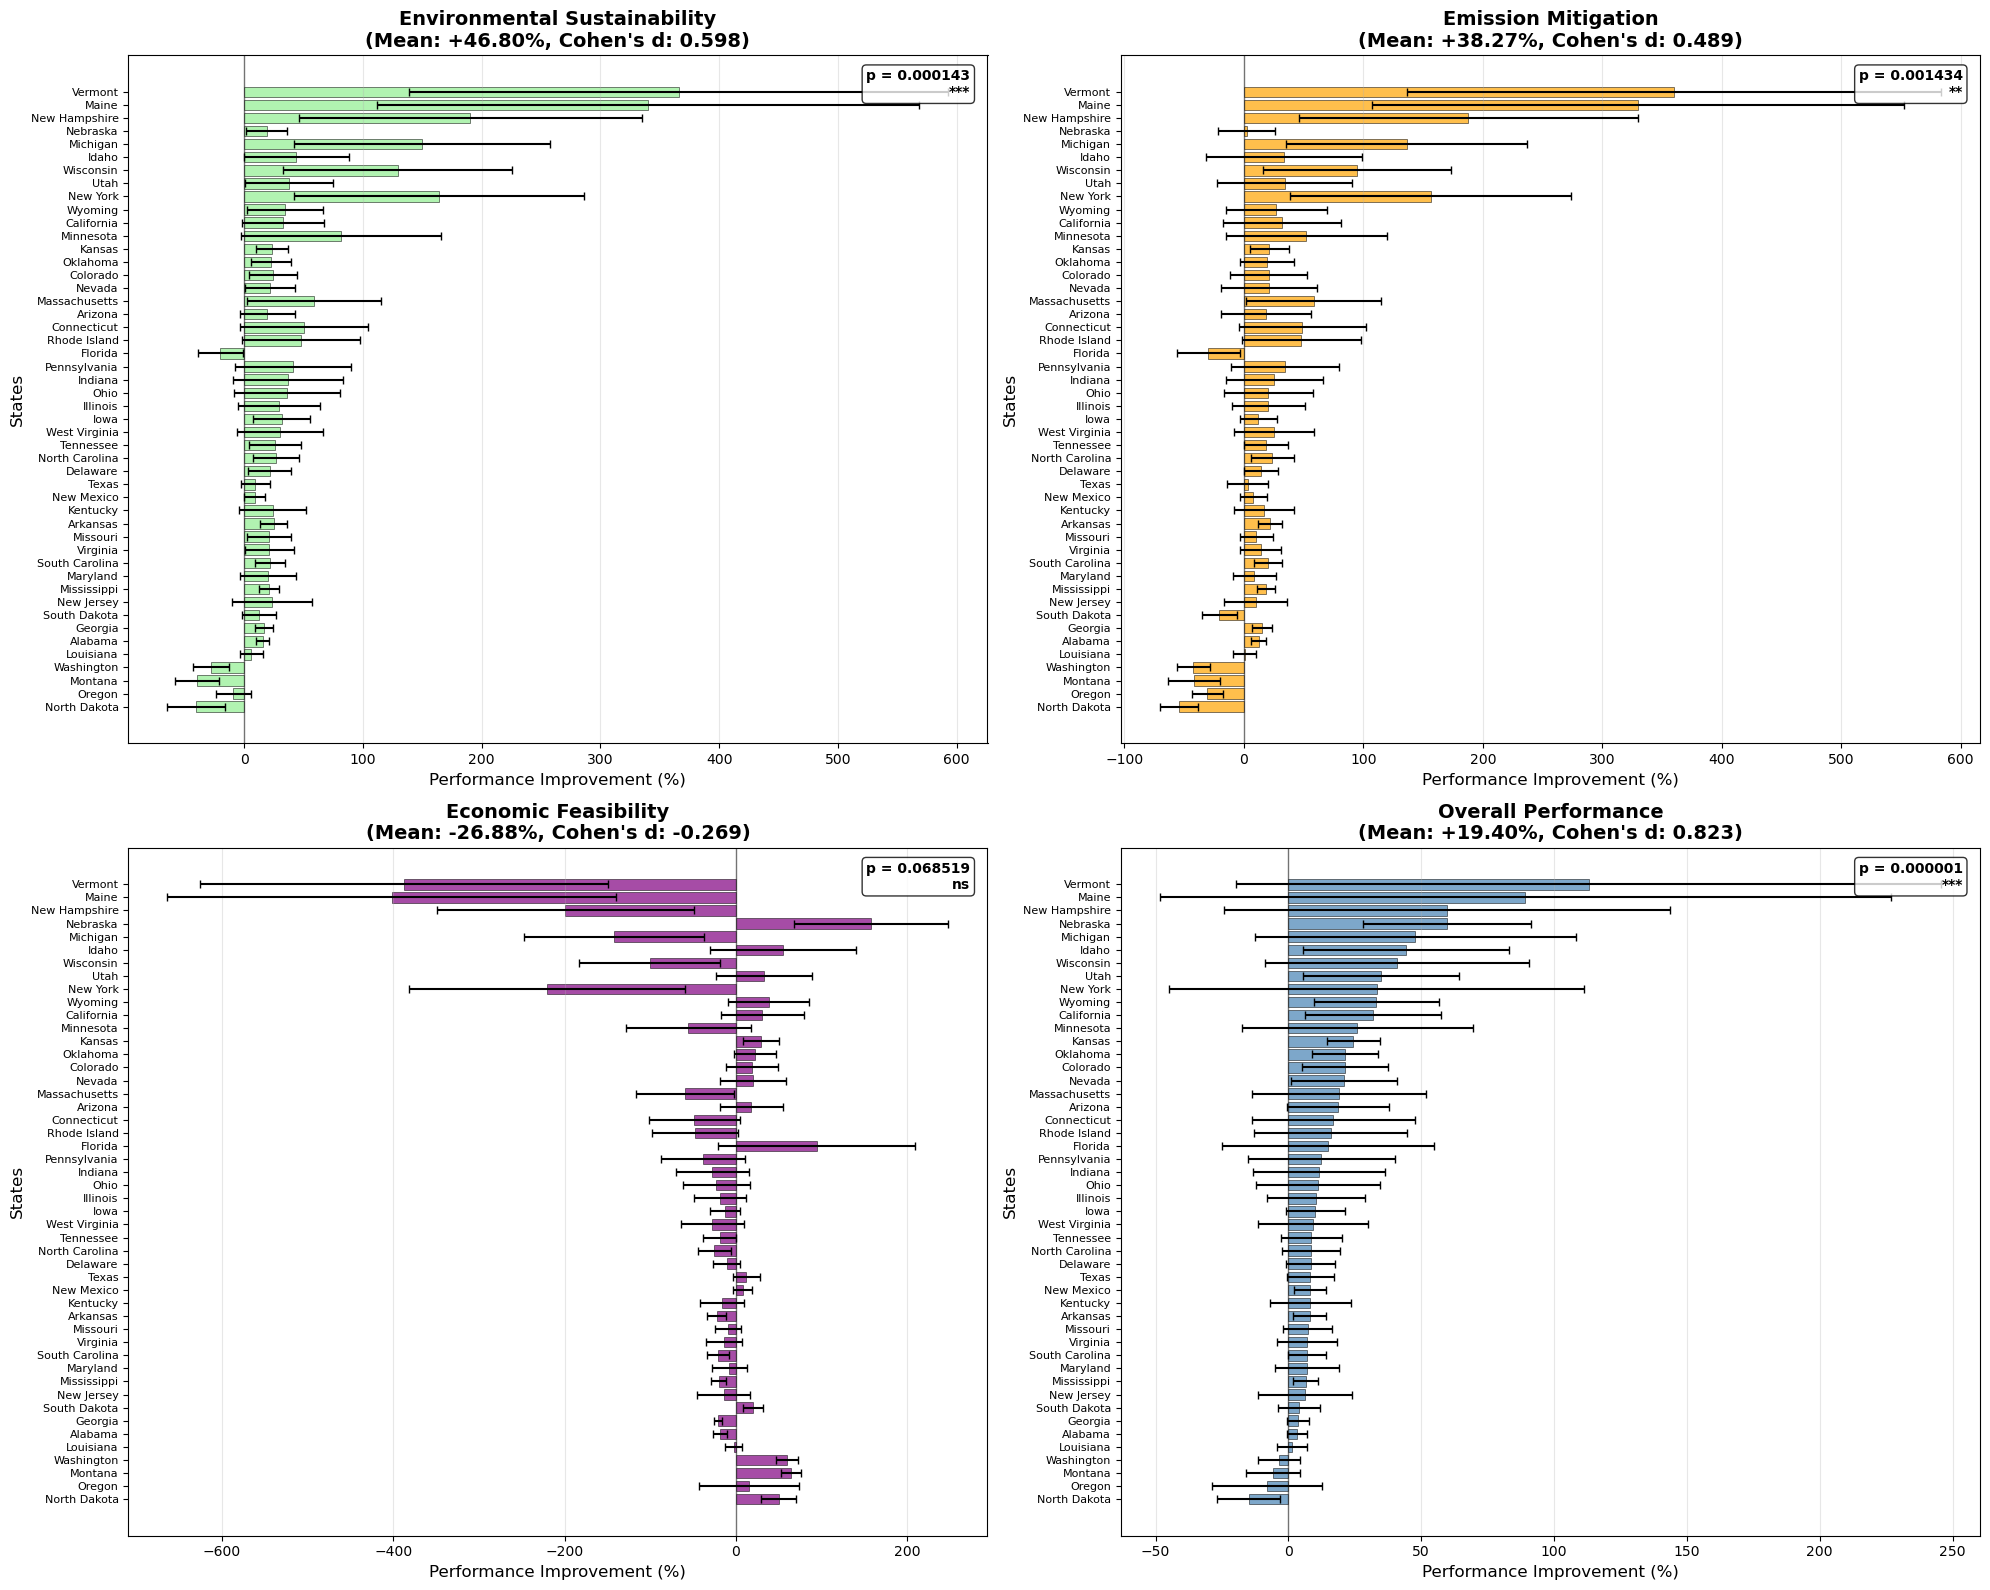


=== 创建汇总统计表 ===
汇总统计表已保存到: data/US_data/US_analysis_reslut/state_performance_summary.csv

=== 汇总统计表 ===
                   Dimension Mean_Improvement Standard_Deviation T_Statistic  P_Value Significance Cohens_D
Environmental Sustainability          +46.80%             78.33%       4.140 0.000143          ***    0.598
         Emission Mitigation          +38.27%             78.27%       3.388 0.001434           **    0.489
        Economic Feasibility          -26.88%             99.87%      -1.864 0.068519           ns   -0.269
         Overall Performance          +19.40%             23.57%       5.703 0.000001          ***    0.823

=== 创建表现最好和最差的州分析 ===
前10后10州对比图已保存到: data/US_data/US_analysis_reslut/top_bottom_states_comparison.png


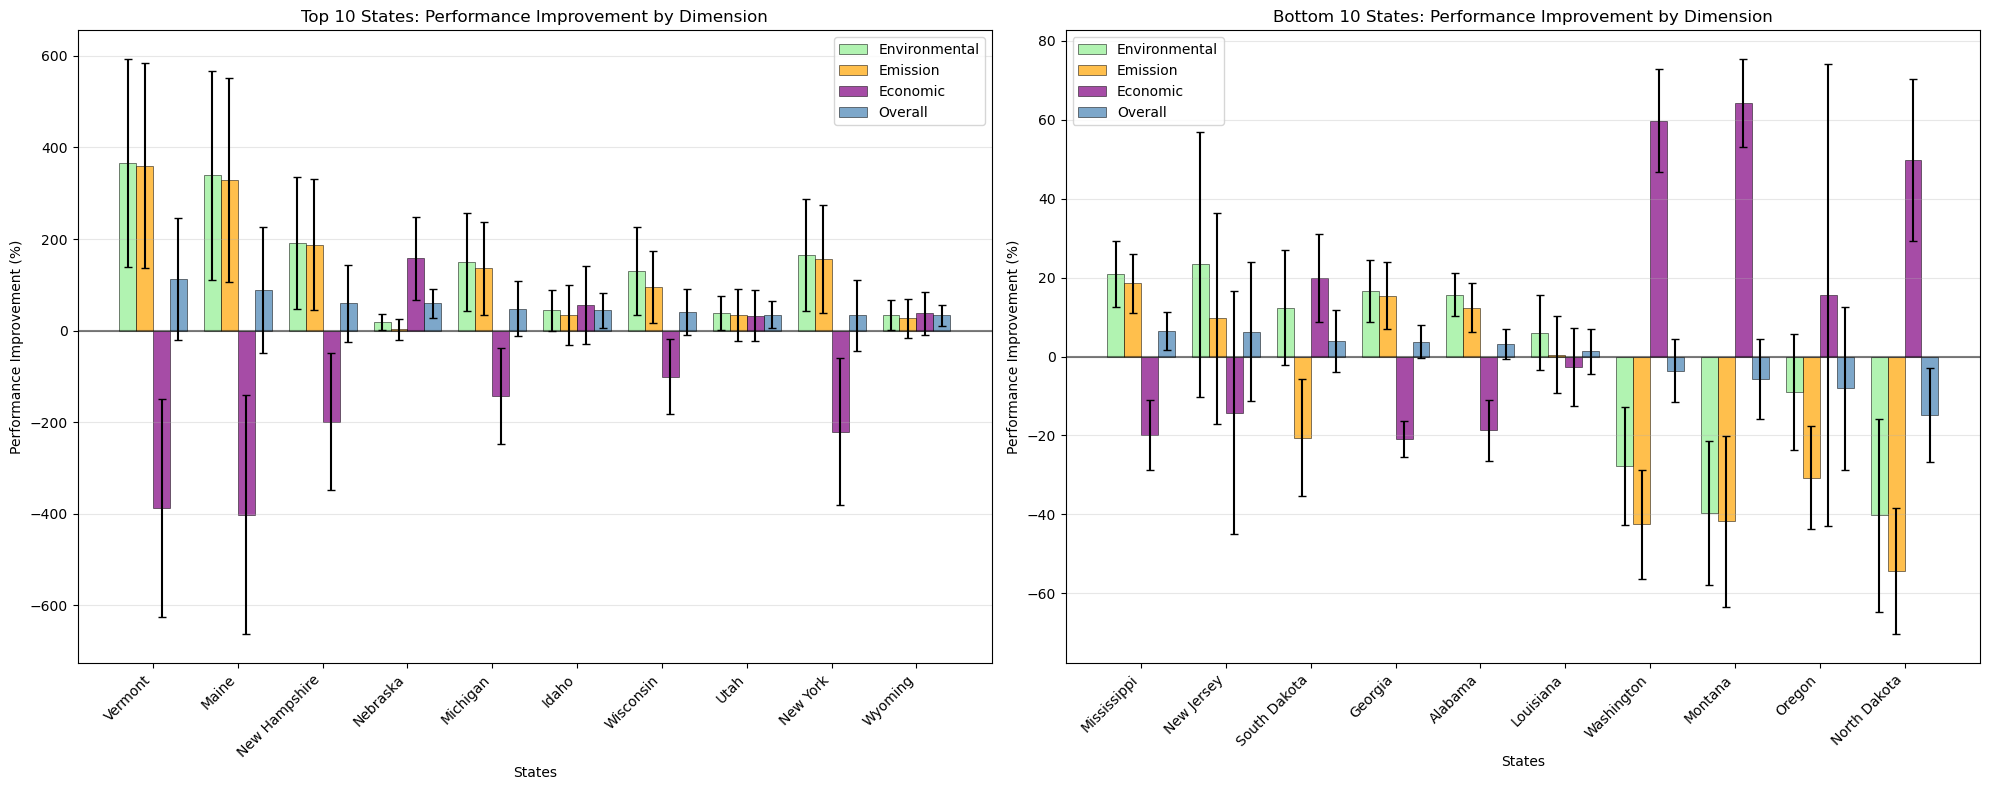


=== 分析完成 ===
所有图表已保存到 data/US_data/US_analysis_reslut/ 目录


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

def create_state_performance_bar_charts(merged_df, output_dir='data/US_data/US_analysis_reslut'):
    """
    创建各州三个维度+Overall的性能提升条形图
    
    参数:
    - merged_df: 包含WCCD性能提升数据的DataFrame
    - output_dir: 输出目录
    
    返回:
    - 各州性能提升条形图
    """
    print("=== 开始创建各州性能提升条形图 ===")
    
    # 过滤有效数据
    valid_data = merged_df[merged_df['Overall_improvement_mean'].notna()].copy()
    
    if len(valid_data) == 0:
        print("没有有效的性能提升数据")
        return None
    
    print(f"有效州数: {len(valid_data)}")
    
    # 定义四个维度
    dimensions = ['Environmental_improvement_mean', 'Emission_improvement_mean', 'Economic_improvement_mean', 'Overall_improvement_mean']
    dimension_labels = ['Environmental Sustainability', 'Emission Mitigation', 'Economic Feasibility', 'Overall Performance']
    std_columns = ['Environmental_improvement_std', 'Emission_improvement_std', 'Economic_improvement_std', 'Overall_improvement_std']
    colors = ['lightgreen', 'orange', 'purple', 'steelblue']
    
    # 计算各维度的显著性水平
    dimension_stats = {}
    
    for dim, label, std_col in zip(dimensions, dimension_labels, std_columns):
        values = valid_data[dim].values
        
        # 单样本t检验
        t_stat, p_value = stats.ttest_1samp(values, 0)
        
        # 效应量
        std_val = np.std(values, ddof=1)
        cohens_d = np.mean(values) / std_val if std_val != 0 else 0
        
        dimension_stats[dim] = {
            'label': label,
            'mean': np.mean(values),
            'std': std_val,
            't_stat': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d
        }
    
    # 按总体性能提升排序
    valid_data_sorted = valid_data.sort_values('Overall_improvement_mean', ascending=True).reset_index(drop=True)
    
    # 创建四个子图
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    for i, (dim, label, std_col, color) in enumerate(zip(dimensions, dimension_labels, std_columns, colors)):
        ax = axes[i]
        
        # 获取数据
        means = valid_data_sorted[dim].values
        stds = valid_data_sorted[std_col].values
        state_names = valid_data_sorted['State_name'].values
        
        # 创建条形图
        y_pos = np.arange(len(means))
        bars = ax.barh(y_pos, means, xerr=stds, capsize=3, alpha=0.7, color=color, edgecolor='black', linewidth=0.5)
        
        # 设置y轴标签
        ax.set_yticks(y_pos)
        ax.set_yticklabels(state_names, fontsize=8)
        
        # 设置x轴标签
        ax.set_xlabel('Performance Improvement (%)', fontsize=12)
        ax.set_ylabel('States', fontsize=12)
        
        # 添加零线
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
        
        # 添加网格
        ax.grid(True, alpha=0.3, axis='x')
        
        # 在右上角添加显著性信息
        stats_info = dimension_stats[dim]
        significance = '***' if stats_info['p_value'] < 0.001 else '**' if stats_info['p_value'] < 0.01 else '*' if stats_info['p_value'] < 0.05 else 'ns'
        
        # 创建显著性文本
        sig_text = f'p = {stats_info["p_value"]:.6f}\n{significance}'
        
        # 在右上角添加文本
        ax.text(0.98, 0.98, sig_text, transform=ax.transAxes, 
                ha='right', va='top', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='black'))
        
        # 设置标题
        ax.set_title(f'{label}\n(Mean: {stats_info["mean"]:+.2f}%, Cohen\'s d: {stats_info["cohens_d"]:.3f})', 
                    fontsize=14, fontweight='bold')
        
        # 调整布局
        ax.tick_params(axis='y', labelsize=8)
        ax.tick_params(axis='x', labelsize=10)
    
    # 调整子图间距
    plt.tight_layout()
    
    # 保存图表
    bar_path = f'{output_dir}/state_performance_bar_charts.png'
    plt.savefig(bar_path, dpi=300, bbox_inches='tight')
    print(f"各州性能提升条形图已保存到: {bar_path}")
    plt.show()
    
    # 创建汇总统计表
    create_summary_statistics_table(dimension_stats, output_dir)
    
    return dimension_stats

def create_summary_statistics_table(dimension_stats, output_dir):
    """
    创建汇总统计表
    """
    print("\n=== 创建汇总统计表 ===")
    
    # 创建汇总数据
    summary_data = []
    for dim, stats in dimension_stats.items():
        significance = '***' if stats['p_value'] < 0.001 else '**' if stats['p_value'] < 0.01 else '*' if stats['p_value'] < 0.05 else 'ns'
        
        summary_data.append({
            'Dimension': stats['label'],
            'Mean_Improvement': f"{stats['mean']:+.2f}%",
            'Standard_Deviation': f"{stats['std']:.2f}%",
            'T_Statistic': f"{stats['t_stat']:.3f}",
            'P_Value': f"{stats['p_value']:.6f}",
            'Significance': significance,
            'Cohens_D': f"{stats['cohens_d']:.3f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # 保存汇总表
    summary_path = f'{output_dir}/state_performance_summary.csv'
    summary_df.to_csv(summary_path, index=False)
    print(f"汇总统计表已保存到: {summary_path}")
    
    # 打印汇总表
    print("\n=== 汇总统计表 ===")
    print(summary_df.to_string(index=False))
    
    return summary_df

def create_top_bottom_states_analysis(merged_df, output_dir='data/US_data/US_analysis_reslut'):
    """
    创建表现最好和最差的州分析
    """
    print("\n=== 创建表现最好和最差的州分析 ===")
    
    # 过滤有效数据
    valid_data = merged_df[merged_df['Overall_improvement_mean'].notna()].copy()
    
    if len(valid_data) == 0:
        print("没有有效的性能提升数据")
        return None
    
    # 按总体性能提升排序
    valid_data_sorted = valid_data.sort_values('Overall_improvement_mean', ascending=False)
    
    # 获取前10和后10个州
    top_10 = valid_data_sorted.head(10)
    bottom_10 = valid_data_sorted.tail(10)
    
    # 创建对比图
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # 前10个州
    ax1 = axes[0]
    dimensions = ['Environmental_improvement_mean', 'Emission_improvement_mean', 'Economic_improvement_mean', 'Overall_improvement_mean']
    dimension_labels = ['Environmental', 'Emission', 'Economic', 'Overall']
    colors = ['lightgreen', 'orange', 'purple', 'steelblue']
    
    x = np.arange(len(top_10))
    width = 0.2
    
    for i, (dim, label, color) in enumerate(zip(dimensions, dimension_labels, colors)):
        means = top_10[dim].values
        stds = top_10[dim.replace('_mean', '_std')].values
        
        ax1.bar(x + i*width, means, width, label=label, color=color, alpha=0.7, 
                yerr=stds, capsize=3, edgecolor='black', linewidth=0.5)
    
    ax1.set_xlabel('States')
    ax1.set_ylabel('Performance Improvement (%)')
    ax1.set_title('Top 10 States: Performance Improvement by Dimension')
    ax1.set_xticks(x + width * 1.5)
    ax1.set_xticklabels(top_10['State_name'], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # 后10个州
    ax2 = axes[1]
    
    for i, (dim, label, color) in enumerate(zip(dimensions, dimension_labels, colors)):
        means = bottom_10[dim].values
        stds = bottom_10[dim.replace('_mean', '_std')].values
        
        ax2.bar(x + i*width, means, width, label=label, color=color, alpha=0.7,
                yerr=stds, capsize=3, edgecolor='black', linewidth=0.5)
    
    ax2.set_xlabel('States')
    ax2.set_ylabel('Performance Improvement (%)')
    ax2.set_title('Bottom 10 States: Performance Improvement by Dimension')
    ax2.set_xticks(x + width * 1.5)
    ax2.set_xticklabels(bottom_10['State_name'], rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    plt.tight_layout()
    
    # 保存图表
    comparison_path = f'{output_dir}/top_bottom_states_comparison.png'
    plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
    print(f"前10后10州对比图已保存到: {comparison_path}")
    plt.show()
    
    return top_10, bottom_10

# 使用示例
if __name__ == "__main__":
    # 读取数据
    merged_df = pd.read_csv('data/US_data/US_analysis_reslut/state_level_analysis_with_wccd.csv')
    
    # 创建各州性能提升条形图
    dimension_stats = create_state_performance_bar_charts(merged_df)
    
    # 创建表现最好和最差的州分析
    top_10, bottom_10 = create_top_bottom_states_analysis(merged_df)
    
    print("\n=== 分析完成 ===")
    print("所有图表已保存到 data/US_data/US_analysis_reslut/ 目录")